In [2]:
# To make sure Python can import from reservoirs/ and utils/ etc. when running the notebook from notebooks/
import sys
import os
sys.path.append(os.path.abspath(".."))  # go up one directory to parent

In [3]:
# --- Standard scientific libraries ---
import itertools, tqdm, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
from pathlib import Path
from matplotlib.gridspec import GridSpec
from scipy.spatial import cKDTree, distance
from numpy.linalg import norm
from scipy.signal import hilbert, find_peaks 
from sklearn.linear_model import Ridge
import inspect
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy import signal
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Patch

# --- Reservoir implementations ---
from reservoirs.cycle import CycleReservoir3D, CRJRes3D
from reservoirs.sparse import SparseESN3D
#from reservoirs.mci_esn import MCI3D
#from reservoirs.parallel_esn import ParallelESN
from reservoirs.deep_esn import DeepESN3D
from reservoirs.small_world import SWRes3D_IO
#from reservoirs.hyper import HyperbolicRes, EuclideanRes, SphericalRes
#from reservoirs.hfr import HFR3D
#from reservoirs.bei_stp import BEISTPReservoirESN
#from reservoirs.swirl_gated_multicycle import SwirlGatedMultiCycleESN
#from reservoirs.resonator import ResonatorReservoirESN
#from reservoirs.glia_neuron import GliaNeuronTripartiteReservoirESN
#from reservoirs.diffusion_wavelet import DiffusionWaveletReservoirESN, adj
#from reservoirs.short_term_plasticity import STPESN
#from reservoirs.ltsr import LTSRRes3D
#from reservoirs.tgc import TGCCoupledESN
from reservoirs.decesn import DECESN

# --- Utility modules ---
from utils.datasets import generate_lorenz_data, generate_rossler_data, generate_chen_data, generate_chua_data, generate_mackey_glass_data
from utils.metrics import compute_valid_prediction_time, compute_attractor_deviation, evaluate_nrmse, mse_dimwise
from utils.plotting import plot_timeseries, plot_lorenz_3d
from utils.dynamics import *


In [4]:
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
from pathlib import Path

FIG_DIR = Path(r"C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures")
FIG_DIR.mkdir(exist_ok=True)


# Unified experiment driver for cannonical chaotic benchmarks with one knob

In [3]:
import optuna
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
from sklearn.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')

# ============================================
# System generation functions (from your code)
# ============================================

def generate_lorenz_data(initial_state, tmax=250.0, dt=0.02, sigma=10.0, rho=28.0, beta=8.0/3.0):
    """Generate Lorenz system data"""
    def lorenz(state, t):
        x, y, z = state
        return [
            sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z
        ]
    
    t = np.arange(0, tmax, dt)
    trajectory = np.zeros((len(t), 3))
    trajectory[0] = initial_state
    
    for i in range(1, len(t)):
        k1 = np.array(lorenz(trajectory[i-1], t[i-1])) * dt
        k2 = np.array(lorenz(trajectory[i-1] + k1/2, t[i-1] + dt/2)) * dt
        k3 = np.array(lorenz(trajectory[i-1] + k2/2, t[i-1] + dt/2)) * dt
        k4 = np.array(lorenz(trajectory[i-1] + k3, t[i-1] + dt)) * dt
        trajectory[i] = trajectory[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return t, trajectory

def generate_rossler_data(initial_state, tmax=250.0, dt=0.02, a=0.2, b=0.2, c=5.7):
    """Generate Rössler system data"""
    def rossler(state, t):
        x, y, z = state
        return [
            -y - z,
            x + a * y,
            b + z * (x - c)
        ]
    
    t = np.arange(0, tmax, dt)
    trajectory = np.zeros((len(t), 3))
    trajectory[0] = initial_state
    
    for i in range(1, len(t)):
        k1 = np.array(rossler(trajectory[i-1], t[i-1])) * dt
        k2 = np.array(rossler(trajectory[i-1] + k1/2, t[i-1] + dt/2)) * dt
        k3 = np.array(rossler(trajectory[i-1] + k2/2, t[i-1] + dt/2)) * dt
        k4 = np.array(rossler(trajectory[i-1] + k3, t[i-1] + dt)) * dt
        trajectory[i] = trajectory[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return t, trajectory

def generate_chen_data(initial_state, tmax=250.0, dt=0.02, a=35.0, b=3.0, c=28.0):
    """Generate Chen-Ueta system data"""
    def chen(state, t):
        x, y, z = state
        return [
            a * (y - x),
            (c - a) * x - x * z + c * y,
            x * y - b * z
        ]
    
    t = np.arange(0, tmax, dt)
    trajectory = np.zeros((len(t), 3))
    trajectory[0] = initial_state
    
    for i in range(1, len(t)):
        k1 = np.array(chen(trajectory[i-1], t[i-1])) * dt
        k2 = np.array(chen(trajectory[i-1] + k1/2, t[i-1] + dt/2)) * dt
        k3 = np.array(chen(trajectory[i-1] + k2/2, t[i-1] + dt/2)) * dt
        k4 = np.array(chen(trajectory[i-1] + k3, t[i-1] + dt)) * dt
        trajectory[i] = trajectory[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return t, trajectory

def _system_call(system: str, init_state, tmax=250.0, dt=0.02):
    """Call appropriate system generator"""
    if system == "lorenz":
        return generate_lorenz_data(initial_state=init_state, tmax=tmax, dt=dt)
    elif system == "rossler":
        return generate_rossler_data(initial_state=init_state, tmax=tmax, dt=dt)
    elif system in ("chen", "chen-ueta", "chen_ueta"):
        return generate_chen_data(initial_state=init_state, tmax=tmax, dt=dt)
    else:
        raise ValueError(f"Unknown SYSTEM={system}")

def _estimate_lambda_rosenstein(traj: np.ndarray, dt: float,
                                theiler: int = 50,
                                max_horizon: int = 200,
                                n_samples: int = 1500,
                                fit_range: tuple = (5, 60)) -> float:
    """Estimate largest Lyapunov exponent using Rosenstein method"""
    X = np.asarray(traj, dtype=float)
    T, d = X.shape
    if d < 2 or T < theiler + max_horizon + 5:
        return np.nan

    # Pick sample indices
    idx_pool = np.arange(0, T - max_horizon - 1)
    if len(idx_pool) > n_samples:
        rng = np.random.default_rng(0)
        idx_pool = rng.choice(idx_pool, size=n_samples, replace=False)
    idx_pool.sort()

    # Nearest neighbor search with Theiler window exclusion
    nbrs = NearestNeighbors(n_neighbors=min(10, T//2), algorithm="auto").fit(X)
    distances, indices = nbrs.kneighbors(X)
    nn = np.empty(T, dtype=int)
    
    for i in range(T):
        j = indices[i, 1] if indices.shape[1] > 1 else indices[i, 0]
        k = 2
        while k < indices.shape[1] and abs(j - i) <= theiler:
            j = indices[i, k]
            k += 1
        nn[i] = j

    # Compute mean log divergence curve
    taus = np.arange(1, max_horizon+1)
    log_div = np.zeros_like(taus, dtype=float)
    counts = np.zeros_like(taus, dtype=int)

    eps = 1e-12
    for i in idx_pool:
        j = nn[i]
        if abs(j - i) <= theiler or j >= T:
            continue
        max_tau = min(max_horizon, T-1-i, T-1-j)
        if max_tau < 5:
            continue
        diffs = X[i+1:i+max_tau+1] - X[j+1:j+max_tau+1]
        ds = np.linalg.norm(diffs, axis=1) + eps
        log_div[:max_tau] += np.log(ds)
        counts[:max_tau] += 1

    valid = counts > 0
    if not np.any(valid):
        return np.nan
    mean_log_div = np.zeros_like(log_div)
    mean_log_div[valid] = log_div[valid] / counts[valid]

    # Linear fit
    t0, t1 = fit_range
    t0 = max(t0, 1)
    t1 = min(t1, np.max(np.where(valid)[0], initial=t1))
    if t1 - t0 < 5:
        return np.nan
    x = taus[t0:t1] * dt
    y = mean_log_div[t0:t1]
    slope, _ = np.polyfit(x, y, 1)
    return float(max(slope, 0.0))

# Lambda max values for each system
LAMBDA_MAP = {
    "lorenz": 0.90,
    "rossler": 0.07,
    "chen-ueta": 2.038,
}

def get_lambda_max(system: str, test_y: np.ndarray, dt: float, mode="auto") -> float:
    """Get lambda_max for system"""
    if mode == "fixed":
        return float(LAMBDA_MAP[system])
    # Auto estimation
    lam = _estimate_lambda_rosenstein(test_y, dt)
    if not np.isfinite(lam) or lam <= 0:
        lam = float(LAMBDA_MAP[system])
    return lam

# Placeholder evaluation functions - you'll need to replace these with your actual implementations
def evaluate_nrmse(predictions, targets, horizons):
    """Calculate NRMSE for given horizons"""
    results = {}
    target_std = np.std(targets)
    
    for h in horizons:
        if h >= len(predictions):
            results[h] = float('inf')
            continue
        mse = np.mean((predictions[:h] - targets[:h])**2)
        rmse = np.sqrt(mse)
        nrmse = rmse / target_std if target_std > 0 else float('inf')
        results[h] = nrmse
    
    return results

def compute_valid_prediction_time(true_traj, pred_traj, time_array, threshold=0.4, lambda_max=1.0):
    """Compute valid prediction time"""
    # Simple implementation - replace with your actual VPT calculation
    errors = np.linalg.norm(pred_traj - true_traj, axis=1)
    error_threshold = threshold * np.std(true_traj)
    
    valid_indices = np.where(errors <= error_threshold)[0]
    if len(valid_indices) == 0:
        return 0.0, 0.0, 0.0
    
    # Find the last consecutive valid index
    vpt_steps = 0
    for i, idx in enumerate(valid_indices):
        if i == 0 or valid_indices[i] == valid_indices[i-1] + 1:
            vpt_steps = idx + 1
        else:
            break
    
    T_VPT = vpt_steps * (time_array[1] - time_array[0]) if vpt_steps > 0 else 0.0
    T_lambda = T_VPT * lambda_max
    ratio = T_lambda / lambda_max if lambda_max > 0 else 0.0
    
    return T_VPT, T_lambda, ratio


In [4]:
import optuna
import numpy as np

def sample_hyperparams_for_vpt(trial, system="lorenz"):
    """
    Theory-consistent sampler for CHORD/DECESN targeting VPT.
    - All discrete floats are 2-decimal using step=0.01.
    - Harmonic memory is slow (leak_harm fixed to 0.04).
    - Per-degree leaks in [0.15, 0.35].
    - Cross-couplings alpha,beta,gamma in [0.05, 0.50] (no normalization).
    - Mixer gains in [0.40, 0.80].
    - ridge_alpha fixed to 1e-4 for fair baselines.
    """

    def suggest_discrete_float(trial, name, low, high, step=0.01):
        low_int = int(round(low / step))
        high_int = int(round(high / step))
        sampled_int = trial.suggest_int(f"{name}_discrete", low_int, high_int)
        return round(sampled_int * step, 2)

    def suggest_discrete_log_float(trial, name, low, high, step=0.01):
        log_low = np.log(low)
        log_high = np.log(high)
        log_val = trial.suggest_float(f"{name}_log", log_low, log_high)
        raw_val = np.exp(log_val)
        discretized = round(round(raw_val / step) * step, 2)
        return max(low, min(high, discretized))

    # System-specific ranges (kept as in your original design)
    if system == "lorenz":
        input_scale_range = (0.10, 0.50)
        heat_range = (0.01, 0.08)
    elif system == "rossler":
        input_scale_range = (0.05, 0.40)
        heat_range = (0.01, 0.05)
    else:  # chen-ueta
        input_scale_range = (0.10, 0.60)
        heat_range = (0.01, 0.10)

    # Fixed size
    num_nodes = 400

    # Leaks (harmonic is slow; exact & coexact moderate)
    leak_exact = suggest_discrete_float(trial, "leak_exact", 0.30, 0.60)
    leak_coexact = suggest_discrete_float(trial, "leak_coexact", 0.30, 0.60)
    leak_harm = 0.04  # in [0.01, 0.08], fixed to encourage long memory

    # Discrete integer params
    avg_degree = trial.suggest_int("avg_degree", 6, 12)
    cg_maxiter = trial.suggest_int("cg_maxiter", 75, 200, step=25)
    proj_every = trial.suggest_int("proj_every", 1, 8)

    # Per-degree leaks (λ0, λ1, λ2)
    lam_node = suggest_discrete_float(trial, "lam_node", 0.15, 0.35)
    lam_edge = suggest_discrete_float(trial, "lam_edge", 0.15, 0.35)
    lam_face = suggest_discrete_float(trial, "lam_face", 0.15, 0.35)

    # Heat parameters (log-sampled, 2-dp)
    heat0 = suggest_discrete_log_float(trial, "heat0", heat_range[0], heat_range[1])
    heat1 = suggest_discrete_log_float(trial, "heat1", heat_range[0], heat_range[1])
    heat2 = suggest_discrete_log_float(trial, "heat2", heat_range[0], heat_range[1])

    # Cross-coupling gains (no normalization; each within [0.05, 0.50])
    alpha = suggest_discrete_float(trial, "alpha", 0.05, 0.50)
    beta  = suggest_discrete_float(trial, "beta", 0.05, 0.50)
    gamma = suggest_discrete_float(trial, "gamma", 0.05, 0.50)

    # Mixing gains
    node_mix_gain = suggest_discrete_float(trial, "node_mix_gain", 0.40, 0.80)
    edge_mix_gain = suggest_discrete_float(trial, "edge_mix_gain", 0.40, 0.80)
    face_mix_gain = suggest_discrete_float(trial, "face_mix_gain", 0.40, 0.80)

    # Input scaling (log-sampled, 2-dp)
    input_scale_node = suggest_discrete_log_float(trial, "input_scale_node",
                                                  input_scale_range[0], input_scale_range[1])
    input_scale_edge = suggest_discrete_log_float(trial, "input_scale_edge",
                                                  input_scale_range[0], input_scale_range[1])
    input_scale_face = suggest_discrete_log_float(trial, "input_scale_face",
                                                  input_scale_range[0], input_scale_range[1])

    # Numerical params
    projector_eps = round(trial.suggest_float("projector_eps", 1e-5, 1e-3, log=True), 5)
    cg_tol = round(trial.suggest_float("cg_tol", 1e-6, 1e-3, log=True), 6)

    # Fair baseline: fixed ridge_alpha across methods
    ridge_alpha = 1e-4

    # Categorical
    use_poly = trial.suggest_categorical("use_poly", [True, False])
    feature_mode = trial.suggest_categorical("feature_mode", ["node", "node_harm", "full"])

    return dict(
        num_nodes=num_nodes,
        input_dim=3,
        edges=None,
        faces=None,
        avg_degree=avg_degree,
        star0_diag=None,
        star1_diag=None,
        star2_diag=None,
        lam_node=lam_node,
        lam_edge=lam_edge,
        lam_face=lam_face,
        leak_exact=leak_exact,
        leak_coexact=leak_coexact,
        leak_harm=leak_harm,
        heat0=heat0,
        heat1=heat1,
        heat2=heat2,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        node_mix_gain=node_mix_gain,
        edge_mix_gain=edge_mix_gain,
        face_mix_gain=face_mix_gain,
        input_scale_node=input_scale_node,
        input_scale_edge=input_scale_edge,
        input_scale_face=input_scale_face,
        projector_eps=projector_eps,
        cg_tol=cg_tol,
        cg_maxiter=cg_maxiter,
        proj_every=proj_every,
        ridge_alpha=ridge_alpha,
        use_poly=use_poly,
        feature_mode=feature_mode,
    )


In [5]:
def make_vpt_objective(system, data_scenarios, seeds=3, discard=100, 
                       robustness_penalty=0.1, nrmse_threshold=1.0):
    """
    Create objective function for VPT maximization.
    
    Args:
        system: "lorenz", "rossler", or "chen-ueta"
        data_scenarios: List of data dictionaries with train/test splits
        seeds: Number of random seeds to test
        discard: Washout period for training
        robustness_penalty: Penalty for high VPT standard deviation
        nrmse_threshold: Maximum acceptable NRMSE (prune if exceeded)
    """
    def objective(trial):
        hp = sample_hyperparams_for_vpt(trial, system)
        
        all_vpts = []
        all_nrmses = []
        
        for seed in range(seeds):
            seed_vpts = []
            seed_nrmses = []
            
            try:
                hp["seed"] = seed + 1000
                
                for scenario_data in data_scenarios:
                    # Create model instance
                    model = DECESN(**hp)
                    
                    # Fit readout with error handling
                    model.fit_readout(
                        scenario_data["train_in"], 
                        scenario_data["train_y"], 
                        discard=discard
                    )
                    
                    # Check model stability after training
                    if (np.any(np.isnan(model.x)) or np.any(np.isinf(model.x)) or 
                        np.any(np.isnan(model.y)) or np.any(np.isinf(model.y)) or
                        (hasattr(model, 'z') and model.z is not None and 
                         (np.any(np.isnan(model.z)) or np.any(np.isinf(model.z))))):
                        raise optuna.TrialPruned()
                    
                    # Check readout weights
                    if (hasattr(model, 'W_out') and model.W_out is not None and 
                        (np.any(np.isnan(model.W_out)) or np.any(np.isinf(model.W_out)) or
                         np.max(np.abs(model.W_out)) > 1e6)):
                        raise optuna.TrialPruned()
                    
                    # Generate predictions
                    preds = model.predict_autoregressive(
                        scenario_data["test_in"][0], 
                        len(scenario_data["test_y"])
                    )
                    
                    # Check prediction stability
                    if np.any(np.isnan(preds)) or np.any(np.isinf(preds)):
                        raise optuna.TrialPruned()
                    
                    # Calculate NRMSE for quality check
                    horizons = [500, 1000]
                    nrmse_dict = evaluate_nrmse(preds, scenario_data["test_y"], horizons)
                    nrmse_score = nrmse_dict[horizons[-1]]
                    
                    if isinstance(nrmse_score, (list, np.ndarray)):
                        nrmse_score = np.mean(nrmse_score)
                    
                    # Prune if NRMSE is too high (model is not learning properly)
                    if np.isnan(nrmse_score) or nrmse_score > nrmse_threshold:
                        raise optuna.TrialPruned()
                    
                    # Calculate VPT
                    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
                        scenario_data["test_y"], 
                        preds, 
                        scenario_data["time_test"],
                        threshold=0.4, 
                        lambda_max=scenario_data["lambda_max"]
                    )
                    
                    # Check VPT validity
                    if np.isnan(T_VPT) or T_VPT <= 0:
                        T_VPT = 0.0  # Set minimum VPT
                    
                    seed_vpts.append(T_VPT)
                    seed_nrmses.append(nrmse_score)
                
                # Average across scenarios for this seed
                if seed_vpts:
                    all_vpts.append(np.mean(seed_vpts))
                    all_nrmses.append(np.mean(seed_nrmses))
                else:
                    raise optuna.TrialPruned()
                
            except (ValueError, RuntimeError, np.linalg.LinAlgError, MemoryError):
                raise optuna.TrialPruned()
            except Exception as e:
                print(f"Unexpected error in trial {trial.number}, seed {seed}: {e}")
                raise optuna.TrialPruned()
        
        if not all_vpts:
            raise optuna.TrialPruned()
        
        # Calculate statistics
        mean_vpt = np.mean(all_vpts)
        std_vpt = np.std(all_vpts) if len(all_vpts) > 1 else 0.0
        mean_nrmse = np.mean(all_nrmses)
        
        # Print trial results
        print(f"\n--- Trial {trial.number} Results ({system.upper()}) ---")
        print(f"Hyperparameters (key):")
        print(f"  num_nodes: {hp['num_nodes']}, avg_degree: {hp['avg_degree']}")
        print(f"  leak_exact: {hp['leak_exact']:.3f}, leak_coexact: {hp['leak_coexact']:.3f}")
        print(f"  leak_harm: {hp['leak_harm']:.3f}")
        print(f"  feature_mode: {hp['feature_mode']}, use_poly: {hp['use_poly']}")
        print(f"Performance:")
        print(f"  Mean VPT: {mean_vpt:.6f} ± {std_vpt:.6f}")
        print(f"  Mean NRMSE: {mean_nrmse:.6f}")
        
        # Objective: maximize VPT with robustness penalty
        # We return negative value because Optuna minimizes
        objective_score = mean_vpt - robustness_penalty * std_vpt
        print(f"  Objective Score: {objective_score:.6f}")
        print("-" * 50)
        
        return -objective_score  # Negative because we want to maximize
    
    return objective


In [6]:
def optimize_vpt_for_system(system, n_trials=100, n_jobs=2):
    """
    Run VPT optimization for a specific chaotic system.
    
    Args:
        system: "lorenz", "rossler", or "chen-ueta"
        n_trials: Number of Optuna trials
        n_jobs: Number of parallel jobs
    """
    print(f"\n{'='*60}")
    print(f"OPTIMIZING VPT FOR {system.upper()} SYSTEM")
    print(f"{'='*60}")
    
    # Generate data scenarios (using your existing DATA preparation logic)
    # This assumes you have the data generation functions available
    init_grid = [[1.0, 1.0, 1.0]]
    split_grid = [0.8]
    
    scenarios = []
    for init_id, init_state in enumerate(init_grid, start=1):
        t_vals, full_data = _system_call(system, init_state, tmax=250.0, dt=0.02)
        full_data = full_data[2000:]  # washout
        
        for split in split_grid:
            idx = int(split * (len(full_data) - 1))
            train_in, train_y = full_data[:idx], full_data[1:idx+1]
            test_in, test_y = full_data[idx:-1], full_data[idx+1:]
            time_test = np.arange(len(test_y)) * 0.02
            lambda_max = get_lambda_max(system, test_y, 0.02)
            
            scenarios.append({
                "train_in": train_in,
                "train_y": train_y,
                "test_in": test_in,
                "test_y": test_y,
                "time_test": time_test,
                "lambda_max": lambda_max
            })
    
    # Create study
    study = optuna.create_study(
        direction="minimize",  # We minimize negative VPT
        sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10, n_min_trials=5)
    )
    
    # Run optimization
    study.optimize(
        make_vpt_objective(system, scenarios, seeds=3, discard=100),
        n_trials=n_trials,
        n_jobs=n_jobs,
        show_progress_bar=True
    )
    
    print(f"\n{'='*60}")
    print(f"OPTIMIZATION RESULTS FOR {system.upper()}")
    print(f"{'='*60}")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best VPT score: {-study.best_trial.value:.6f}")
    print("\nBest parameters:")
    for key, value in study.best_trial.params.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")
    
    return study, study.best_trial.params


In [ ]:
# Main execution
if __name__ == "__main__":
    systems = ["lorenz"]
    best_params = {}
    
    for system in systems:
        study, params = optimize_vpt_for_system(system, n_trials=50, n_jobs=2)
        best_params[system] = params
        
        # Save study results
        study.trials_dataframe().to_csv(f"vpt_optimization_{system}.csv", index=False)
    
    print(f"\n{'='*80}")
    print("SUMMARY OF ALL OPTIMIZATIONS")
    print(f"{'='*80}")
    
    for system, params in best_params.items():
        print(f"\n{system.upper()} - Best Parameters:")
        print(f"num_nodes = {params['num_nodes']}")
        print(f"avg_degree = {params['avg_degree']}")
        print(f"leak_exact = {params['leak_exact']:.6f}")
        print(f"leak_coexact = {params['leak_coexact']:.6f}")
        print(f"leak_harm = {params['leak_harm']:.6f}")
        print(f"feature_mode = '{params['feature_mode']}'")
        print(f"use_poly = {params['use_poly']}")


OPTIMIZING VPT FOR LORENZ SYSTEM


[I 2025-09-02 00:46:08,050] A new study created in memory with name: no-name-7dfaa72c-369b-4474-ae9e-5a23c8a52ec7


  0%|          | 0/50 [00:00<?, ?it/s]

In [1]:
import optuna
import numpy as np

def _round2(x):
    return round(float(x), 2)

def _log_sample_discrete(trial, name, low, high):
    """Log-uniform sample then round to 2dp and clip to bounds."""
    val = trial.suggest_float(name, low, high, log=True)
    return _round2(np.clip(val, low, high))

def check_and_fix_esp(params, max_attempts=6, target_margin=0.95):
    """
    Gershgorin-style check:
      max_expr = max( alpha + node_mix_gain,
                      beta  + edge_mix_gain + gamma,
                      gamma + face_mix_gain )
    Enforce max_expr < 1 by scaling alpha/beta/gamma and mix gains (proportionally),
    clipping to parameter bounds. Returns params and esp_ok boolean.
    """
    alpha = params["alpha"]; beta = params["beta"]; gamma = params["gamma"]
    nmg = params["node_mix_gain"]; emg = params["edge_mix_gain"]; fmg = params["face_mix_gain"]

    def max_expr(a, b, g, nm, em, fm):
        return max(a + nm, b + em + g, g + fm)

    expr = max_expr(alpha, beta, gamma, nmg, emg, fmg)
    attempts = 0
    # parameter bounds used during adjustment
    a_min, a_max = 0.05, 0.50
    mix_min, mix_max = 0.40, 0.80

    while expr >= 1.0 and attempts < max_attempts:
        # scale factor to bring current expr down to target_margin (<1)
        scale = (target_margin) / expr
        # scale couplings and mix gains proportionally
        alpha = float(np.clip(alpha * scale, a_min, a_max))
        beta  = float(np.clip(beta  * scale, a_min, a_max))
        gamma = float(np.clip(gamma * scale, a_min, a_max))
        nmg = float(np.clip(nmg * scale, mix_min, mix_max))
        emg = float(np.clip(emg * scale, mix_min, mix_max))
        fmg = float(np.clip(fmg * scale, mix_min, mix_max))

        expr = max_expr(alpha, beta, gamma, nmg, emg, fmg)
        attempts += 1

    params["alpha"], params["beta"], params["gamma"] = _round2(alpha), _round2(beta), _round2(gamma)
    params["node_mix_gain"], params["edge_mix_gain"], params["face_mix_gain"] = _round2(nmg), _round2(emg), _round2(fmg)
    params["esp_pass"] = expr < 1.0
    params["esp_max_expr"] = float(expr)
    return params

def sample_hyperparams(trial):
    params = {}
    # --- Core dims ---
    params["num_nodes"]  = 400
    params["input_dim"]  = 3
    params["avg_degree"] = int(trial.suggest_int("avg_degree", 4, 12))

    # --- Leakage: per-degree leaks constrained to theory [0.15,0.35] ---
    params["lam_node"] = _round2(trial.suggest_float("lam_node", 0.15, 0.35))
    params["lam_edge"] = _round2(trial.suggest_float("lam_edge", 0.15, 0.35))
    params["lam_face"] = _round2(trial.suggest_float("lam_face", 0.15, 0.35))

    # --- leak_exact / leak_coexact in [0.30, 0.60], harmonic small [0.01,0.08] <= min(...)
    params["leak_exact"]   = _round2(trial.suggest_float("leak_exact", 0.30, 0.60))
    params["leak_coexact"] = _round2(trial.suggest_float("leak_coexact", 0.30, 0.60))
    max_harm = min(params["leak_exact"], params["leak_coexact"], 0.08)
    params["leak_harm"] = _round2(trial.suggest_float("leak_harm", 0.01, max_harm))

    # --- Diffusion / heat (allow moderate range) ---
    params["heat0"] = _round2(trial.suggest_float("heat0", 0.01, 0.35))
    params["heat1"] = _round2(trial.suggest_float("heat1", 0.01, 0.35))
    params["heat2"] = _round2(trial.suggest_float("heat2", 0.01, 0.35))

    # --- Couplings (each bounded to [0.05, 0.50]; do NOT normalize) ---
    params["alpha"] = _round2(trial.suggest_float("alpha", 0.05, 0.50))
    params["beta"]  = _round2(trial.suggest_float("beta",  0.05, 0.50))
    params["gamma"] = _round2(trial.suggest_float("gamma", 0.05, 0.50))

    # --- Mixing gains set to theory recommended [0.40, 0.80] ---
    params["node_mix_gain"] = _round2(trial.suggest_float("node_mix_gain", 0.40, 0.80))
    params["edge_mix_gain"] = _round2(trial.suggest_float("edge_mix_gain", 0.40, 0.80))
    params["face_mix_gain"] = _round2(trial.suggest_float("face_mix_gain", 0.40, 0.80))

    # --- Input scaling (kept moderate) ---
    params["input_scale_node"] = _round2(trial.suggest_float("input_scale_node", 0.05, 0.40))
    params["input_scale_edge"] = _round2(trial.suggest_float("input_scale_edge", 0.05, 0.40))
    params["input_scale_face"] = _round2(trial.suggest_float("input_scale_face", 0.05, 0.40))

    # --- Numerical solver (higher precision kept where needed) ---
    params["projector_eps"] = round(trial.suggest_float("projector_eps", 1e-6, 1e-3, log=True), 6)
    params["cg_tol"]        = round(trial.suggest_float("cg_tol", 1e-7, 1e-3, log=True), 7)
    params["cg_maxiter"]    = int(trial.suggest_int("cg_maxiter", 50, 500))
    params["proj_every"]    = int(trial.suggest_int("proj_every", 1, 50))

    # --- Readout: standardized ridge for fair comparisons ---
    params["ridge_alpha"] = 1e-4  # fixed for consistent baselines
    params["use_poly"]     = trial.suggest_categorical("use_poly", [True, False])
    params["feature_mode"] = trial.suggest_categorical("feature_mode", ["node", "node_harm", "full"])

    # Run Gershgorin-ish check and attempt repair if needed
    params = check_and_fix_esp(params)
    # record ESP status on Optuna trial for later filtering/analysis
    trial.set_user_attr("esp_pass", bool(params.get("esp_pass", False)))
    trial.set_user_attr("esp_max_expr", float(params.get("esp_max_expr", np.nan)))
    return params

def sample_hyperparams_for_vpt(trial, system="chen-ueta"):
    # system-specific ranges (log sampling for input_scale/heat when appropriate)
    if system == "lorenz":
        input_low, input_high = 0.10, 0.50
        heat_low,  heat_high  = 0.01, 0.08
    elif system == "rossler":
        input_low, input_high = 0.05, 0.40
        heat_low,  heat_high  = 0.01, 0.05
    else:
        input_low, input_high = 0.10, 0.60
        heat_low,  heat_high  = 0.01, 0.10

    params = {}
    params["num_nodes"] = 400
    params["input_dim"] = 3
    params["avg_degree"] = int(trial.suggest_int("avg_degree_vpt", 6, 12))

    # Per-degree leaks (theory range)
    params["lam_node"] = _round2(trial.suggest_float("lam_node_vpt", 0.15, 0.35))
    params["lam_edge"] = _round2(trial.suggest_float("lam_edge_vpt", 0.15, 0.35))
    params["lam_face"] = _round2(trial.suggest_float("lam_face_vpt", 0.15, 0.35))

    # leak_exact/coexact in [0.30,0.60], harmonic small and <= min(...)
    params["leak_exact"]   = _round2(trial.suggest_float("leak_exact_vpt", 0.30, 0.60))
    params["leak_coexact"] = _round2(trial.suggest_float("leak_coexact_vpt", 0.30, 0.60))
    max_harm = min(params["leak_exact"], params["leak_coexact"], 0.08)
    params["leak_harm"] = _round2(trial.suggest_float("leak_harm_vpt", 0.01, max_harm))

    # Heat (log-sampled then rounded)
    params["heat0"] = _round2(trial.suggest_float("heat0_vpt", heat_low, heat_high, log=True))
    params["heat1"] = _round2(trial.suggest_float("heat1_vpt", heat_low, heat_high, log=True))
    params["heat2"] = _round2(trial.suggest_float("heat2_vpt", heat_low, heat_high, log=True))

    # Coupling gains in theory range (no normalization here)
    params["alpha"] = _round2(trial.suggest_float("alpha_vpt", 0.05, 0.50))
    params["beta"]  = _round2(trial.suggest_float("beta_vpt",  0.05, 0.50))
    params["gamma"] = _round2(trial.suggest_float("gamma_vpt", 0.05, 0.50))

    # Mixer gains (theory suggested)
    params["node_mix_gain"] = _round2(trial.suggest_float("node_mix_gain_vpt", 0.40, 0.80))
    params["edge_mix_gain"] = _round2(trial.suggest_float("edge_mix_gain_vpt", 0.40, 0.80))
    params["face_mix_gain"] = _round2(trial.suggest_float("face_mix_gain_vpt", 0.40, 0.80))

    # Input scaling (log)
    params["input_scale_node"] = _round2(trial.suggest_float("input_scale_node_vpt", input_low, input_high, log=True))
    params["input_scale_edge"] = _round2(trial.suggest_float("input_scale_edge_vpt", input_low, input_high, log=True))
    params["input_scale_face"] = _round2(trial.suggest_float("input_scale_face_vpt", input_low, input_high, log=True))

    # Numerical solver
    params["projector_eps"] = round(trial.suggest_float("projector_eps_vpt", 1e-5, 1e-3, log=True), 5)
    params["cg_tol"]        = round(trial.suggest_float("cg_tol_vpt", 1e-6, 1e-3, log=True), 6)
    params["cg_maxiter"]    = int(trial.suggest_int("cg_maxiter_vpt", 75, 200, step=25))
    params["proj_every"]    = int(trial.suggest_int("proj_every_vpt", 1, 8))

    # Fixed ridge for fair baseline
    params["ridge_alpha"] = 1e-4
    params["use_poly"]    = trial.suggest_categorical("use_poly_vpt", [True, False])
    params["feature_mode"] = trial.suggest_categorical("feature_mode_vpt", ["node", "node_harm", "full"])

    # ESP check + repair
    params = check_and_fix_esp(params)
    trial.set_user_attr("esp_pass_vpt", bool(params.get("esp_pass", False)))
    trial.set_user_attr("esp_max_expr_vpt", float(params.get("esp_max_expr", np.nan)))
    return params


In [8]:
def make_testing_optuna(trial, ρ, seed):
    # Get all suggested params in one dict (with constraints)
    params = sample_hyperparams(trial)

    return TESTING_RES_CLASS(
        num_nodes        = params["num_nodes"],
        input_dim        = params["input_dim"],
        edges            = None,
        faces            = None,
        avg_degree       = params["avg_degree"],
        star0_diag       = None,
        star1_diag       = None,
        star2_diag       = None,

        # leakage
        lam_node         = params["lam_node"],
        lam_edge         = params["lam_edge"],
        lam_face         = params["lam_face"],
        leak_exact       = params["leak_exact"],
        leak_coexact     = params["leak_coexact"],
        leak_harm        = params["leak_harm"],

        # diffusion
        heat0            = params["heat0"],
        heat1            = params["heat1"],
        heat2            = params["heat2"],

        # mixing
        alpha            = params["alpha"],
        beta             = params["beta"],
        gamma            = params["gamma"],
        node_mix_gain    = params["node_mix_gain"],
        edge_mix_gain    = params["edge_mix_gain"],
        face_mix_gain    = params["face_mix_gain"],

        # input scaling
        input_scale_node = params["input_scale_node"],
        input_scale_edge = params["input_scale_edge"],
        input_scale_face = params["input_scale_face"],

        # solver params
        projector_eps    = params["projector_eps"],
        cg_tol           = params["cg_tol"],
        cg_maxiter       = params["cg_maxiter"],
        proj_every       = params["proj_every"],

        # readout
        ridge_alpha      = params["ridge_alpha"],
        use_poly         = params["use_poly"],
        feature_mode     = params["feature_mode"],

        # external args
        seed             = seed,
    )


In [39]:
# import optuna

# def make_testing_optuna(trial, ρ, seed):
#     return TESTING_RES_CLASS(
#         num_nodes        = trial.suggest_int("num_nodes", 300, 800),
#         input_dim        = 3,
#         edges            = None,
#         faces            = None,
#         avg_degree       = trial.suggest_int("avg_degree", 6, 12),
#         star0_diag       = None,
#         star1_diag       = None,
#         star2_diag       = None,

#         # leakage
#         lam_node         = trial.suggest_float("lam_node", 0.05, 0.7),
#         lam_edge         = trial.suggest_float("lam_edge", 0.05, 0.7),
#         lam_face         = trial.suggest_float("lam_face", 0.05, 0.7),
#         leak_exact       = trial.suggest_float("leak_exact", 0.05, 0.7),
#         leak_coexact     = trial.suggest_float("leak_coexact", 0.05, 0.7),
#         leak_harm        = trial.suggest_float("leak_harm", 0.001, 0.2),

#         # diffusion
#         heat0            = trial.suggest_float("heat0", 0.001, 0.1, log=True),
#         heat1            = trial.suggest_float("heat1", 0.001, 0.1, log=True),
#         heat2            = trial.suggest_float("heat2", 0.001, 0.1, log=True),

#         # mixing
#         alpha            = trial.suggest_float("alpha", 0.05, 1.0),
#         beta             = trial.suggest_float("beta", 0.05, 1.0),
#         gamma            = trial.suggest_float("gamma", 0.05, 1.0),
#         node_mix_gain    = trial.suggest_float("node_mix_gain", 0.1, 1.0),
#         edge_mix_gain    = trial.suggest_float("edge_mix_gain", 0.1, 1.0),
#         face_mix_gain    = trial.suggest_float("face_mix_gain", 0.1, 1.0),

#         # input scaling
#         input_scale_node = trial.suggest_float("input_scale_node", 0.01, 0.5),
#         input_scale_edge = trial.suggest_float("input_scale_edge", 0.01, 0.5),
#         input_scale_face = trial.suggest_float("input_scale_face", 0.01, 0.5),

#         # solver params
#         projector_eps    = trial.suggest_float("projector_eps", 1e-5, 1e-3, log=True),
#         cg_tol           = trial.suggest_float("cg_tol", 1e-6, 1e-3, log=True),
#         cg_maxiter       = trial.suggest_int("cg_maxiter", 50, 200),
#         proj_every       = trial.suggest_int("proj_every", 1, 10),

#         # readout
#         ridge_alpha      = trial.suggest_float("ridge_alpha", 1e-6, 1e-2, log=True),
#         use_poly         = True,
#         feature_mode     = trial.suggest_categorical("feature_mode", ["full", "node_harm", "node"]),
#         seed             = seed,
#     )


In [9]:
def objective(trial):
    records = []
    for (init_id, split), ds in DATA.items():
        for ρ in rho_grid:
            for seed in seed_grid[:3]:  # reduce seeds for faster tuning
                model = make_testing_optuna(trial, ρ, seed)
                out = run_one(model, ds)
                records.append(out["VPT"])
    return -np.mean(records)   # negative because Optuna minimizes


In [10]:
study = optuna.create_study(direction="minimize")  # since we negate VPT
study.optimize(objective, n_trials=50, n_jobs=1)   # adjust n_trials as needed

print("Best VPT mean:", -study.best_value)
print("Best params:", study.best_params)


[I 2025-08-22 22:47:46,649] A new study created in memory with name: no-name-04c17e2d-b370-4122-bcec-4107beaf5ba0
[W 2025-08-22 22:47:46,651] Trial 0 failed with parameters: {} because of the following error: NameError("name 'DATA' is not defined").
Traceback (most recent call last):
  File "C:\Users\Ojjas\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Ojjas\AppData\Local\Temp\ipykernel_22204\3261394271.py", line 3, in objective
    for (init_id, split), ds in DATA.items():
                                ^^^^
NameError: name 'DATA' is not defined
[W 2025-08-22 22:47:46,654] Trial 0 failed with value None.


NameError: name 'DATA' is not defined

In [13]:
# ============================================
# Unified driver with system-specific lambda_max
# ============================================


# -------- ONE KNOB for the chaotic system --------
SYSTEM = "chen-ueta"            # 'lorenz' | 'rossler' | 'chen-ueta'
DT      = 0.02
TMAX    = 250.0
WASHOUT = 2000

# -------- Per-system generator params --------
SYS_PARAMS = {
    "lorenz":   dict(sigma=10.0, rho=28.0, beta=8.0/3.0),
    "rossler":  dict(a=0.2, b=0.2, c=5.7),
    "chen-ueta":dict(a=35.0, b=3.0, c=28.0),   
}

# Map system -> generator 
def _system_call(system: str, init_state, tmax=TMAX, dt=DT):
    if system == "lorenz":
        return generate_lorenz_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["lorenz"])
    elif system == "rossler":
        return generate_rossler_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["rossler"])
    elif system in ("chen", "chen-ueta", "chen_ueta"):
        return generate_chen_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["chen-ueta"])
    else:
        raise ValueError(f"Unknown SYSTEM={system}")

# -------- lambda_max configuration --------
LAMBDA_MODE = "auto"   # "auto" (estimate from test data) or "fixed"
LAMBDA_MAP  = {
    "lorenz":    0.90,    # reference values 
    "rossler":   0.07,
    "chen-ueta": 2.038,
}

def _estimate_lambda_rosenstein(traj: np.ndarray, dt: float,
                                theiler: int = 50,
                                max_horizon: int = 200,
                                n_samples: int = 1500,
                                fit_range: tuple[int,int] = (5, 60)) -> float:
    """
    Rosenstein-style estimate of the largest Lyapunov exponent λ_max from a 3D trajectory.
    Returns λ_max (1/time). Robust enough for medium T; falls back to map if unstable.
    """
    X = np.asarray(traj, dtype=float)
    T, d = X.shape
    if d < 2 or T < theiler + max_horizon + 5:
        return np.nan

    # pick sample indices to form pairs
    idx_pool = np.arange(0, T - max_horizon - 1)
    if len(idx_pool) > n_samples:
        rng = np.random.default_rng(0)
        idx_pool = rng.choice(idx_pool, size=n_samples, replace=False)
    idx_pool.sort()

    # nearest neighbor search with Theiler window exclusion
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(X)
    distances, indices = nbrs.kneighbors(X)
    nn = np.empty_like(indices[:, 1])
    for i in range(T):
        # default: nearest neighbor index (excluding self is usually at slot 1)
        j = indices[i, 1]
        # if within Theiler, search further neighbors
        k = 2
        while abs(j - i) <= theiler and k < indices.shape[1]:
            j = indices[i, k]; k += 1
        # if all within Theiler (unlikely), skip by marking invalid
        nn[i] = j

    # compute mean log divergence curve
    taus = np.arange(1, max_horizon+1)
    log_div = np.zeros_like(taus, dtype=float)
    counts  = np.zeros_like(taus, dtype=int)

    eps = 1e-12
    for i in idx_pool:
        j = nn[i]
        if abs(j - i) <= theiler:
            continue
        # advance both points together
        max_tau = min(max_horizon, T-1-i, T-1-j)
        if max_tau < 5:
            continue
        diffs = X[i+1:i+max_tau+1] - X[j+1:j+max_tau+1]
        ds = np.linalg.norm(diffs, axis=1) + eps
        log_div[:max_tau] += np.log(ds)
        counts[:max_tau]  += 1

    valid = counts > 0
    if not np.any(valid):
        return np.nan
    mean_log_div = np.zeros_like(log_div)
    mean_log_div[valid] = log_div[valid] / counts[valid]

    # linear fit on a reasonable window
    t0, t1 = fit_range
    t0 = max(t0, 1)
    t1 = min(t1, np.max(np.where(valid)[0], initial=t1))
    if t1 - t0 < 5:
        return np.nan
    x = taus[t0:t1] * dt
    y = mean_log_div[t0:t1]
    slope, _ = np.polyfit(x, y, 1)
    return float(max(slope, 0.0))  # λ ≥ 0

def get_lambda_max(system: str, test_y: np.ndarray, dt: float) -> float:
    """Choose λ_max per LAMBDA_MODE."""
    if LAMBDA_MODE == "fixed":
        return float(LAMBDA_MAP[system])
    # auto
    lam = _estimate_lambda_rosenstein(test_y, dt)
    if not np.isfinite(lam) or lam <= 0:
        lam = float(LAMBDA_MAP[system])
    return lam

# ----------------------------------------------------------------------------------
# Experiment grid
# ----------------------------------------------------------------------------------
init_grid  = [[1.0, 1.0, 1.0]]
seed_grid  = list(range(1, 15))
split_grid = [0.8]
rho_grid   = [0.95]

# ----------------------------------------------------------------------------------
# Model factories 
# ----------------------------------------------------------------------------------
BASELINES = {
    "Cycle" : lambda ρ, seed: CycleReservoir3D(
        reservoir_size=400, spectral_radius=ρ,
        input_scale=0.2, leaking_rate=0.4,
        ridge_alpha=1e-4, seed=seed),

    "ESN": lambda ρ, seed: SparseESN3D(
        reservoir_size=400, spectral_radius=ρ, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.4,
        ridge_alpha=1e-4, seed=seed),

    "CRJ"   : lambda ρ, seed: CRJRes3D(
        reservoir_size=400, edge_weight=0.8, jump=10,
        spectral_radius=ρ, input_scale=0.2,
        leaking_rate=0.4, ridge_alpha=1e-4, seed=seed),

    "SW" : lambda ρ, seed: SWRes3D_IO(
        reservoir_size=400, rewiring_prob=0.10, degree=6,
        spectral_radius=ρ, gain=1.30, input_scale=0.20,
        leaking_rate=0.40, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed),

    "Deep"  : lambda ρ, seed: DeepESN3D(
        num_layers=3, reservoir_size=400,
        spectral_radius=ρ, input_scale=0.2,
        leaking_rate=0.4, input_dim=3,
        ridge_alpha=1e-4, seed=seed),
}

TESTING_NAME      = "DECESN"
TESTING_RES_CLASS = DECESN

# For Lorenz
'''def make_testing(ρ, seed):
    return TESTING_RES_CLASS(
        cortex_size          = 300,
        thalamus_size        = 90,
        input_dim            = 3,
        spectral_radius_cc   = 0.97,
        gain_ct              = 0.25,
        gain_tc              = 0.25,
        input_scale_cortex   = 0.20,
        input_scale_thalamus = 0.10,
        retic_scale          = 0.08,
        lam_leak             = 0.25,
        alpha_f              = 1.2,
        alpha_s              = 0.095,
        alpha_h              = 0.008,
        theta_h              = 0.25,
        theta_b              = 0.35,
        k_b                  = 8.0,
        alpha_r              = 0.006,
        theta_r              = 0.25,
        gamma_r              = 0.45,
        ridge_alpha          = 1e-6,
        use_poly             = True,
        feature_mode         = "ctx_thal", # expose thalamic output to readout or "cortex", or "ctx_thal", "full"
        seed=seed,
    )'''

# For Chen
#new parameters
# def make_testing(ρ, seed):
#     return TESTING_RES_CLASS(
#         num_nodes         = 600,         # reservoir size (can bump to 800 if compute allows)
#         input_dim         = 3,
#         edges             = None,
#         faces             = None,
#         avg_degree        = 8,           # slightly denser connectivity
#         star0_diag        = None,
#         star1_diag        = None,
#         star2_diag        = None,
        
#         # leakage: give Rössler longer memory
#         lam_node          = 0.08,
#         lam_edge          = 0.08,
#         lam_face          = 0.08,
#         leak_exact        = 0.18,
#         leak_coexact      = 0.18,
#         leak_harm         = 0.008,
        
#         # diffusion: weaker than Lorenz to avoid overdamping
#         heat0             = 0.01,
#         heat1             = 0.01,
#         heat2             = 0.01,
        
#         # mixing gains: slightly stronger for stability
#         alpha             = 0.2,
#         beta              = 0.2,
#         gamma             = 0.2,
#         node_mix_gain     = 0.3,
#         edge_mix_gain     = 0.3,
#         face_mix_gain     = 0.3,
        
#         # input scaling: Rössler needs a bit more excitation
#         input_scale_node  = 0.35,
#         input_scale_edge  = 0.35,
#         input_scale_face  = 0.35,
        
#         # projection/cg
#         projector_eps     = 1e-4,
#         cg_tol            = 1e-6,
#         cg_maxiter        = 150,
#         proj_every        = 10,          # less frequent projection
        
#         # readout regularization
#         ridge_alpha       = 1e-4,        # ↑ to 1e-3 if overfitting
        
#         use_poly          = True,
#         feature_mode      = "node_harm",
#         seed              = seed,
#     )


# Changed!!
def make_testing(ρ, seed):
    return TESTING_RES_CLASS(
        num_nodes         = 400,
        input_dim         = 3,
        edges             = None,
        faces             = None,
        avg_degree        = 8,
        star0_diag        = None,
        star1_diag        = None,
        star2_diag        = None,
        lam_node          = 0.25,
        lam_edge          = 0.25,
        lam_face          = 0.25,
        leak_exact        = 0.40,
        leak_coexact      = 0.40,
        leak_harm         = 0.40,
        heat0             = 0.05,
        heat1             = 0.05,
        heat2             = 0.05,
        alpha             = 0.3,
        beta              = 0.3,
        gamma             = 0.3,
        node_mix_gain     = 0.3,
        edge_mix_gain     = 0.3,
        face_mix_gain     = 0.3,
        input_scale_node  = 0.5,
        input_scale_edge  = 0.5,
        input_scale_face  = 0.5,
        projector_eps     = 1e-4,
        cg_tol            = 1e-6,
        cg_maxiter        = 200,
        proj_every        = 5,
        ridge_alpha       = 1e-6,
        use_poly          = True,
        feature_mode      = "node_harm",
        seed              = seed,
    )


# for seed in seeds:
#     tcb = DECESN(
        # num_nodes         = 800,
        # input_dim         = 3,
        # edges             = None,
        # faces             = None,
        # avg_degree        = 8,
        # star0_diag        = None,
        # star1_diag        = None,
        # star2_diag        = None,
        # lam_node          = 0.25,
        # lam_edge          = 0.25,
        # lam_face          = 0.25,
        # leak_exact        = 0.40,
        # leak_coexact      = 0.40,
        # leak_harm         = 0.05,
        # heat0             = 0.05,
        # heat1             = 0.05,
        # heat2             = 0.05,
        # alpha             = 0.3,
        # beta              = 0.3,
        # gamma             = 0.3,
        # node_mix_gain     = 0.3,
        # edge_mix_gain     = 0.3,
        # face_mix_gain     = 0.3,
        # input_scale_node  = 0.5,
        # input_scale_edge  = 0.5,
        # input_scale_face  = 0.5,
        # projector_eps     = 1e-4,
        # cg_tol            = 1e-6,
        # cg_maxiter        = 200,
        # proj_every        = 5,
        # ridge_alpha       = 1e-6,
        # use_poly          = True,
        # feature_mode      = "node_harm",
        # seed              = seed,
#     )
# def make_testing(ρ, seed):
#     return TESTING_RES_CLASS(
#         cortex_size          = 300,
#         thalamus_size        = 100,        # ~33% of cortex is fine here
#         input_dim            = 3,
    
#         spectral_radius_cc   = 0.92,       # with leak gives ν_c ≈ 0.97 (<1)
#         gain_ct              = 0.20,       # keep CT×TC loop small
#         gain_tc              = 0.20,
    
#         input_scale_cortex   = 0.1,
#         input_scale_thalamus = 0.10,
    
#         retic_scale          = 0.06,       # scales W_rt/W_rc norms
#         gamma_r              = 0.35,       # subtractive brake in s_t
    
#         lam_leak             = 0.85,       # ν_c = (1-λ)+λ‖W_cc‖ ≈ 0.975
#         alpha_f              = 0.60,       # fast kernel τ_f ≈ 1/α_f ≈ 1–2 steps smoothing
#         alpha_s              = 0.030,      # slow packet τ_s ≈ 33 steps
#         alpha_h              = 0.008,      # readiness recovery
#         alpha_r              = 0.006,      # TRN update
    
#         theta_h              = 0.25,       # readiness threshold
#         theta_b              = 0.35,       # depol threshold
#         k_b                  = 8.0,        # gate steepness (κ_p = 1+k_b/2 = 5)
    
#         ridge_alpha          = 1e-3,       # more stable than 1e-6
#         use_poly             = True,
#         feature_mode         = "cortex",     # expose thalamic output to readout or "cortex", or "ctx_thal", "full"

#         seed=seed,
#     )

# ----------------------------------------------------------------------------------
# DATA cache: original test trajectory + its lambda_max (per scenario)
# ----------------------------------------------------------------------------------
DATA = {}
for init_id, init_state in enumerate(init_grid, start=1):
    t_vals, full_data = _system_call(SYSTEM, init_state, tmax=TMAX, dt=DT)
    full_data = full_data[WASHOUT:]
    for split in split_grid:
        idx = int(split * (len(full_data) - 1))
        train_in,  train_y  = full_data[:idx],  full_data[1:idx+1]
        test_in,   test_y   = full_data[idx:-1], full_data[idx+1:]
        time_test = np.arange(len(test_y)) * DT
        # compute/choose lambda_max for THIS scenario's original test trajectory
        lambda_max = get_lambda_max(SYSTEM, test_y, DT)
        DATA[(init_id, split)] = dict(
            train_in=train_in, train_y=train_y,
            test_in=test_in,   test_y=test_y,
            time_test=time_test,
            lambda_max=lambda_max
        )

# ----------------------------------------------------------------------------------
# Runner uses scenario-specific lambda_max
# ----------------------------------------------------------------------------------
def run_one(model, ds):
    model.fit_readout(ds["train_in"], ds["train_y"], discard=100)
    preds = model.predict_autoregressive(ds["test_in"][0], len(ds["test_y"]))
    horizons = [200, 500, 1000]
    nrmse = evaluate_nrmse(preds, ds["test_y"], horizons)[horizons[-1]]
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        ds["test_y"], preds, ds["time_test"],
        threshold=0.4, lambda_max=ds["lambda_max"]
    )
    adev = compute_attractor_deviation(ds["test_y"], preds, cube_size=(4,4,4))
    return dict(NRMSE=nrmse, VPT=T_VPT, ADev=adev, preds=preds)

# ----------------------------------------------------------------------------------
# Main sweep
# ----------------------------------------------------------------------------------
records, pred_store = [], {}
for (init_id, split), ds in tqdm.tqdm(DATA.items(), desc="Scenarios"):
    for ρ in rho_grid:
        for seed in seed_grid:
            for name, factory in BASELINES.items():
                out = run_one(factory(ρ, seed), ds)
                key = (name, init_id, split, ρ, seed)
                records.append((name, init_id, split, ρ, seed, out["NRMSE"], out["VPT"], out["ADev"]))
                pred_store[key] = out["preds"]

            out = run_one(make_testing(ρ, seed), ds)
            key = (TESTING_NAME, init_id, split, ρ, seed)
            records.append((TESTING_NAME, init_id, split, ρ, seed, out["NRMSE"], out["VPT"], out["ADev"]))
            pred_store[key] = out["preds"]

df = pd.DataFrame(records, columns=["Model", "Init", "Split", "Rho", "Seed", "NRMSE", "VPT", "ADev"])
summary = (df.groupby(["Model", "Split", "Rho"])
             .agg(NRMSE_mean=("NRMSE","mean"), NRMSE_sd=("NRMSE","std"),
                  VPT_mean =("VPT","mean"),   VPT_sd =("VPT","std"),
                  ADev_mean=("ADev","mean"),  ADev_sd=("ADev","std"))
             .round(4))
print("Done!")

Scenarios: 100%|██████████| 1/1 [08:04<00:00, 484.62s/it]

Done!


In [1]:
print("\n=== OVERALL SUMMARY ===")
print(summary)


=== OVERALL SUMMARY ===


NameError: name 'summary' is not defined

In [34]:
# ----------------------------------------------------------------------------------
# Horizon‑wise NRMSE table  (mean ± sd)  — horizons as rows
# ----------------------------------------------------------------------------------
horizons = [200, 400, 600, 800, 1000]
rows = []
for key, preds in pred_store.items():               # key=(Model,Init,Split,Rho,Seed)
    model = key[0]
    nrmse_vec = evaluate_nrmse(preds, test_y, horizons)
    for h in horizons:
        rows.append(dict(Model=model, Horizon=h, NRMSE=nrmse_vec[h]))

df_h = pd.DataFrame(rows)
tab = (df_h.groupby(["Model", "Horizon"])
           .agg(mean=("NRMSE","mean"), sd=("NRMSE","std"))
           .round(4))
tab["NRMSE"] = tab["mean"].astype(str) + " ± " + tab["sd"].astype(str)

matrix = (tab["NRMSE"]
            .unstack("Model")       # columns = models
            .reindex(horizons)      # rows  = horizons
            .rename_axis("Horizon"))

print("\n=== NRMSE (mean ± sd)  —  horizons in rows ===")
print(matrix.to_string())


=== NRMSE (mean ± sd)  —  horizons in rows ===
Model                CRJ            Cycle           DECESN             Deep              ESN               SW
Horizon                                                                                                      
200      0.5885 ± 0.1023  0.5583 ± 0.1053  0.4397 ± 0.1302  0.5811 ± 0.0805  0.5912 ± 0.0988  1.0645 ± 0.9234
400      0.7289 ± 0.0805  0.6959 ± 0.1074   0.6703 ± 0.059  0.7253 ± 0.1244   0.7212 ± 0.084  1.4293 ± 2.1558
600      0.7518 ± 0.0474   0.7382 ± 0.068   0.7146 ± 0.041  0.7758 ± 0.1202  0.8458 ± 0.3683  1.4754 ± 2.3579
800      0.7785 ± 0.0573   0.7665 ± 0.059  0.7394 ± 0.0417  0.8131 ± 0.1337  0.8956 ± 0.4484  1.5026 ± 2.4348
1000      0.792 ± 0.0445  0.7804 ± 0.0436    0.763 ± 0.043   0.838 ± 0.1482  0.9234 ± 0.4925  1.5174 ± 2.4644


In [22]:
# ----------------------------------------------------------------------------------
# VPT & ADev  (mean ± sd)  — one row per model
# ----------------------------------------------------------------------------------
metric_table = (df.groupby("Model")
                  .agg(VPT_mean=("VPT", "mean"),  VPT_sd=("VPT", "std"),
                       ADev_mean=("ADev", "mean"), ADev_sd=("ADev", "std"))
                  .round(3))
metric_table["VPT"]  = metric_table["VPT_mean"].astype(str)  + " ± " + metric_table["VPT_sd"].astype(str)
metric_table["ADev"] = metric_table["ADev_mean"].astype(str) + " ± " + metric_table["ADev_sd"].astype(str)

print("\n===  VPT  &  ADev  (mean ± sd)  ===")
print(metric_table[["VPT", "ADev"]].to_string())


===  VPT  &  ADev  (mean ± sd)  ===
                  VPT               ADev
Model                                   
CRJ      2.014 ± 0.55   138.929 ± 10.937
Cycle   1.924 ± 0.436   131.714 ± 13.686
DECESN   1.93 ± 0.383   277.429 ± 69.511
Deep    2.081 ± 0.334  187.429 ± 144.952
ESN     1.896 ± 0.379   137.643 ± 30.678
SW      0.086 ± 0.117  319.786 ± 139.425


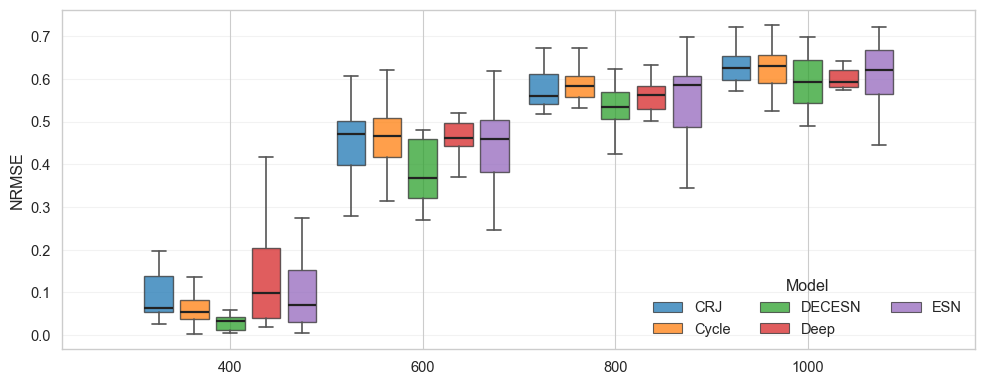

In [12]:
from matplotlib.patches import Patch

def build_nrmse_by_horizon_df(pred_store, DATA, horizons=(400,600,800,1000), exclude_models=None):
    """
    Build NRMSE rows for given horizons. Optionally exclude models by name.
    """
    exclude_models = set(exclude_models or [])
    rows = []
    for (model, init_id, split, rho, seed), preds in pred_store.items():
        if model in exclude_models:
            continue
        test_y = DATA[(init_id, split)]["test_y"]     # ORIGINAL test target
        nrmse = evaluate_nrmse(preds, test_y, list(horizons))
        for h in horizons:
            rows.append({
                "Model": model, "Horizon": h, "NRMSE": nrmse[h],
                "Init": init_id, "Split": split, "Rho": rho, "Seed": seed
            })
    return pd.DataFrame(rows)

# Build DF 
df_nrmse_h = build_nrmse_by_horizon_df(
    pred_store, DATA, horizons=(400,600,800,1000), exclude_models={"SW"}
)

# Order + palette
horizons = sorted(df_nrmse_h["Horizon"].unique())
models   = sorted(df_nrmse_h["Model"].unique())
pal      = sns.color_palette("tab10", n_colors=len(models))
color_of = {m: pal[i] for i, m in enumerate(models)}

# ======= manual grouped boxplot with small separation =======
fig, ax = plt.subplots(figsize=(10, 4))

centers    = np.arange(len(horizons))             # one group per horizon
group_width = 0.90                                 # total width reserved for the whole group
inner_gap   = 0.03                                 # small gap between adjacent boxes
M           = len(models)
box_w       = (group_width - inner_gap*(M-1)) / max(M, 1)  # width of each box
offsets     = np.linspace(-(group_width/2) + box_w/2,
                          +(group_width/2) - box_w/2, M)

# Collect data & positions
all_data, positions, colors = [], [], []
for gi, h in enumerate(horizons):
    center = centers[gi]
    for mi, m in enumerate(models):
        vals = df_nrmse_h.query("Horizon == @h and Model == @m")["NRMSE"].values
        all_data.append(vals)
        positions.append(center + offsets[mi])
        colors.append(color_of[m])

bp = ax.boxplot(
    all_data, positions=positions, widths=box_w*0.95,
    patch_artist=True, showcaps=True, showfliers=False,
    medianprops=dict(color="#222", linewidth=1.6),
    whiskerprops=dict(color="#555", linewidth=1.2),
    capprops=dict(color="#555", linewidth=1.2)
)

# Color boxes
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)
    patch.set_edgecolor("#333")
    patch.set_alpha(0.75)
    patch.set_linewidth(1.0)

# X ticks at group centers
ax.set_xticks(centers)
ax.set_xticklabels([str(h) for h in horizons])

# Legend
handles = [Patch(facecolor=color_of[m], edgecolor="#333", label=m, alpha=0.75) for m in models]
ax.legend(handles=handles, title="Model", ncol=3, frameon=False)

#ax.set_title(f"{SYSTEM.title()}: NRMSE distribution by horizon")
ax.set_xlabel("")
ax.set_ylabel("NRMSE")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.savefig(FIG_DIR / f"{SYSTEM}_box_nrmse_by_horizon.png", dpi=300, bbox_inches="tight")
plt.show()


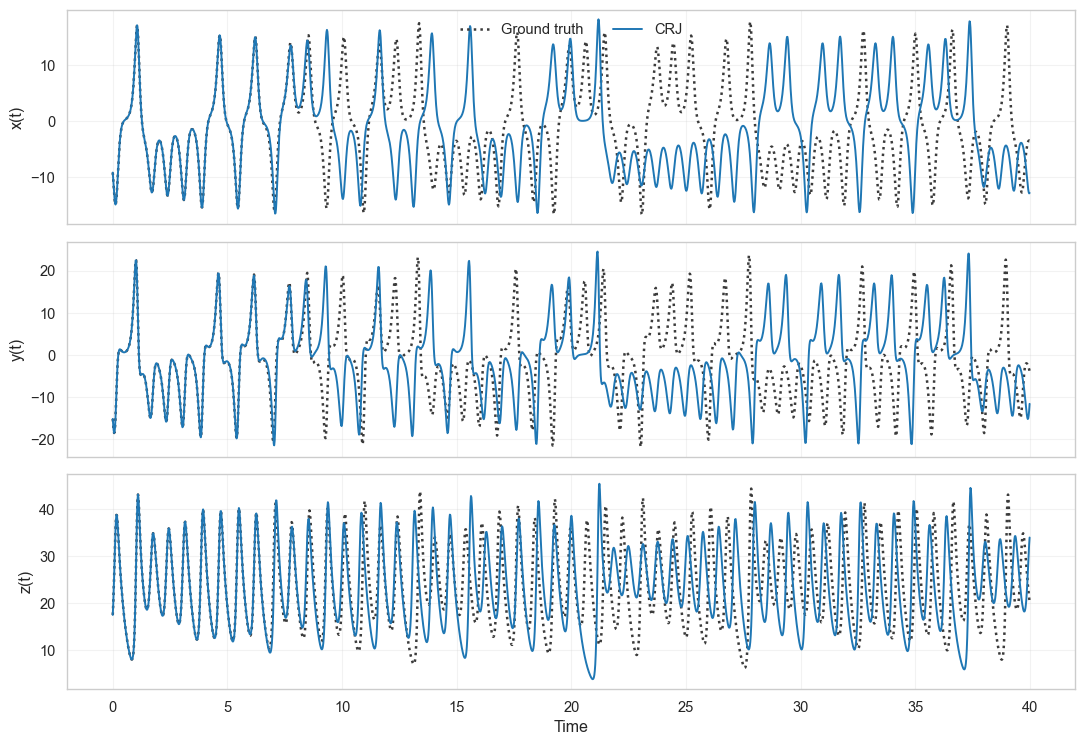

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_CRJ_init1_split0.8_rho0.95_seed1.png


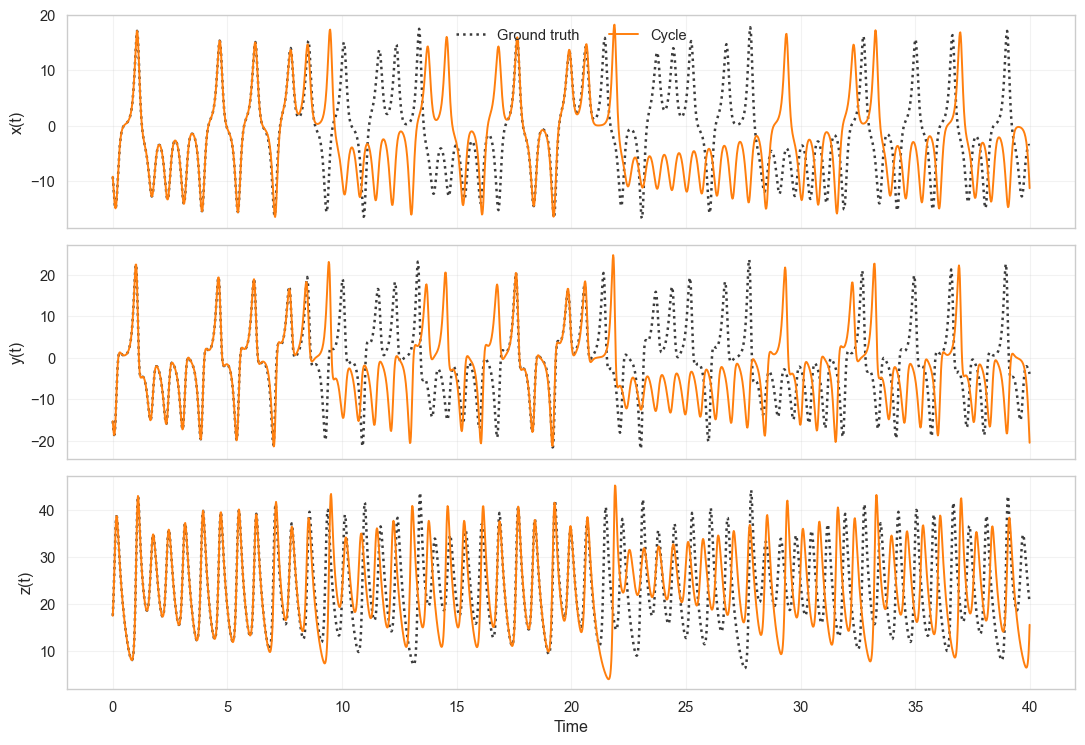

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_Cycle_init1_split0.8_rho0.95_seed1.png


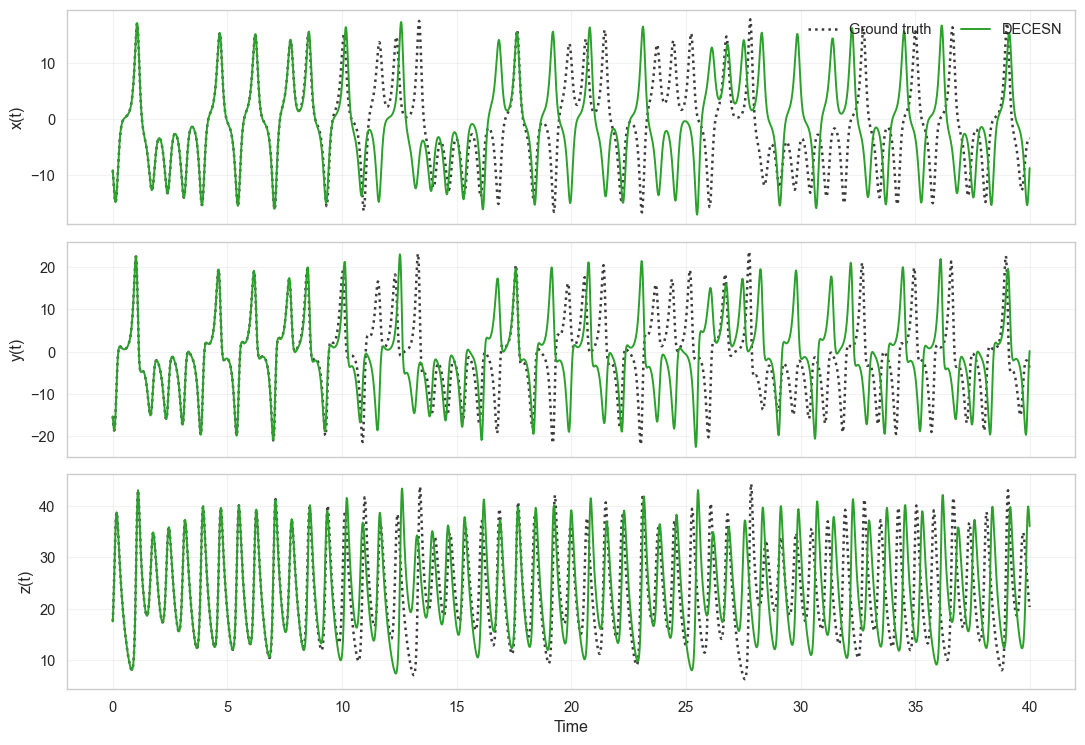

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_DECESN_init1_split0.8_rho0.95_seed1.png


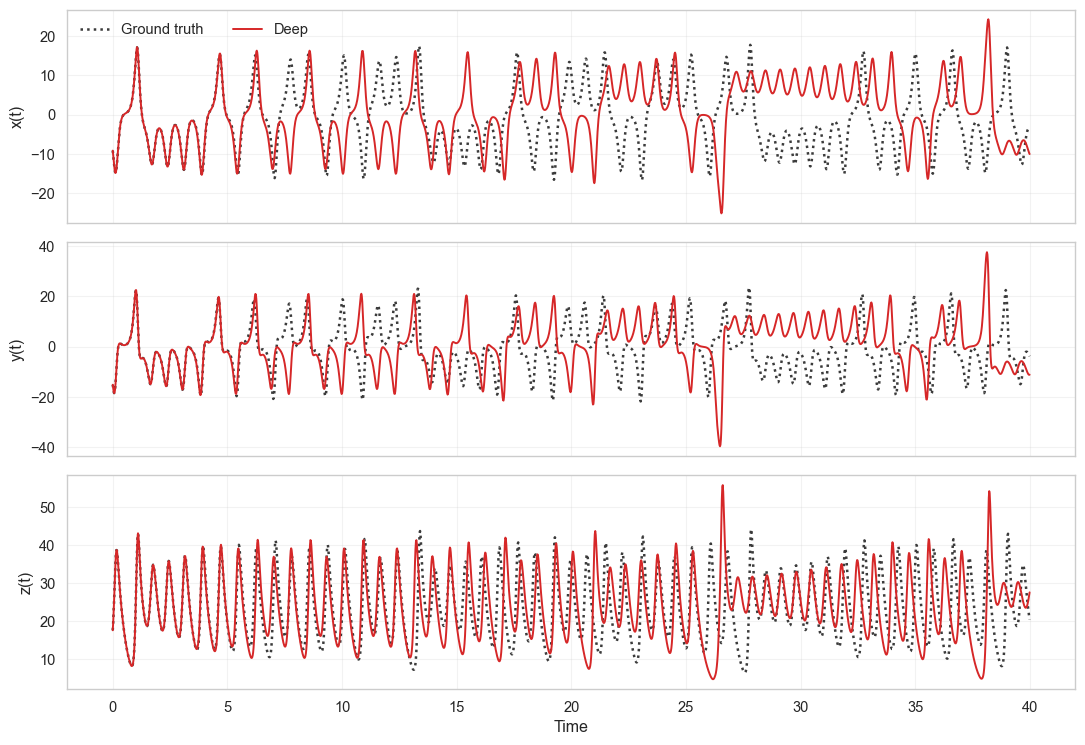

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_Deep_init1_split0.8_rho0.95_seed1.png


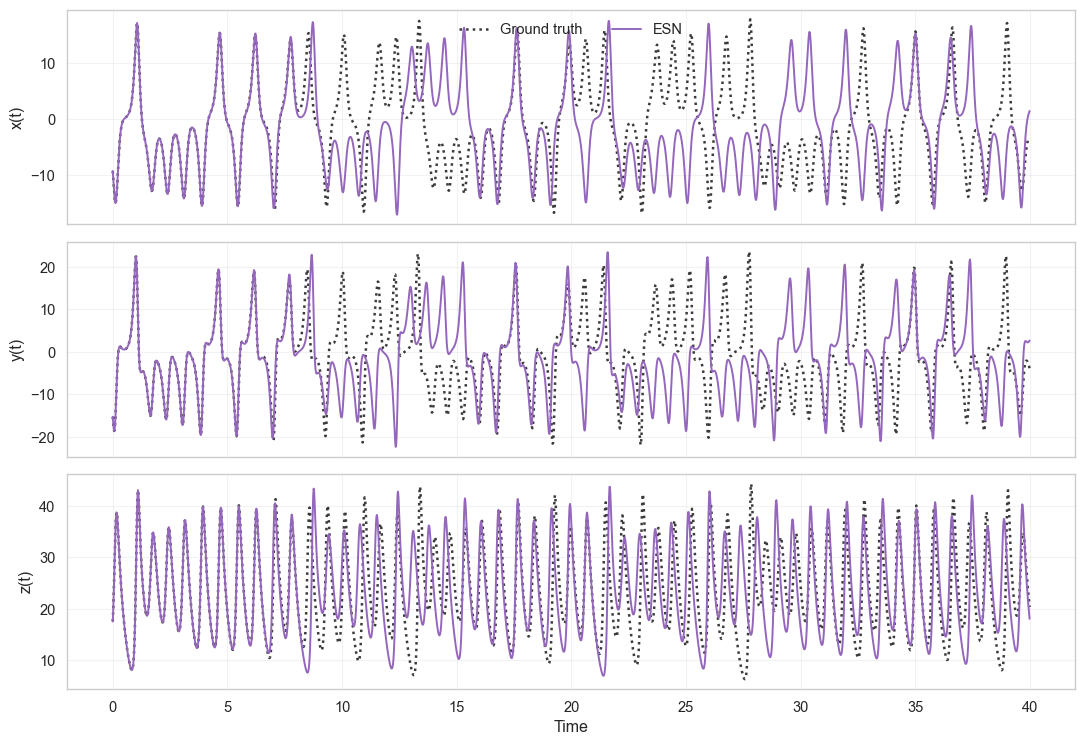

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_ESN_init1_split0.8_rho0.95_seed1.png


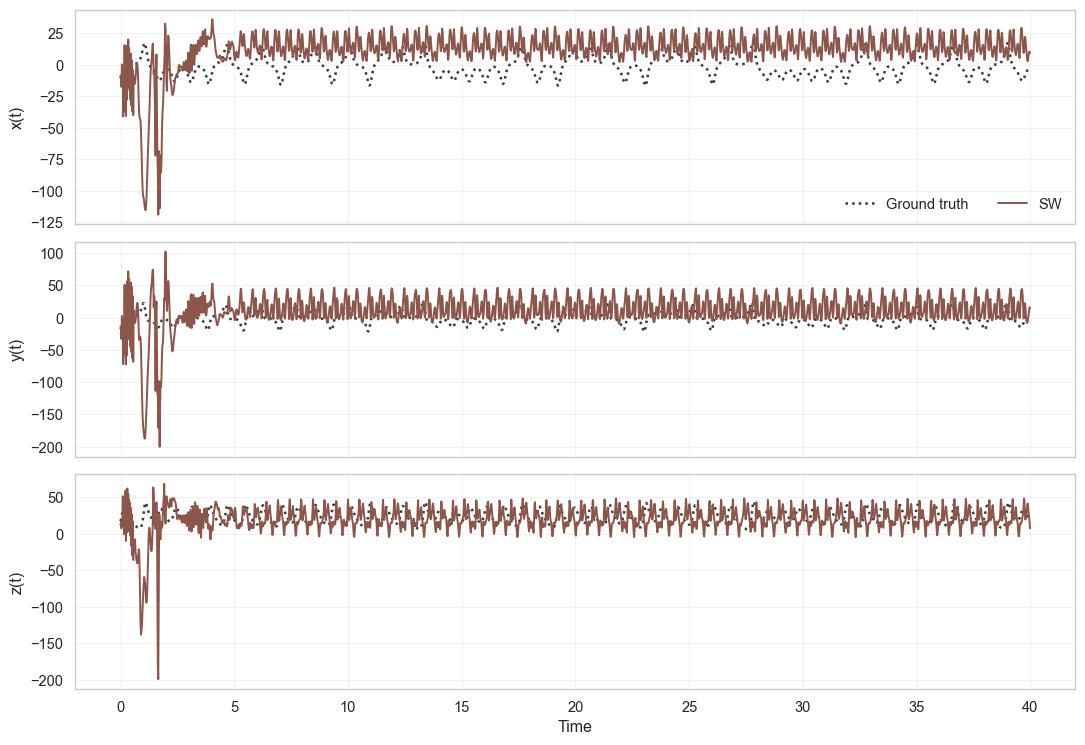

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\lorenz-overlay_SW_init1_split0.8_rho0.95_seed1.png


In [13]:
def plot_overlays_separate(pred_store, DATA, init_id, split, rho, seed,
                           palette=None, truth_color="#444444",
                           max_len=1500, dpi=300):
    """
    One figure per model: 3 stacked panels (x,y,z),
    model trajectory vs ORIGINAL ground truth (dotted).
    Uses DATA[(init_id, split)] to avoid recomputation.
    """
    # --- fetch original test trajectory from cache ---
    key_ds = (init_id, split)
    if key_ds not in DATA:
        raise KeyError(f"No DATA cache for (init_id={init_id}, split={split}).")
    time_test = DATA[key_ds]["time_test"]
    test_y    = DATA[key_ds]["test_y"]

    # truncation for display
    Ttruth = len(time_test)
    if max_len is not None:
        Ttruth   = min(Ttruth, max_len)
        time_plot = time_test[:Ttruth]
        y_plot    = test_y[:Ttruth]
    else:
        time_plot = time_test
        y_plot    = test_y

    # which models actually exist for this exact scenario?
    scenario_models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    if not scenario_models:
        raise ValueError(f"No predictions found for (init={init_id}, split={split}, ρ={rho}, seed={seed}).")

    # palette
    if palette is None:
        # build a stable palette just for the models in this scenario
        base = sns.color_palette("tab10", n_colors=max(10, len(scenario_models)))
        palette = {name: base[idx % len(base)] for idx, name in enumerate(scenario_models)}

    dim_names = ["x(t)", "y(t)", "z(t)"]

    for model in scenario_models:
        preds = pred_store[(model, init_id, split, rho, seed)]
        T = min(Ttruth, preds.shape[0])
        preds = preds[:T]

        fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
        for d, ax in enumerate(axes):
            # ground truth (dotted)
            ax.plot(time_plot[:T], y_plot[:T, d],
                    linestyle=":", lw=1.8, color=truth_color, label="Ground truth")
            # model
            ax.plot(time_plot[:T], preds[:, d],
                    lw=1.4, color=palette[model], label=model)
            ax.set_ylabel(dim_names[d])
            ax.grid(alpha=0.25)
            if d == 0:
                ax.legend(frameon=False, ncol=2)

        axes[-1].set_xlabel("Time")
        #plt.suptitle(f"{SYSTEM}{model} vs Ground Truth  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        out = FIG_DIR / f"{SYSTEM}-overlay_{model}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
        plt.savefig(out, dpi=dpi, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out}")

plot_overlays_separate(
    pred_store, DATA,
    init_id=1, split=0.8, rho=0.95, seed=1,
    truth_color="#3b3b3b", max_len=2000, dpi=300
)


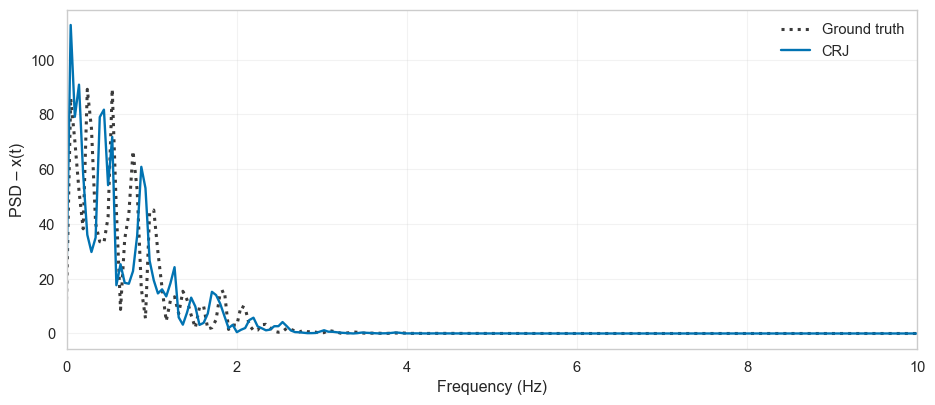

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_CRJ_dim-x_init1_split0.8_rho0.95_seed1.png


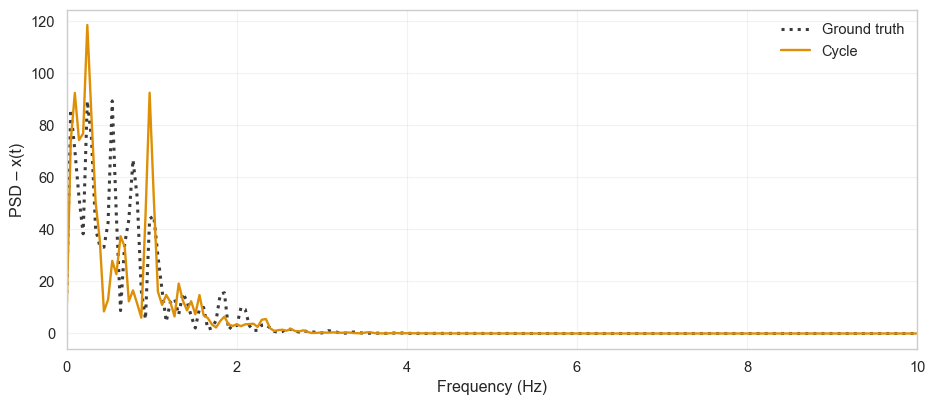

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_Cycle_dim-x_init1_split0.8_rho0.95_seed1.png


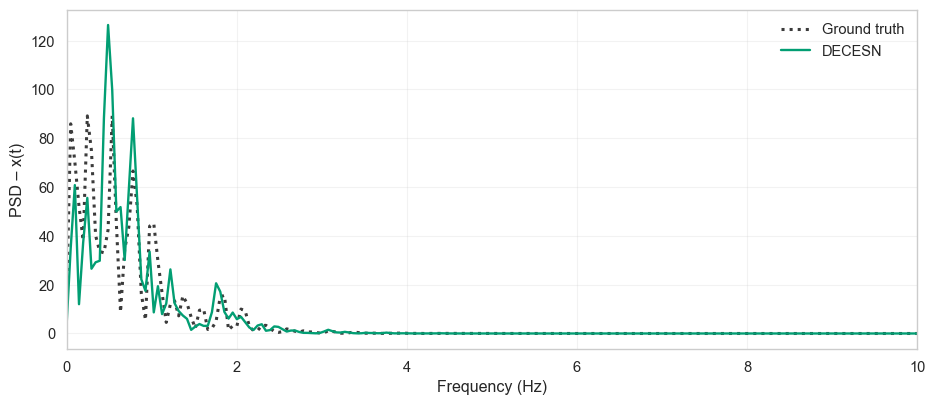

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_DECESN_dim-x_init1_split0.8_rho0.95_seed1.png


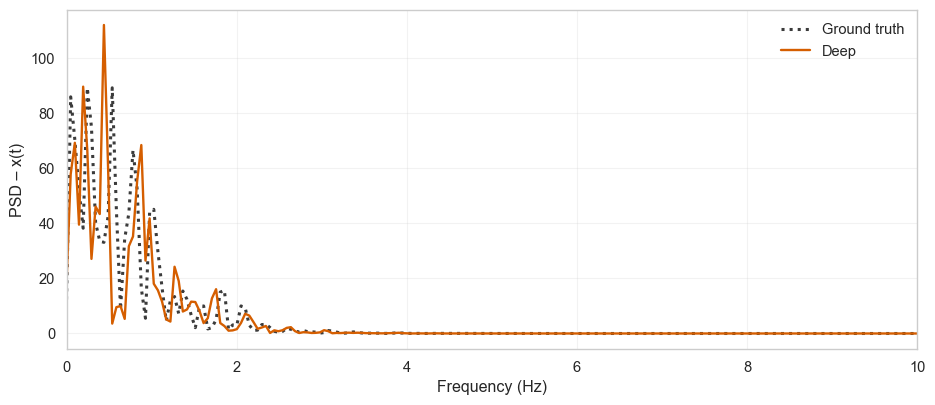

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_Deep_dim-x_init1_split0.8_rho0.95_seed1.png


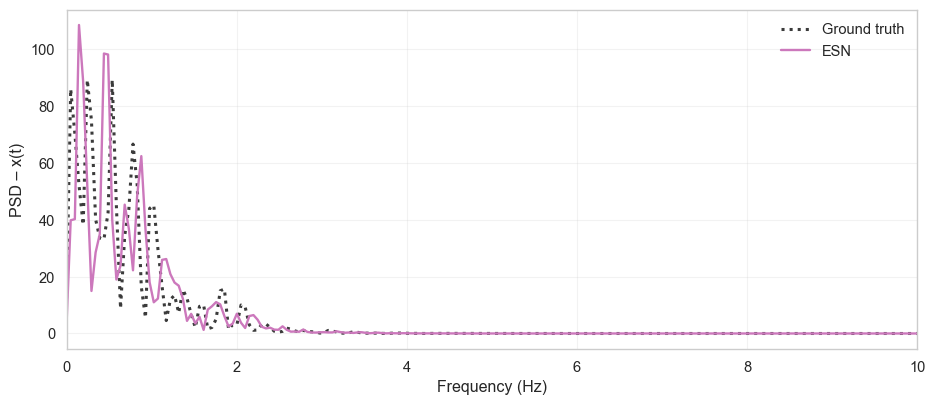

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_ESN_dim-x_init1_split0.8_rho0.95_seed1.png


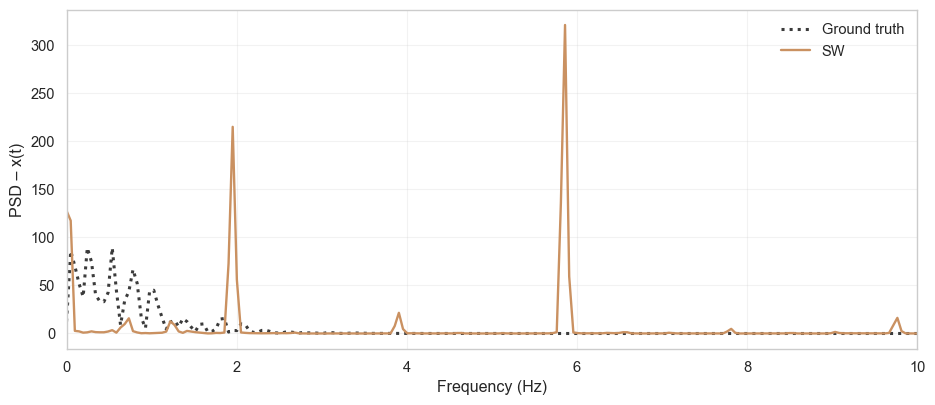

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\psd_lorenz_SW_dim-x_init1_split0.8_rho0.95_seed1.png


In [14]:
# --- deps ---

DIM_LABELS = ["x(t)", "y(t)", "z(t)"]
TRUTH_COLOR = "#3b3b3b"   # dotted charcoal for truth

def make_model_palette(pred_store, palette_name="colorblind"):
    models = sorted({k[0] for k in pred_store.keys()})
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

PALETTE = make_model_palette(pred_store)  # global fallback

# -----------------------------------------------------------------------------
# PSD — SEPARATE FIGURES for ALL MODELS (choose one component x/y/z)
# -----------------------------------------------------------------------------
def plot_psd_all_models_separate(pred_store, DATA, init_id, split, rho, seed,
                                 dim=0, max_len=None, nperseg=1024, noverlap=None,
                                 window="hann", detrend="constant", scaling="density",
                                 palette_name="colorblind",
                                 truth_color=TRUTH_COLOR, dpi=300):
    """
    For the given scenario (init_id, split, rho, seed), make one PSD figure per model
    on a single chosen component dim ∈ {0,1,2} (x/y/z), vs the ORIGINAL ground truth.
    """
    if dim not in (0, 1, 2):
        raise ValueError("dim must be 0 (x), 1 (y), or 2 (z).")

    # --- fetch truth & fs from cache ---
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init_id={init_id}, split={split}).")

    t       = DATA[ds_key]["time_test"]
    y_true  = DATA[ds_key]["test_y"]
    fs      = 1.0 / np.mean(np.diff(t))
    T       = len(t) if max_len is None else min(len(t), max_len)
    y_true  = y_true[:T]

    # models available for this exact scenario
    scenario_models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    if not scenario_models:
        raise ValueError(f"No predictions for (init={init_id}, split={split}, ρ={rho}, seed={seed}).")

    palette = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)

    # compute truth PSD once for the chosen component
    nperseg_eff = max(16, min(nperseg, T))
    f_t, P_t = signal.welch(y_true[:, dim], fs=fs, window=window,
                            nperseg=nperseg_eff, noverlap=noverlap,
                            detrend=detrend, scaling=scaling, return_onesided=True)

    comp_name = ["x", "y", "z"][dim]
    ylabel = f"PSD – {DIM_LABELS[dim]}"

    # --- one figure per model ---
    for m in scenario_models:
        preds = pred_store[(m, init_id, split, rho, seed)][:T]
        f_p, P_p = signal.welch(preds[:, dim], fs=fs, window=window,
                                nperseg=nperseg_eff, noverlap=noverlap,
                                detrend=detrend, scaling=scaling, return_onesided=True)

        plt.figure(figsize=(9.5, 4.2))
        # truth (dotted) + model
        plt.plot(f_t, P_t, linestyle=":", lw=2.2, color=truth_color, label="Ground truth")
        plt.plot(f_p, P_p, lw=1.7, color=palette.get(m, "C0"), label=m)

        plt.xlabel("Frequency (Hz)")
        plt.ylabel(ylabel)
        plt.xlim(0, 10)   # <-- limit frequency axis to 10 Hz
        plt.grid(alpha=0.25)
        plt.legend(frameon=False)
        #plt.title(f"PSD — {m} vs Truth | {DIM_LABELS[dim]}  •  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.tight_layout()

        safe_model = m.replace(" ", "").replace("/", "_")
        out = FIG_DIR / f"psd_{SYSTEM}_{safe_model}_dim-{comp_name}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
        plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
        print(f"Saved: {out}")

# All models, separate figures, PSD for x only
plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=0)

# For y (dim=1)
#plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=1)

# For z (dim=2), longer segment and larger nperseg
#plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=2, max_len=6000, nperseg=2048)



In [15]:
# =========================================================
# Time-series overlays with VPT (no truth recompute)
# =========================================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth

# --- System-specific λ_max defaults (fallback if auto fails) ---
LAMBDA_MODE = "auto"   # "auto" or "fixed"
LAMBDA_MAP  = {
    "lorenz":    0.90,
    "rossler":   0.07,     # typical for (a=0.2,b=0.2,c=5.7) with dt≈0.02
    "chen-ueta": 2.038,
}

def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# ------------------------------
# Rough λ_max (Rosenstein-style)
# ------------------------------
def estimate_lambda_max_rosenstein(y_true: np.ndarray, t: np.ndarray,
                                  theiler: int = 30, kmax: int = 60,
                                  n_samples: int = 500) -> float:
    """
    Very lightweight largest Lyapunov exponent estimate from a single trajectory.
    y_true: (T, d) trajectory; t: time vector. Returns λ_max in 1/seconds.
    """
    T, d = y_true.shape
    if T < theiler + kmax + 2:
        raise ValueError("Time series too short for λ_max estimation")

    # nearest neighbors with exclusion window
    nbrs = NearestNeighbors(n_neighbors=10, algorithm="auto").fit(y_true)
    # sample candidate anchors away from ends
    rng = np.random.default_rng(0)
    anchors = rng.integers(low=theiler+1, high=T-kmax-1, size=min(n_samples, T - (theiler+kmax+2)))

    dt = float(np.mean(np.diff(t)))
    logs = []

    for i in anchors:
        # find a neighbor not within Theiler window
        dists, idxs = nbrs.kneighbors(y_true[i:i+1], return_distance=True)
        j = None
        for cand in idxs[0]:
            if abs(cand - i) > theiler:
                j = cand
                break
        if j is None:
            continue

        # separation growth
        seq = []
        for k in range(1, kmax+1):
            if i+k >= T or j+k >= T:
                break
            d_k = np.linalg.norm(y_true[i+k] - y_true[j+k])
            if d_k <= 0:
                continue
            seq.append(np.log(d_k))
        if len(seq) >= 8:
            logs.append(seq)

    if not logs:
        raise RuntimeError("Failed to collect separations for λ_max estimation")

    # pad to same length (use min length across collected sequences)
    L = min(len(s) for s in logs)
    M = np.stack([s[:L] for s in logs], axis=0)  # (N, L)
    y = M.mean(axis=0)                           # ⟨log d(k)⟩
    x = np.arange(1, L+1) * dt                   # time in seconds

    # fit only early linear region (first 1/3 or up to ~0.5s)
    cutoff = max(10, min(L//3, int(0.5/dt)))
    if cutoff < 6: cutoff = min(L, 10)
    coef = np.polyfit(x[:cutoff], y[:cutoff], 1)  # slope ≈ λ_max
    lam = float(coef[0])
    return max(lam, 1e-6)

def get_lambda_max(system: str, y_true: np.ndarray, t: np.ndarray) -> float:
    """Select λ_max based on LAMBDA_MODE & map; auto falls back to map."""
    sys_key = (system or "lorenz").lower()
    if LAMBDA_MODE.lower() == "fixed":
        return float(LAMBDA_MAP.get(sys_key, 0.9))
    # auto
    try:
        return estimate_lambda_max_rosenstein(y_true, t)
    except Exception:
        return float(LAMBDA_MAP.get(sys_key, 0.9))

# ---------------------------------------------------------
# Main plotter (uses DATA cache for ORIGINAL truth only)
# ---------------------------------------------------------
def plot_timeseries_with_vpt_per_model(pred_store, DATA, model,
                                       init_id, split, rho, seed,
                                       system="lorenz",
                                       threshold=0.4,
                                       lambda_mode=None,   # override global if not None
                                       max_len=None, dpi=300,
                                       palette_name="colorblind",
                                       truth_color=TRUTH_COLOR):
    """
    One figure per (model, scenario): 3 stacked panels (x,y,z).
    Uses DATA[(init_id, split)] to fetch ORIGINAL test trajectory.
    Draws VPT vertical line based on (threshold, λ_max).
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    t        = DATA[ds_key]["time_test"]
    y_true   = DATA[ds_key]["test_y"]
    key      = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred   = pred_store[key]

    # Align lengths
    T = min(len(t), len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    # λ_max selection
    mode = (lambda_mode or LAMBDA_MODE).lower()
    lam  = get_lambda_max(system, y_true, t) if mode == "auto" else float(LAMBDA_MAP.get(system.lower(), 0.9))

    # Compute VPT
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        y_true, y_pred, t, threshold=threshold, lambda_max=lam
    )
    vline_x = np.clip(T_VPT, t[0], t[-1])

    # palette per scenario so color is consistent across figures
    scenario_palette = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = scenario_palette.get(model, "C0")

    # Plot
    dim_names = ["x(t)", "y(t)", "z(t)"]
    fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
    for d, ax in enumerate(axes):
        ax.plot(t, y_true[:, d], linestyle=":", color=truth_color, lw=1.9, label="Ground truth")
        ax.plot(t, y_pred[:, d], color=color_model, lw=1.5, label=model)
        ax.axvline(vline_x, color="crimson", ls="--", lw=1.2,
                   label=(f"VPT={T_VPT:.2f}s" if d == 0 else None))
        ax.set_ylabel(dim_names[d]); ax.grid(alpha=0.25)
        if d == 0:
            ax.legend(ncol=3, frameon=False)
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle(f"{model}: Trajectory vs Truth  |  init={init_id}, split={split}, ρ={rho}, seed={seed}  •  "
                 f"λ_max=({mode}) {lam:.3g}, threshold={threshold}")
    plt.tight_layout(rect=[0,0,1,0.95])

    out = FIG_DIR / f"{system}_ts_vpt_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

'''plot_timeseries_with_vpt_per_model(
    pred_store, DATA,
    model="ESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    system=SYSTEM,          # e.g., "lorenz" | "rossler" | "chen-ueta"
    threshold=0.4,
    lambda_mode="auto",     # or "fixed"
    max_len=2000, dpi=300
)
'''

'plot_timeseries_with_vpt_per_model(\n    pred_store, DATA,\n    model="ESN",\n    init_id=1, split=0.8, rho=0.95, seed=1,\n    system=SYSTEM,          # e.g., "lorenz" | "rossler" | "chen-ueta"\n    threshold=0.4,\n    lambda_mode="auto",     # or "fixed"\n    max_len=2000, dpi=300\n)\n'

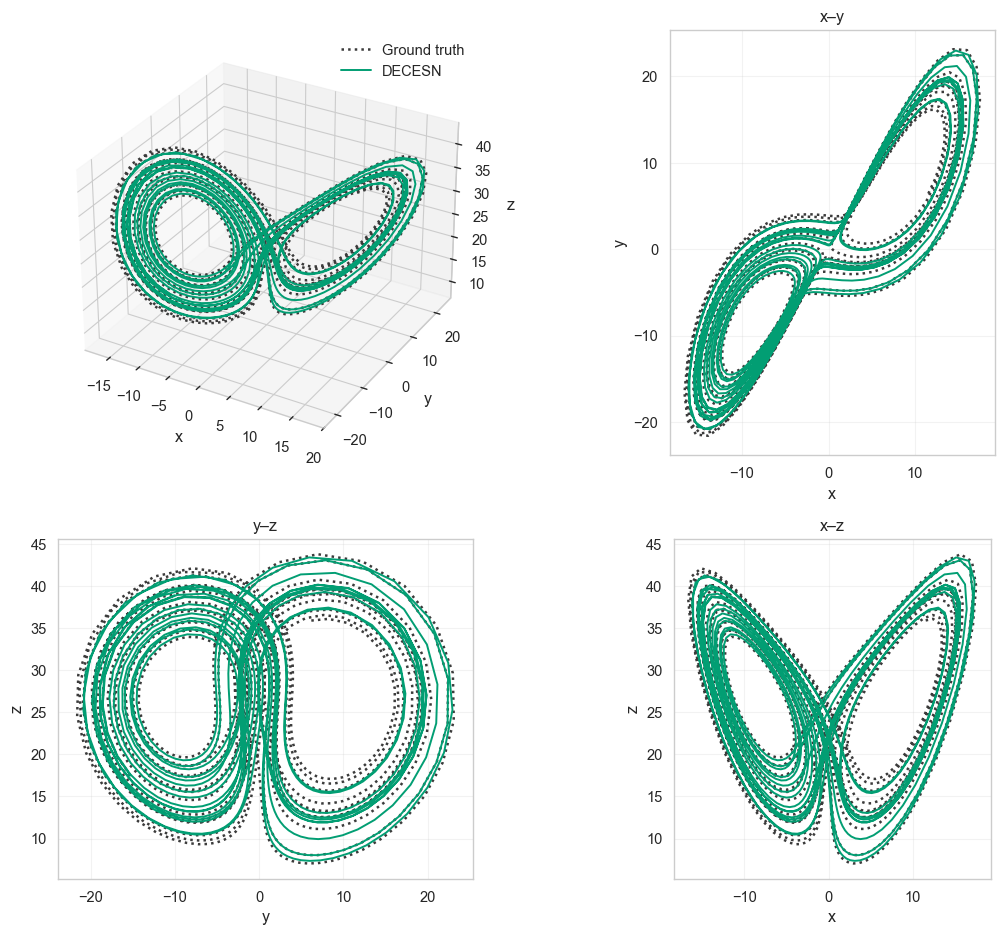

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\phase_DECESN_init1_split0.8_rho0.95_seed1.png


In [16]:
# ============================================
# Phase-space overlay (per model) — no re-gen
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth


def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def plot_phase_space_overlay_per_model(pred_store, DATA, model,
                                       init_id, split, rho, seed,
                                       max_len=4000, dpi=300,
                                       truth_color=TRUTH_COLOR,
                                       palette_name="colorblind"):
    """
    One figure per model:
      • 3D Lorenz/Rössler/Chen-Ueta trajectory overlay (truth dotted)
      • 2D projections (x–y, y–z, x–z)
    Uses ORIGINAL test trajectory from DATA cache: DATA[(init_id, split)].
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    # Truth & preds (no recomputation)
    y_true = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred), max_len if max_len else len(y_true))
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # Colors
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = pal.get(model, "C0")

    # Layout: 2x2 (3D top-left, then XY, YZ, XZ projections)
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[2.0, 1.6])

    # 3D
    ax3d = fig.add_subplot(gs[0, 0], projection='3d')
    ax3d.plot(y_true[:,0], y_true[:,1], y_true[:,2], ls=":", lw=1.8, color=truth_color, label="Ground truth")
    ax3d.plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], lw=1.4, color=color_model, label=model)
    ax3d.set_xlabel("x"); ax3d.set_ylabel("y"); ax3d.set_zlabel("z")
    ax3d.legend(frameon=False)

    # XY
    ax_xy = fig.add_subplot(gs[0, 1])
    ax_xy.plot(y_true[:,0], y_true[:,1], ls=":", lw=1.8, color=truth_color)
    ax_xy.plot(y_pred[:,0], y_pred[:,1], lw=1.4, color=color_model)
    ax_xy.set_xlabel("x"); ax_xy.set_ylabel("y"); ax_xy.set_title("x–y")
    ax_xy.set_aspect("equal", adjustable="box"); ax_xy.grid(alpha=0.25)

    # YZ
    ax_yz = fig.add_subplot(gs[1, 0])
    ax_yz.plot(y_true[:,1], y_true[:,2], ls=":", lw=1.8, color=truth_color)
    ax_yz.plot(y_pred[:,1], y_pred[:,2], lw=1.4, color=color_model)
    ax_yz.set_xlabel("y"); ax_yz.set_ylabel("z"); ax_yz.set_title("y–z")
    ax_yz.set_aspect("equal", adjustable="box"); ax_yz.grid(alpha=0.25)

    # XZ
    ax_xz = fig.add_subplot(gs[1, 1])
    ax_xz.plot(y_true[:,0], y_true[:,2], ls=":", lw=1.8, color=truth_color)
    ax_xz.plot(y_pred[:,0], y_pred[:,2], lw=1.4, color=color_model)
    ax_xz.set_xlabel("x"); ax_xz.set_ylabel("z"); ax_xz.set_title("x–z")
    ax_xz.set_aspect("equal", adjustable="box"); ax_xz.grid(alpha=0.25)

    #plt.suptitle(f"{model}: Phase-space overlay  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.95])
    out = FIG_DIR / f"phase_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_phase_space_overlay_per_model(
    pred_store, DATA,
    model="DECESN", init_id=1, split=0.8, rho=0.95, seed=1,
    max_len=1000, dpi=300
)

In [17]:
# ============================================
# Poincaré section (per model) — no re-gen of truth
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth


def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def _plane_crossings_xyz(x, y, z, x0, direction="up"):
    """
    Return intersection points (y*, z*) where x(t) crosses plane x=x0.
    direction: "up" (below->above), "down" (above->below), or "both".
    """
    y_pts, z_pts = [], []
    for i in range(1, len(x)):
        x_prev, x_curr = x[i-1], x[i]
        # orientation filter
        if direction == "up" and not (x_prev < x0 <= x_curr):
            continue
        if direction == "down" and not (x_prev > x0 >= x_curr):
            continue
        if direction == "both" and not ((x_prev - x0) * (x_curr - x0) <= 0):
            continue
        denom = x_curr - x_prev
        if np.isclose(denom, 0.0):
            continue
        alpha = (x0 - x_prev) / denom  # linear interpolation weight
        y_cross = y[i-1] + alpha * (y[i] - y[i-1])
        z_cross = z[i-1] + alpha * (z[i] - z[i-1])
        y_pts.append(y_cross); z_pts.append(z_cross)
    return np.array(y_pts), np.array(z_pts)

def plot_poincaré_section_per_model(pred_store, DATA, model,
                                    init_id, split, rho, seed,
                                    plane_axis="x", plane_value=None,
                                    direction="up",
                                    max_len=4000, dpi=300,
                                    truth_color=TRUTH_COLOR,
                                    palette_name="colorblind"):
    """
    Poincaré section for one model vs truth using ORIGINAL test trajectory from DATA.
    plane_axis: {"x","y","z"}; section is axis = plane_value (defaults to mean of truth).
    direction : {"up","down","both"} for crossing orientation.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    # Truth & preds
    y_true = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred), max_len if max_len else len(y_true))
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # Choose section axis & default value
    ax_map = {"x": 0, "y": 1, "z": 2}
    if plane_axis not in ax_map:
        raise ValueError("plane_axis must be one of {'x','y','z'}")
    a = ax_map[plane_axis]

    if plane_value is None:
        plane_value = float(np.mean(y_true[:, a]))

    # Rotate coordinates so section is always along the first component
    # (re-use the existing x-plane crossing routine)
    def _reorder(arr):
        if a == 0:  # x-plane: (x,y,z)
            return arr[:,0], arr[:,1], arr[:,2]
        if a == 1:  # y-plane: (y,z,x) -> crossings return (z*, x*)
            return arr[:,1], arr[:,2], arr[:,0]
        else:       # z-plane: (z,x,y) -> crossings return (x*, y*)
            return arr[:,2], arr[:,0], arr[:,1]

    # Crossings
    xt, yt, zt = _reorder(y_true)
    xp, yp, zp = _reorder(y_pred)

    YT, ZT = _plane_crossings_xyz(xt, yt, zt, plane_value, direction=direction)
    YP, ZP = _plane_crossings_xyz(xp, yp, zp, plane_value, direction=direction)

    # Pretty axis labels after reordering
    pair_labels = {0: ("y", "z"), 1: ("z", "x"), 2: ("x", "y")}
    lab_y, lab_z = pair_labels[a]

    # Colors
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = pal.get(model, "C0")

    # Plot
    plt.figure(figsize=(7.2, 6.2))
    if len(YT) == 0 and len(YP) == 0:
        plt.text(0.5, 0.5,
                 f"No crossings found at {plane_axis}={plane_value:.2f} ({direction})",
                 ha="center", va="center")
        plt.axis("off")
    else:
        if len(YT) > 0:
            plt.scatter(YT, ZT, s=20, c=truth_color, alpha=0.75, marker="o", label="Ground truth")
        if len(YP) > 0:
            plt.scatter(YP, ZP, s=22, c=color_model, alpha=0.75, marker="x", label=model)
        plt.xlabel(f"{lab_y} at crossing"); plt.ylabel(f"{lab_z} at crossing")
        plt.title(f"Poincaré: {plane_axis}={plane_value:.2f} ({direction})\n"
                  f"{model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.legend(frameon=False)
        plt.grid(alpha=0.25)
        plt.gca().set_aspect("equal", adjustable="box")

    plt.tight_layout()
    out = FIG_DIR / f"poincare_{_safe_name(model)}_{plane_axis}{plane_value:.2f}_{direction}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# Default: section on mean(x_true), upward crossings
'''plot_poincaré_section_per_model(
    pred_store, DATA, "DECESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    plane_axis="x", direction="up"
)'''

# Specific plane & both directions on y=10.0
'''plot_poincaré_section_per_model(
    pred_store, DATA, "ESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    plane_axis="y", plane_value=10.0, direction="both"
)
'''

'plot_poincaré_section_per_model(\n    pred_store, DATA, "ESN",\n    init_id=1, split=0.8, rho=0.95, seed=1,\n    plane_axis="y", plane_value=10.0, direction="both"\n)\n'

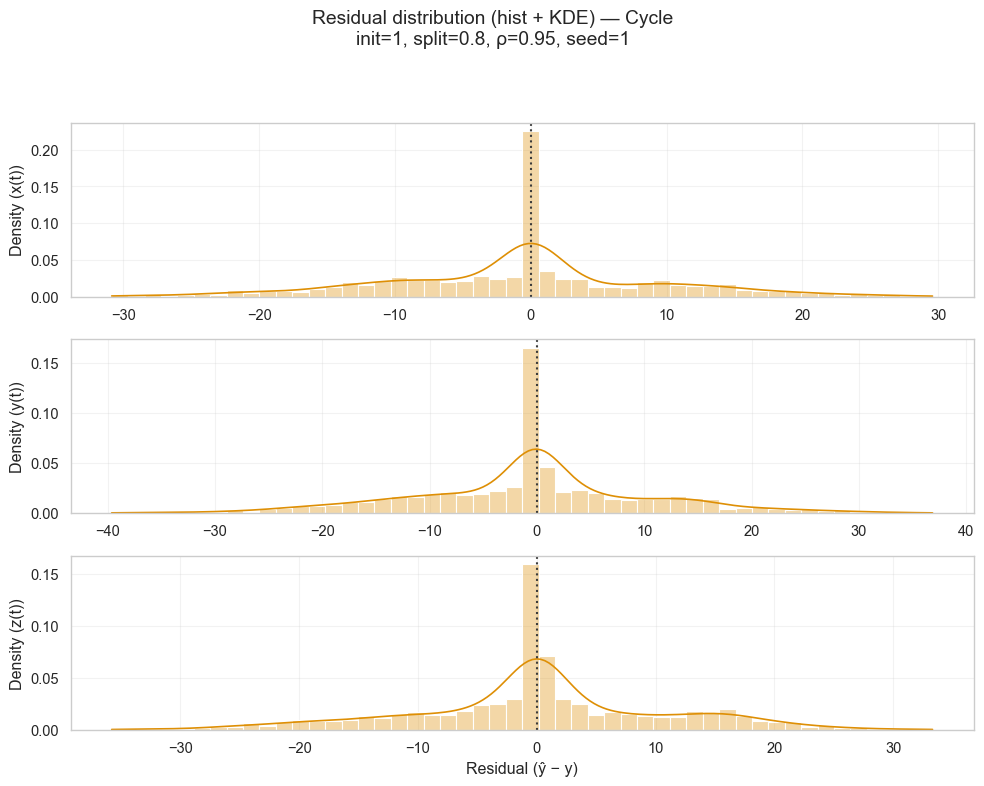

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\resid_hist_kde_Cycle_init1_split0.8_rho0.95_seed1.png


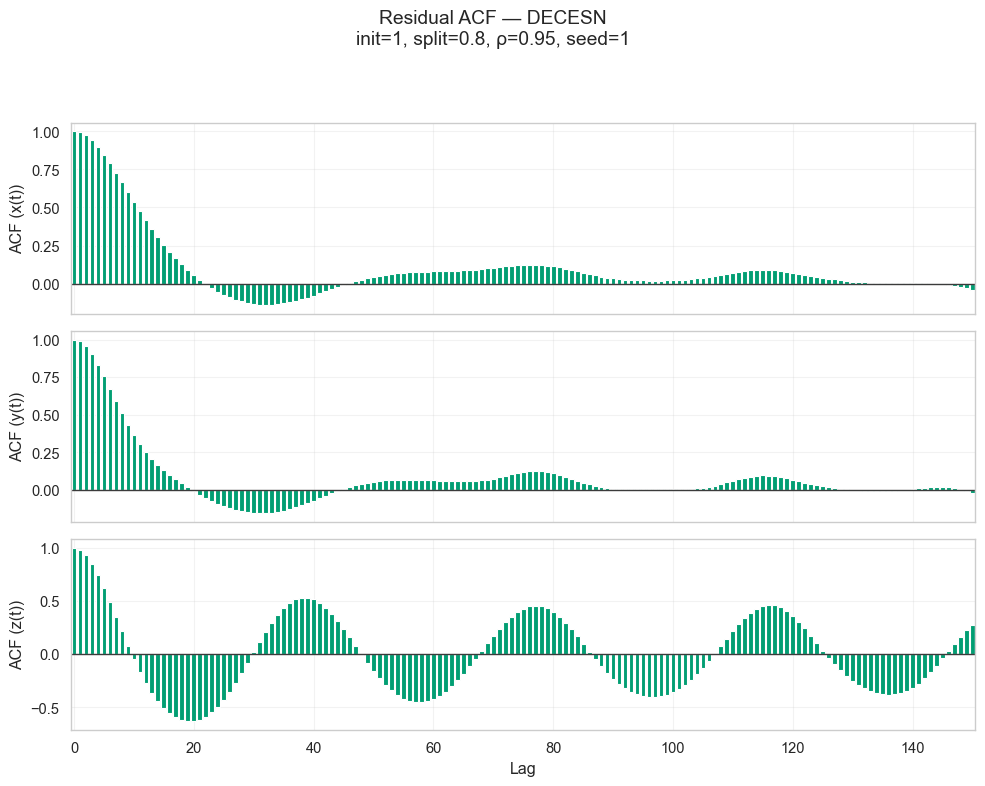

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\resid_acf_DECESN_init1_split0.8_rho0.95_seed1.png


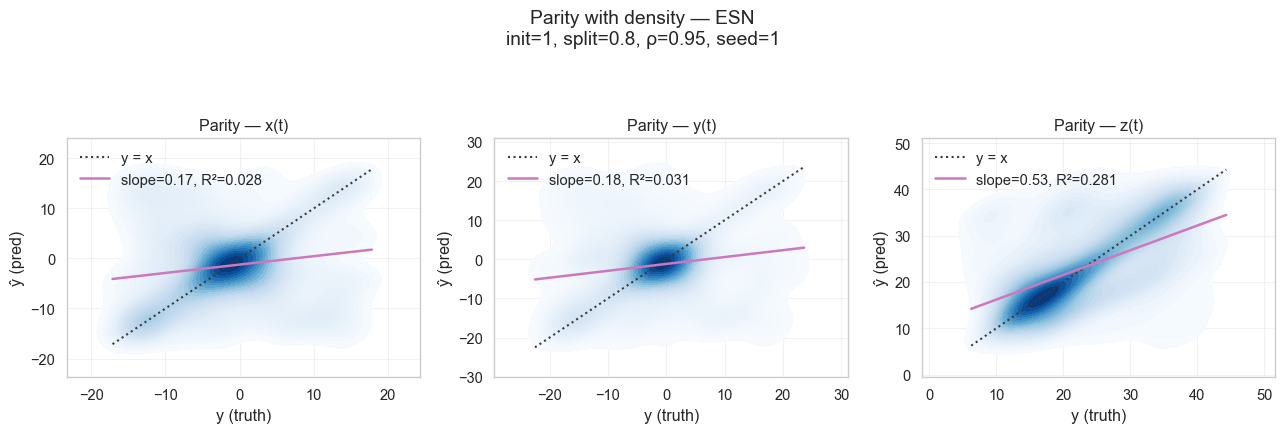

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\parity_density_ESN_init1_split0.8_rho0.95_seed1.png


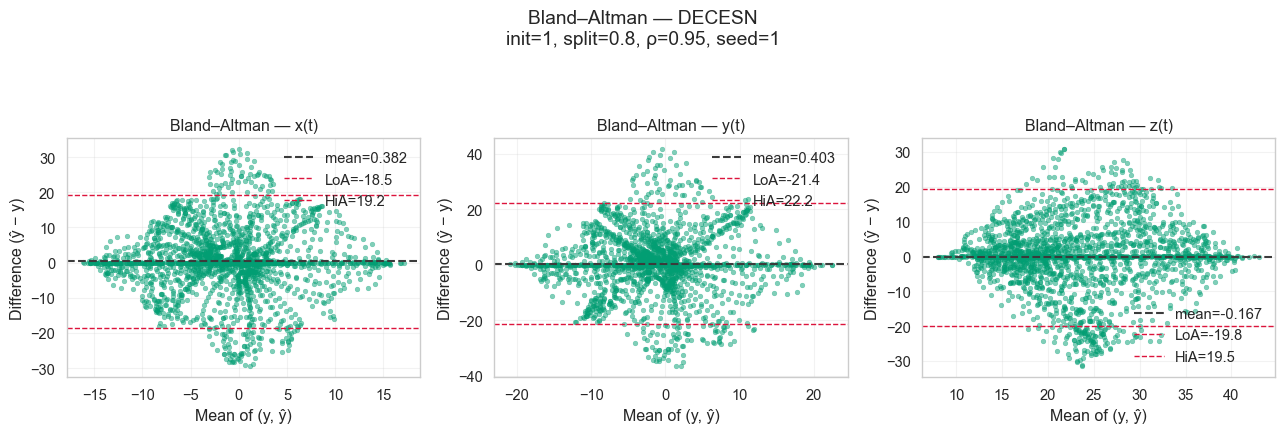

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\bland_altman_DECESN_init1_split0.8_rho0.95_seed1.png


In [18]:
# ============================ setup & helpers ============================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
TRUTH_COLOR = "#3b3b3b"



def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models present in this exact scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# Simple (biased) ACF up to nlags
def _acf(x, nlags=200):
    x = np.asarray(x, float)
    x = x - np.mean(x)
    n = len(x)
    if n == 0:
        return np.array([np.nan]*(nlags+1))
    denom = np.dot(x, x)
    if denom == 0:
        return np.array([0.0] + [0.0]*nlags)
    ac = [1.0]
    for k in range(1, nlags+1):
        num = np.dot(x[k:], x[:n-k])
        ac.append(num / denom)
    return np.array(ac)

# ============================ plots (DATA-driven) ============================

def plot_residual_hist_kde_per_model(pred_store, DATA, model,
                                     init_id, split, rho, seed,
                                     max_len=None, bins=50, dpi=300,
                                     palette_name="colorblind"):
    """
    Residual histogram + KDE (ŷ−y) per dimension, using ORIGINAL test_y from DATA.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true, y_pred = y_true[:T], y_pred[:T]
    resid = y_pred - y_true

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
    for d, ax in enumerate(axes):
        sns.histplot(resid[:, d], bins=bins, stat="density", kde=True,
                     color=color, alpha=0.35, edgecolor=None, ax=ax)
        ax.axvline(0.0, color=TRUTH_COLOR, ls=":", lw=1.5)
        ax.set_ylabel(f"Density ({dim_names[d]})")
        ax.grid(alpha=0.25)
    axes[-1].set_xlabel("Residual (ŷ − y)")
    plt.suptitle(f"Residual distribution (hist + KDE) — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.93])
    out = FIG_DIR / f"resid_hist_kde_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_residual_acf_per_model(pred_store, DATA, model,
                                init_id, split, rho, seed,
                                nlags=200, max_len=None, dpi=300,
                                palette_name="colorblind"):
    """
    Residual ACF per dimension using ORIGINAL test_y from DATA.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    resid = (y_pred - y_true)[:T]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for d, ax in enumerate(axes):
        r = _acf(resid[:, d], nlags=nlags)
        ax.bar(np.arange(len(r)), r, color=color, width=0.8)
        ax.axhline(0, color=TRUTH_COLOR, lw=1.0)
        ax.set_xlim(-0.5, nlags+0.5)
        ax.set_ylabel(f"ACF ({dim_names[d]})")
        ax.grid(alpha=0.25)
    axes[-1].set_xlabel("Lag")
    plt.suptitle(f"Residual ACF — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.93])
    out = FIG_DIR / f"resid_acf_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_parity_density_per_model(pred_store, DATA, model,
                                  init_id, split, rho, seed,
                                  max_points=20000, dpi=300,
                                  cmap="Blues", palette_name="colorblind"):
    """
    Parity plots (ŷ vs y) with density background (KDE) + slope & R² per dimension.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:T], y_pred[:T]

    # (optional) subsample for speed
    if T > max_points:
        idx = np.linspace(0, T-1, max_points).astype(int)
        y_true = y_true[idx]; y_pred = y_pred[idx]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4.4))
    for d, ax in enumerate(axes):
        # density background
        sns.kdeplot(x=y_true[:, d], y=y_pred[:, d], fill=True, levels=30,
                    cmap=cmap, thresh=0.02, ax=ax)
        # parity line
        lim = [min(y_true[:, d].min(), y_pred[:, d].min()),
               max(y_true[:, d].max(), y_pred[:, d].max())]
        ax.plot(lim, lim, ls=":", color=TRUTH_COLOR, lw=1.5, label="y = x")
        # fit slope & R²
        slope, intercept = np.polyfit(y_true[:, d], y_pred[:, d], 1)
        r = np.corrcoef(y_true[:, d], y_pred[:, d])[0,1]
        r2 = r*r
        ax.plot(lim, slope*np.array(lim) + intercept, color=color, lw=1.8,
                label=f"slope={slope:.2f}, R²={r2:.3f}")
        ax.set_xlabel("y (truth)"); ax.set_ylabel("ŷ (pred)")
        ax.set_title(f"Parity — {dim_names[d]}")
        ax.legend(frameon=False); ax.grid(alpha=0.25)

    plt.suptitle(f"Parity with density — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.90])
    out = FIG_DIR / f"parity_density_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_bland_altman_per_model(pred_store, DATA, model,
                                init_id, split, rho, seed,
                                max_len=None, dpi=300,
                                palette_name="colorblind"):
    """
    Bland–Altman plots (mean vs difference) per dimension.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true, y_pred = y_true[:T], y_pred[:T]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4.4))
    for d, ax in enumerate(axes):
        mean_vals = 0.5 * (y_true[:, d] + y_pred[:, d])
        diff_vals = y_pred[:, d] - y_true[:, d]
        md = np.mean(diff_vals)
        sd = np.std(diff_vals, ddof=1)
        loa_low, loa_high = md - 1.96*sd, md + 1.96*sd

        sns.scatterplot(x=mean_vals, y=diff_vals, s=12, alpha=0.5, color=color, edgecolor=None, ax=ax)
        ax.axhline(md, color=TRUTH_COLOR, lw=1.5, ls="--", label=f"mean={md:.3g}")
        ax.axhline(loa_low, color="crimson", lw=1.0, ls="--", label=f"LoA={loa_low:.3g}")
        ax.axhline(loa_high, color="crimson", lw=1.0, ls="--", label=f"HiA={loa_high:.3g}")

        ax.set_xlabel("Mean of (y, ŷ)")
        ax.set_ylabel("Difference (ŷ − y)")
        ax.set_title(f"Bland–Altman — {dim_names[d]}")
        ax.grid(alpha=0.25); ax.legend(frameon=False)

    plt.suptitle(f"Bland–Altman — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.90])
    out = FIG_DIR / f"bland_altman_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")

# Residual distribution
plot_residual_hist_kde_per_model(pred_store, DATA, "Cycle",
                                 init_id=1, split=0.8, rho=0.95, seed=1)

# Residual ACF
plot_residual_acf_per_model(pred_store, DATA, "DECESN",
                            init_id=1, split=0.8, rho=0.95, seed=1, nlags=150)

# Parity with density
plot_parity_density_per_model(pred_store, DATA, "ESN",
                              init_id=1, split=0.8, rho=0.95, seed=1)

# Bland–Altman
plot_bland_altman_per_model(pred_store, DATA, "DECESN",
                            init_id=1, split=0.8, rho=0.95, seed=1)


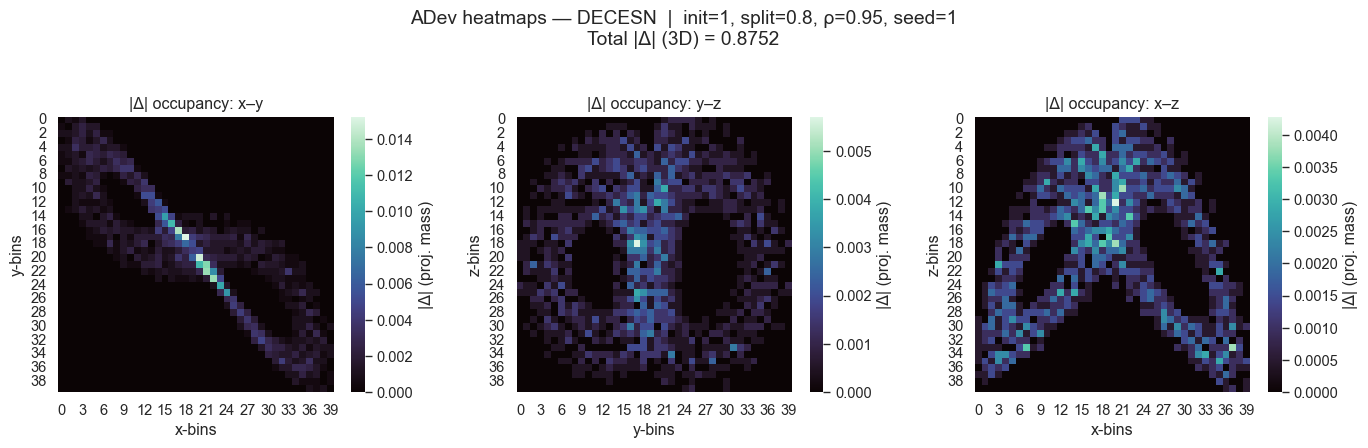

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\adev_heatmaps_DECESN_init1_split0.8_rho0.95_seed1.png


In [19]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
TRUTH_COLOR = "#3b3b3b"



def plot_adev_heatmaps_per_model(pred_store, DATA, model,
                                 init_id, split, rho, seed,
                                 bins=(40,40,40),     # (nx, ny, nz)
                                 max_len=None, norm=True,
                                 cmap="mako", dpi=300,
                                 vmin=0.0, vmax=None):
    """
    ADev heatmaps (|Δ occupancy|) projected onto XY, YZ, XZ planes.

    - Uses ORIGINAL test_y from DATA[(init_id, split)] (no recomputation).
    - If `norm=True`, each 3D histogram is normalized to probability mass
      before the absolute difference is taken.
    - `vmin/vmax` let you fix a shared color scale across multiple calls.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true = y_true[:T]
    y_pred = y_pred[:T]

    # Shared bin ranges for fairness
    mins = np.minimum(y_true.min(axis=0), y_pred.min(axis=0))
    maxs = np.maximum(y_true.max(axis=0), y_pred.max(axis=0))
    ranges = [(mins[0], maxs[0]), (mins[1], maxs[1]), (mins[2], maxs[2])]

    # 3D histograms (occupancies)
    H_true, edges = np.histogramdd(y_true, bins=bins, range=ranges)
    H_pred, _     = np.histogramdd(y_pred, bins=bins, range=ranges)

    if norm:
        s_true = H_true.sum()
        s_pred = H_pred.sum()
        if s_true > 0: H_true = H_true / s_true
        if s_pred > 0: H_pred = H_pred / s_pred

    Delta = np.abs(H_true - H_pred)          # (nx, ny, nz)
    delta_sum = float(Delta.sum())

    # 2D projections (sum over remaining axis)
    delta_xy = Delta.sum(axis=2)  # (nx, ny)
    delta_yz = Delta.sum(axis=0)  # (ny, nz)
    delta_xz = Delta.sum(axis=1)  # (nx, nz)

    # Plot heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))
    # XY
    sns.heatmap(delta_xy.T, ax=axes[0], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[0].set_title("|Δ| occupancy: x–y")
    axes[0].set_xlabel("x-bins"); axes[0].set_ylabel("y-bins")

    # YZ
    sns.heatmap(delta_yz.T, ax=axes[1], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[1].set_title("|Δ| occupancy: y–z")
    axes[1].set_xlabel("y-bins"); axes[1].set_ylabel("z-bins")

    # XZ
    sns.heatmap(delta_xz.T, ax=axes[2], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[2].set_title("|Δ| occupancy: x–z")
    axes[2].set_xlabel("x-bins"); axes[2].set_ylabel("z-bins")

    plt.suptitle(
        f"ADev heatmaps — {model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}\n"
        f"Total |Δ| (3D) = {delta_sum:.4f}"
    )
    plt.tight_layout(rect=[0,0,1,0.90])

    out = FIG_DIR / f"adev_heatmaps_{model.replace(' ','').replace('/','_')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_adev_heatmaps_per_model(
    pred_store, DATA, "DECESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    bins=(40,40,40), max_len=4000
)


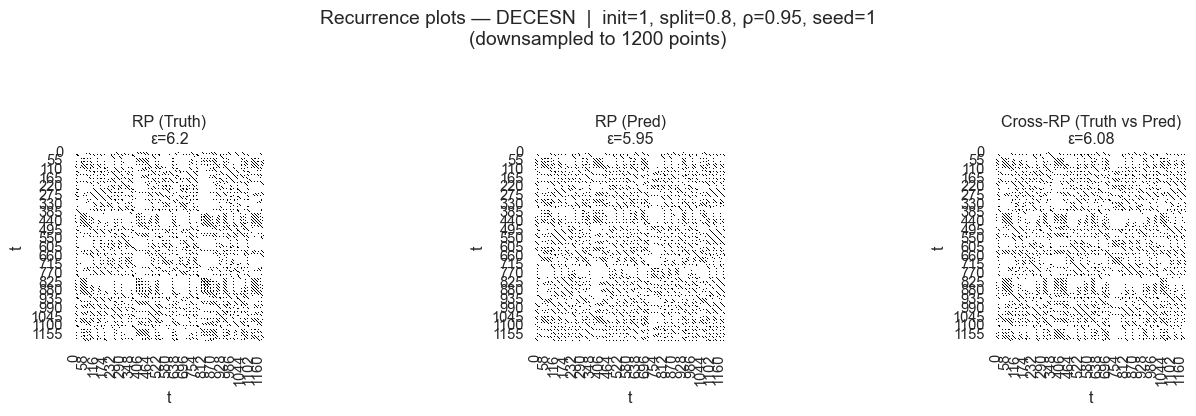

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\rp_DECESN_init1_split0.8_rho0.95_seed1.png


In [20]:
# ================== Recurrence plots (RP / Cross-RP) ==================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)



TRUTH_COLOR = "#3b3b3b"

def _downsample_idx(n, max_points=1500):
    if n <= max_points:
        return np.arange(n, dtype=int)
    return np.linspace(0, n-1, max_points).astype(int)

def _rp_binary(X, eps=None, quantile=0.1, metric="euclidean"):
    """
    Binary recurrence plot: R_ij = 1[dist(X[i], X[j]) <= eps].
    If eps is None, set eps to the `quantile` of pairwise distances.
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]
    if len(X) < 2:
        return np.ones((len(X), len(X))), 0.0

    dvec = pdist(X, metric=metric)                 # condensed
    D = squareform(dvec)                           # (T, T)
    if eps is None:
        eps = float(np.quantile(dvec, quantile)) if dvec.size else 0.0
    R = (D <= eps).astype(float)
    return R, eps

def _cross_rp_binary(X, Y, eps=None, quantile=0.1, metric="euclidean"):
    """
    Binary cross-recurrence: CR_ij = 1[dist(X[i], Y[j]) <= eps].
    If eps is None, set eps from cross-distance quantile.
    """
    X = np.asarray(X); Y = np.asarray(Y)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    if len(X) == 0 or len(Y) == 0:
        return np.zeros((len(X), len(Y))), 0.0

    D = cdist(X, Y, metric=metric)                 # (Tx, Ty)
    if eps is None:
        eps = float(np.quantile(D, quantile)) if D.size else 0.0
    CR = (D <= eps).astype(float)
    return CR, eps

def plot_recurrence_plots_per_model(pred_store, DATA, model,
                                    init_id, split, rho, seed,
                                    max_points=1200, metric="euclidean",
                                    q_truth=0.1, q_pred=0.1, q_cross=0.1,
                                    cmap="Greys", dpi=300):
    """
    Three panels: RP(true), RP(pred), Cross-RP(true vs pred).
    Uses ORIGINAL test target from DATA[(init_id, split)].
    Downsamples to <= max_points for O(n^2) feasibility.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    y_true_full = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred_full = pred_store[key]

    # Align & downsample
    T = min(len(y_true_full), len(y_pred_full))
    idx = _downsample_idx(T, max_points=max_points)
    y_true = y_true_full[:T][idx]
    y_pred = y_pred_full[:T][idx]

    # Build RPs
    R_true,  eps_t  = _rp_binary(y_true, eps=None, quantile=q_truth, metric=metric)
    R_pred,  eps_p  = _rp_binary(y_pred, eps=None, quantile=q_pred,  metric=metric)
    CR,      eps_cp = _cross_rp_binary(y_true, y_pred, eps=None, quantile=q_cross, metric=metric)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))
    for ax, M, ttl in [
        (axes[0], R_true, f"RP (Truth)\nε={eps_t:.3g}"),
        (axes[1], R_pred, f"RP (Pred)\nε={eps_p:.3g}"),
        (axes[2], CR,     f"Cross-RP (Truth vs Pred)\nε={eps_cp:.3g}"),
    ]:
        sns.heatmap(M, ax=ax, cmap=cmap, cbar=False, square=True)
        ax.set_title(ttl)
        ax.set_xlabel("t"); ax.set_ylabel("t")

    plt.suptitle(
        f"Recurrence plots — {model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}\n"
        f"(downsampled to {len(idx)} points)"
    )
    plt.tight_layout(rect=[0,0,1,0.90])

    out = FIG_DIR / f"rp_{model.replace(' ','').replace('/','_')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")


# ADev heatmaps 
'''plot_adev_heatmaps_per_model(
    pred_store, DATA, "Cycle",
    init_id=1, split=0.8, rho=0.95, seed=1,
    bins=(40,40,40), max_len=4000
)'''

# Recurrence plots (truth RP, pred RP, cross-RP)
plot_recurrence_plots_per_model(
    pred_store, DATA, "DECESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    max_points=1200, metric="euclidean",
    q_truth=0.1, q_pred=0.1, q_cross=0.1
)


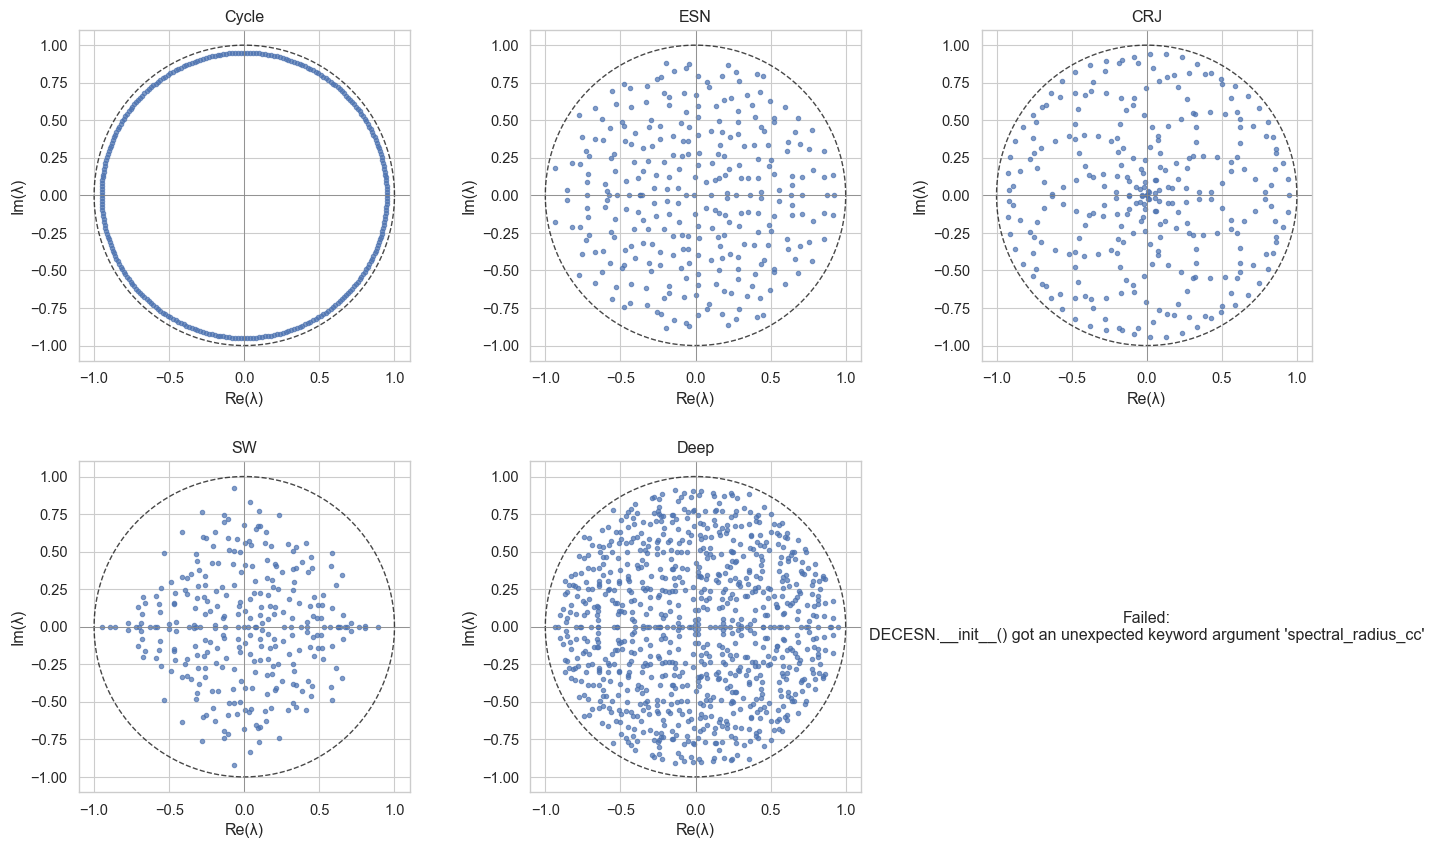

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\eigenspectrum_grid_rho0.95_seed1.png


In [21]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def _safe(s): return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try to fetch the reservoir recurrent matrix from common attribute names.
    Returns a dense ndarray or raises.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=0,
                              add_hist=True, ncols=3, dpi=300):
    """
    One panel per model: eigenvalues in C, with unit circle. Optionally add a
    small radial histogram of |λ|.
    """
    factories = dict(BASELINES)  # copy
    if TESTING_RES_CLASS is not None:
        #factories["Testing"] = lambda r, s: TESTING_RES_CLASS(spectral_radius=r, seed=s)
        factories[TESTING_NAME] = lambda r, s: TESTING_RES_CLASS(spectral_radius_cc=r, seed=s)


    names = list(factories.keys())
    n = len(names)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 4.4*nrows))
    axes = np.atleast_2d(axes)

    theta = np.linspace(0, 2*np.pi, 512)
    unit = np.exp(1j*theta)

    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed:\n{e}", ha="center", va="center")
            ax.axis("off"); continue

        ax.scatter(eig.real, eig.imag, s=10, alpha=0.7)
        ax.plot(unit.real, unit.imag, "k--", lw=1.0, alpha=0.8)
        ax.axhline(0, color="#888", lw=0.6); ax.axvline(0, color="#888", lw=0.6)
        ax.set_title(name)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")
        ax.set_aspect("equal", adjustable="box")

        if not add_hist: # histogram is unnecessary
            inset = ax.inset_axes([0.65, 0.65, 0.32, 0.32])
            inset.hist(np.abs(eig), bins=30, density=True, alpha=0.8)
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_title("|λ|", fontsize=9)
            inset.set_yticks([])

    # hide unused axes
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    #plt.suptitle(f"Eigen-spectrum (ρ={rho}, seed={seed})", y=1.02)
    plt.tight_layout()
    out = FIG_DIR / f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


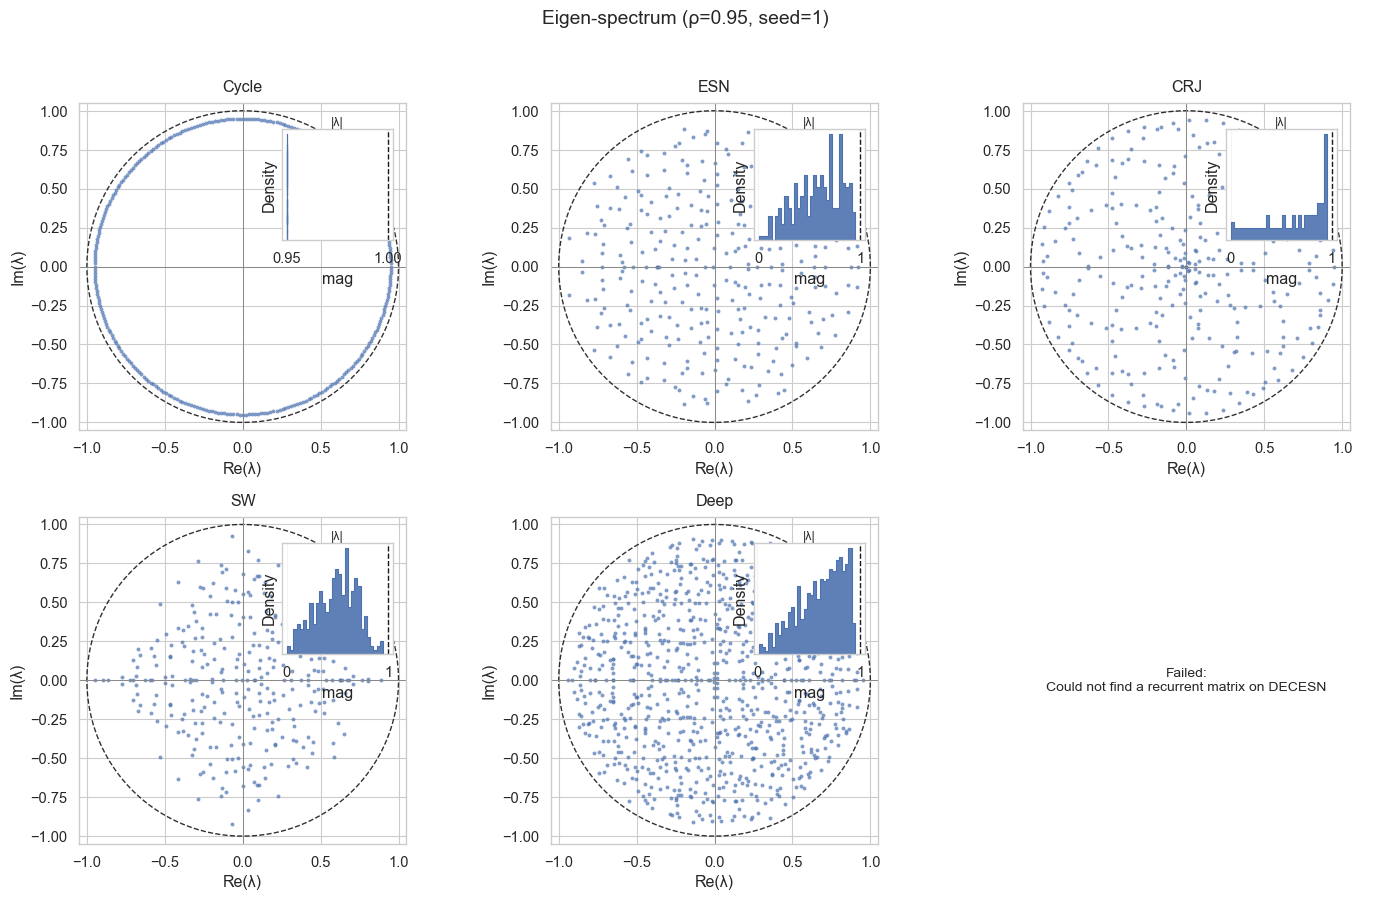

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\eigenspectrum_grid_rho0.95_seed1.png


In [22]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def _safe(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try common attribute names for the (square) recurrent matrix.
    Returns a dense ndarray or raises AttributeError.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def _instantiate(factory_or_class, rho, seed):
    """
    Robustly instantiate either a factory (callable) or a class with (rho, seed).
    Tries a few common constructor signatures.
    """
    # If it's a simple factory: assume (rho, seed)
    if not inspect.isclass(factory_or_class):
        return factory_or_class(rho, seed)

    # It's a class: try several signatures
    cls = factory_or_class
    tried = []
    for kwargs in [
        {"spectral_radius": rho, "seed": seed},
        {"rho": rho, "seed": seed},
        {"rho_mix": rho, "rho_theta": rho, "rho_gamma": rho, "seed": seed},
        {"seed": seed},
        {},
    ]:
        try:
            return cls(**kwargs)
        except TypeError as e:
            tried.append((kwargs, str(e)))
            continue
    # If we get here, all attempts failed
    msgs = "\n".join([f"  tried {k} -> {m}" for k, m in tried])
    raise TypeError(f"Could not instantiate {cls.__name__} with rho={rho}, seed={seed}.\n{msgs}")

def plot_eigenspectrum_models(
    BASELINES: dict,
    TESTING_RES_CLASS=None,           # class or factory; optional
    rho: float = 0.95,
    seed: int = 0,
    add_hist: bool = True,
    ncols: int = 3,
    dpi: int = 300,
    max_points: int = 5000,           # downsample eigenvalues if huge
):
    """
    One panel per model: eigenvalues in C with unit circle; optional inset of |λ|.
    Uses seaborn styling; saves a PNG in figures/.

    BASELINES: dict[str, callable] where callable takes (rho, seed) and returns a model.
    TESTING_RES_CLASS: optional class or factory to include as "Testing".
    """
    factories = dict(BASELINES)  # copy
    if TESTING_RES_CLASS is not None:
        factories[TESTING_NAME] = lambda r, s: _instantiate(TESTING_RES_CLASS, r, s)

    names = list(factories.keys())
    n = len(names)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8 * ncols, 4.4 * nrows))
    axes = np.atleast_2d(axes)

    theta = np.linspace(0, 2*np.pi, 1024)
    unit = np.exp(1j * theta)

    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]

        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed:\n{e}", ha="center", va="center", fontsize=10)
            ax.axis("off")
            continue

        # optional downsample for very large reservoirs
        if eig.size > max_points:
            sel = np.random.default_rng(seed).choice(eig.size, size=max_points, replace=False)
            eig = eig[sel]

        # scatter in complex plane (seaborn style)
        df = pd.DataFrame({"Re": eig.real, "Im": eig.imag, "mag": np.abs(eig)})
        sns.scatterplot(
            data=df, x="Re", y="Im",
            s=8, alpha=0.7, linewidth=0, ax=ax
        )

        # unit circle + axes
        ax.plot(unit.real, unit.imag, "k--", lw=1.0, alpha=0.9)
        ax.axhline(0, color="#888", lw=0.7); ax.axvline(0, color="#888", lw=0.7)

        # equal aspect and symmetric limits with a small pad
        lim = max(1.05, df[["Re","Im"]].abs().to_numpy().max() * 1.05)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_aspect("equal", adjustable="box")

        ax.set_title(name, pad=8)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")

        # inset |λ| histogram using seaborn
        if add_hist:
            inset = ax.inset_axes([0.62, 0.58, 0.34, 0.34])
            sns.histplot(df["mag"], bins=30, stat="density", element="step", alpha=0.9, ax=inset)
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_title("|λ|", fontsize=9, pad=2)
            inset.set_yticks([])
            inset.grid(True, alpha=0.2)

    # hide unused axes
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.suptitle(f"Eigen-spectrum (ρ={rho}, seed={seed})", y=1.02)
    plt.tight_layout()

    out = FIG_DIR / f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")


plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


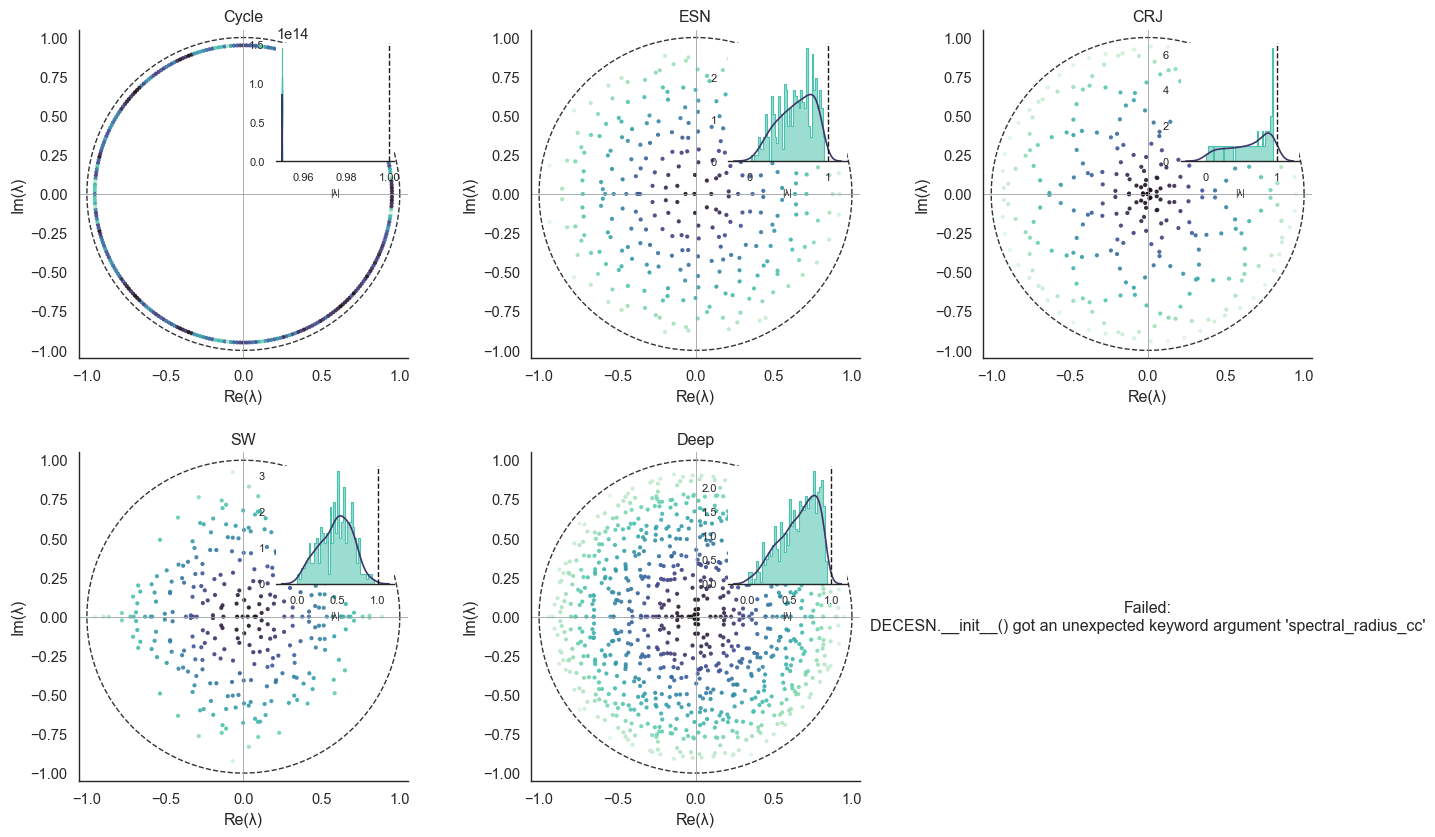

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\eigenspectrum_grid_rho0.95_seed1.png


In [23]:
sns.set_theme(style="white", context="paper", font_scale=1.2)

def _safe(s): 
    return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try to fetch the reservoir recurrent matrix from common attribute names.
    Returns a dense ndarray or raises.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def plot_eigenspectrum_models(
    BASELINES, 
    TESTING_RES_CLASS=None, 
    rho=0.95, 
    seed=0,
    add_hist=True, 
    ncols=3, 
    dpi=300,
    cmap="mako",               # seaborn colormap name
    title=None,
    save_name=None
):
    """
    One panel per model: eigenvalues in ℂ with unit circle, colored by |λ|.
    Optional inset histogram + KDE of |λ|.
    """

    # Build factory dict
    factories = dict(BASELINES)  # copy (preserve your order)
    if TESTING_RES_CLASS is not None:
        #factories["Testing"] = lambda r, s: TESTING_RES_CLASS(spectral_radius=r, seed=s)
        factories[TESTING_NAME] = lambda r, s: TESTING_RES_CLASS(spectral_radius_cc=r, seed=s)


    names = list(factories.keys())
    n = len(names)
    ncols = max(1, min(ncols, n))
    nrows = int(np.ceil(n / ncols))

    # Precompute eigenvalues so we can use consistent color scaling & limits
    eig_map, max_abs = {}, 1.0
    for name in names:
        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
            eig_map[name] = eig
            max_abs = max(max_abs, float(np.abs(eig).max()))
        except Exception as e:
            eig_map[name] = e

    # Figure + axes
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 4.4*nrows))
    axes = np.atleast_2d(axes)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 512)
    unit = np.exp(1j * theta)

    # Axes limits
    rlim = max(1.05, 1.05 * max_abs)

    # Colormap
    import matplotlib as mpl
    from matplotlib import cm
    # Allow seaborn colormap strings
    try:
        cmap_obj = sns.color_palette(cmap, as_cmap=True)
    except Exception:
        cmap_obj = cm.get_cmap(cmap)

    # Plot each model
    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        ax.set_aspect("equal", adjustable="box")

        if isinstance(eig_map[name], Exception):
            ax.text(0.5, 0.5, f"Failed:\n{eig_map[name]}", ha="center", va="center")
            ax.axis("off")
            continue

        eig = eig_map[name]
        lam_abs = np.abs(eig)

        sc = ax.scatter(eig.real, eig.imag, s=9, c=lam_abs, cmap=cmap_obj,
                        alpha=0.9, linewidths=0)

        # Unit circle + axes
        ax.plot(unit.real, unit.imag, color="black", ls="--", lw=1.0, alpha=0.8)
        ax.axhline(0, color="#9aa1a6", lw=0.6)
        ax.axvline(0, color="#9aa1a6", lw=0.6)

        # Limits, labels
        ax.set_xlim(-rlim, rlim); ax.set_ylim(-rlim, rlim)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")
        ax.set_title(name)

        # Inset |λ| distribution
        if add_hist:
            inset = ax.inset_axes([0.60, 0.60, 0.36, 0.36])
            sns.histplot(lam_abs, bins=40, stat="density", element="step",
                         fill=True, alpha=0.55, ax=inset, color=sns.color_palette("mako", 3)[2])
            try:
                sns.kdeplot(lam_abs, lw=1.2, ax=inset, color=sns.color_palette("mako", 3)[0])
            except Exception:
                pass
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_xlabel("|λ|", fontsize=7)
            inset.set_ylabel("")
            inset.tick_params(axis="both", labelsize=8)
            sns.despine(ax=inset, left=True, bottom=False)

        sns.despine(ax=ax)

    # Hide unused axes
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    # Global title and colorbar
    #if title is None:
        #title = f"Eigen-spectrum (ρ={rho}, seed={seed})"
    fig.suptitle(title, y=1.02)

    # Shared colorbar for |λ|
    # Create a fake ScalarMappable with global normalization
    '''norm = mpl.colors.Normalize(vmin=0, vmax=max_abs)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.018, pad=0.02)
    cbar.set_label("|λ|")'''

    plt.tight_layout()

    # Save
    if save_name is None:
        save_name = f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    out = FIG_DIR / save_name
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")


plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


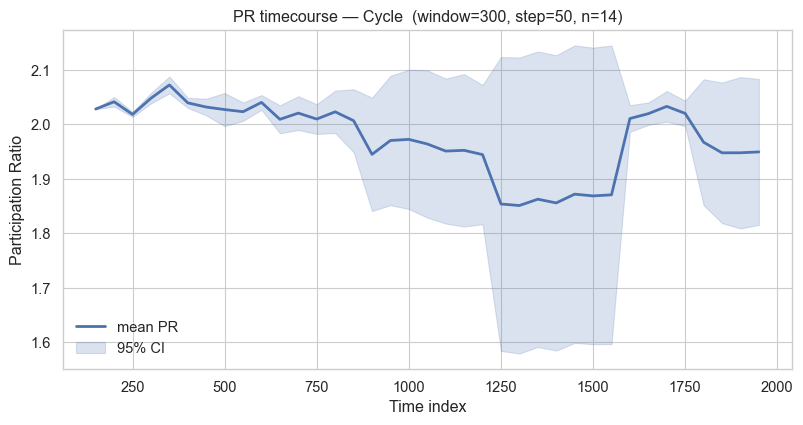

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\pr_timecourse_Cycle.png


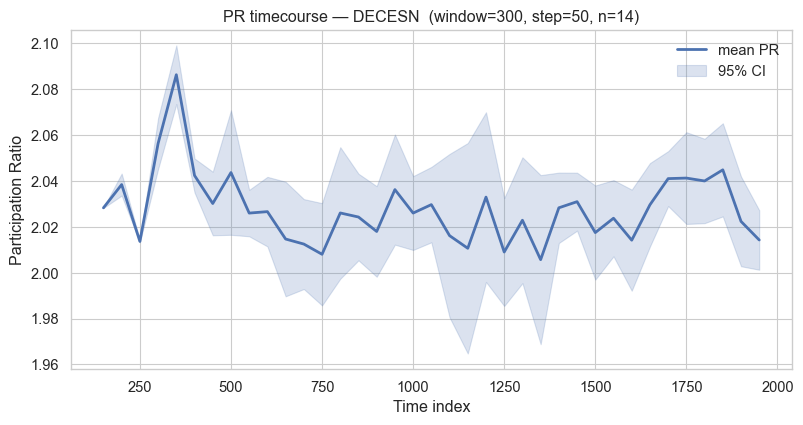

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\pr_timecourse_DECESN.png


In [24]:
# ===================== Participation Ratio utilities & plots =====================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)



def _safe_name(s: str) -> str:
    return str(s).replace(" ", "").replace("/", "_")

def participation_ratio(X: np.ndarray) -> float:
    """
    Effective dimensionality: (tr Σ)^2 / tr(Σ^2), where Σ is the column covariance.
    X shape: [T, D]  (time × dims)
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[0] < 2:
        return np.nan
    Xc = X - X.mean(axis=0, keepdims=True)
    C = np.cov(Xc, rowvar=False)  # D×D
    tr = float(np.trace(C))
    tr2 = float(np.sum(C * C))    # Frobenius norm squared
    if tr2 <= 0 or not np.isfinite(tr2):
        return np.nan
    return (tr * tr) / (tr2 + 1e-12)

def pr_timecourse_from_preds(pred: np.ndarray, window: int = 300, step: int = 50):
    """
    Sliding-window PR over predicted outputs (dims in columns).
    Returns: (center_indices, PR_values)
    """
    pred = np.asarray(pred, dtype=float)
    if pred.ndim == 1:
        pred = pred[:, None]
    T = len(pred)
    if window < 2 or T < window:
        # not enough data for one window
        return np.array([], dtype=int), np.array([], dtype=float)

    vals, centers = [], []
    for s in range(0, T - window + 1, step):
        Xw = pred[s:s+window]
        vals.append(participation_ratio(Xw))
        centers.append(s + window // 2)
    return np.asarray(centers, dtype=int), np.asarray(vals, dtype=float)

def plot_pr_timecourse_mean_ci(pred_store: dict, model: str, scenarios: list,
                               window: int = 300, step: int = 50, dpi: int = 300,
                               color: str = "C0"):
    """
    scenarios: list of keys (Model, Init, Split, Rho, Seed) to average PR over.
    Uses predictions only (no ground truth needed).
    """
    if not scenarios:
        raise ValueError("No scenarios provided.")

    all_t, all_pr = [], []
    for key in scenarios:
        if key[0] != model:
            raise ValueError(f"Scenario {key} does not match model '{model}'.")
        if key not in pred_store:
            # skip missing predictions gracefully
            continue
        pred = pred_store[key]
        t_idx, pr = pr_timecourse_from_preds(pred, window=window, step=step)
        if len(pr) == 0:
            continue
        all_t.append(t_idx)
        all_pr.append(pr)

    if not all_pr:
        raise ValueError("No valid PR series (maybe window too large for sequences).")

    # Align by minimum common length
    L = min(map(len, all_pr))
    all_pr = np.stack([p[:L] for p in all_pr], axis=0)
    t_idx = all_t[0][:L]
    mean = np.nanmean(all_pr, axis=0)
    sd   = np.nanstd(all_pr, axis=0)
    n    = all_pr.shape[0]
    ci   = 1.96 * sd / np.sqrt(max(n, 1))

    plt.figure(figsize=(8.2, 4.4))
    plt.plot(t_idx, mean, lw=2.0, color=color, label="mean PR")
    plt.fill_between(t_idx, mean - ci, mean + ci, color=color, alpha=0.20, label="95% CI")
    plt.xlabel("Time index")
    plt.ylabel("Participation Ratio")
    plt.title(f"PR timecourse — {model}  (window={window}, step={step}, n={n})")
    plt.legend(frameon=False)
    plt.tight_layout()
    out = FIG_DIR / f"pr_timecourse_{_safe_name(model)}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")

def plot_pr_vs_error(df_metrics: pd.DataFrame, pr_dict: dict,
                     metric: str = "NRMSE", horizon: int = 1000, dpi: int = 300):
    """
    Scatter of model-wise mean PR vs performance metric.

    df_metrics: DataFrame containing per-scenario metrics with at least a 'Model' column.
                If it has a 'Horizon' column, we select rows with Horizon==horizon.
    pr_dict   : {(Model, Init, Split, Rho, Seed)->PR} or {Model->PR}. We average by Model.
    """
    # Build PR per model
    rows = []
    for k, v in pr_dict.items():
        mdl = k[0] if isinstance(k, tuple) else k
        rows.append({"Model": mdl, "PR": float(v)})
    pr_df = pd.DataFrame(rows)
    pr_mean = pr_df.groupby("Model", as_index=True)["PR"].mean()

    # Build metric per model
    if "Horizon" in df_metrics.columns:
        met_series = (df_metrics[df_metrics["Horizon"] == horizon]
                      .groupby("Model", as_index=True)[metric].mean())
    else:
        met_series = df_metrics.groupby("Model", as_index=True)[metric].mean()

    # Align and drop missing
    dfp = pd.concat([pr_mean, met_series], axis=1).dropna()
    if dfp.empty:
        raise ValueError("No overlapping models between PR and metrics.")

    plt.figure(figsize=(6.6, 5.2))
    sns.regplot(data=dfp.reset_index(), x="PR", y=metric, scatter_kws=dict(s=60, alpha=0.85))
    # annotate points
    for _, row in dfp.reset_index().iterrows():
        plt.annotate(row["Model"], (row["PR"], row[metric]),
                     textcoords="offset points", xytext=(6, 6))
    plt.title(f"Participation Ratio vs {metric}" + (f"  (h={horizon})" if "Horizon" in df_metrics.columns else ""))
    plt.tight_layout()
    out = FIG_DIR / f"pr_vs_{metric}" / ("h" + str(horizon) if "Horizon" in df_metrics.columns else "overall")
    out.parent.mkdir(parents=True, exist_ok=True)
    out = out.with_suffix(".png")
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")

# choose scenarios for one model 
scens = [k for k in pred_store if k[0] == "Cycle"  and k[2] == 0.8 and k[3] == 0.95]
plot_pr_timecourse_mean_ci(pred_store, "Cycle",   scens, window=300, step=50)

scens = [k for k in pred_store if k[0] == "DECESN" and k[2] == 0.8 and k[3] == 0.95]
plot_pr_timecourse_mean_ci(pred_store, "DECESN", scens, window=300, step=50)


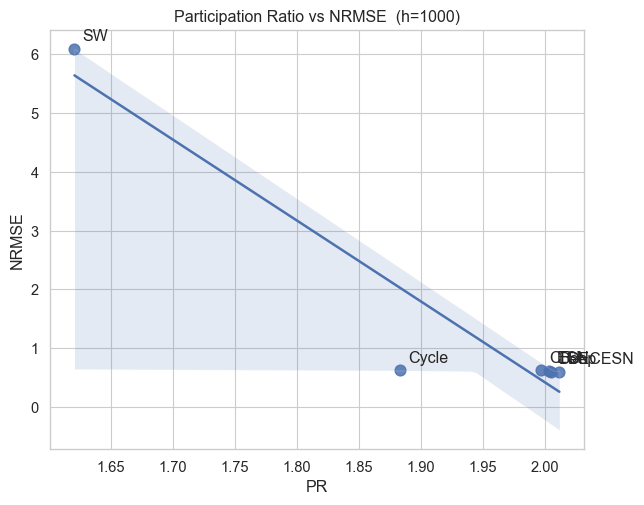

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\pr_vs_NRMSE\h1000.png


In [25]:
# =================== PR vs NRMSE@1000 (no truth recomputation) ===================

H = 1000  # target horizon

# 1) One-number PR per scenario (whole prediction window)
pr_per_scen = {
    k: participation_ratio(pred_store[k])
    for k in pred_store.keys()
}

# 2) Build per-scenario NRMSE@1000 using ORIGINAL test_y from DATA cache
rows = []
skipped = 0
for k, pred in pred_store.items():
    # key format: (Model, Init, Split, Rho, Seed)
    model, init_id, split, rho, seed = k

    # fetch ORIGINAL test target from cache
    if 'DATA' not in globals() or (init_id, split) not in DATA:
        raise RuntimeError(
            f"DATA cache missing for (init={init_id}, split={split}). "
            "Please build DATA[(init, split)] with {'test_y', 'time_test', ...}."
        )
    y_true = DATA[(init_id, split)]["test_y"]

    # ensure equal length & enough samples for the requested horizon
    T = min(len(pred), len(y_true))
    if T < H:
        skipped += 1
        continue

    # compute NRMSE at horizon H using your existing helper
    nrmse_at_H = evaluate_nrmse(pred[:H], y_true[:H], [H])[H]
    rows.append({"Model": model, "Horizon": H, "NRMSE": nrmse_at_H})

if skipped:
    print(f"Note: skipped {skipped} scenario(s) with fewer than {H} steps.")

df_metrics = pd.DataFrame(rows)

# 3) Plot PR (per-scenario) vs NRMSE@1000 (aggregated to per-model inside the helper)
plot_pr_vs_error(df_metrics, pr_per_scen, metric="NRMSE", horizon=H)


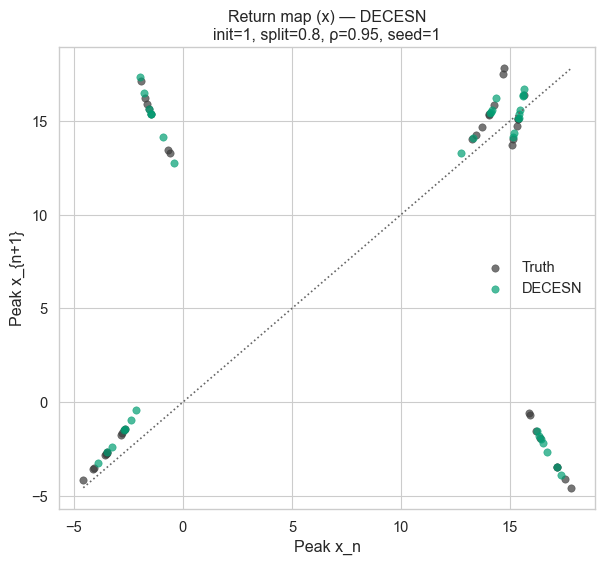

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\returnmap_DECESN_x_init1_split0.8_rho0.95_seed1.png


In [26]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def _safe(s): return s.replace(" ", "").replace("/", "_")

def _extract_peaks(sig, distance=20, prominence=None):
    """Return peak values in order."""
    idx, _ = find_peaks(sig, distance=distance, prominence=prominence)
    return sig[idx]

def plot_return_map_per_model(pred_store, DATA, model, init_id, split, rho, seed,
                              component=0, distance=20, prominence=None,
                              dpi=300):
    """Return map: peak_{n+1} vs peak_n for truth & model (chosen component)."""
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]
    y_true = DATA[(init_id, split)]["test_y"]
    T = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:T], y_pred[:T]

    # peaks
    pt = _extract_peaks(y_true[:, component], distance=distance, prominence=prominence)
    pp = _extract_peaks(y_pred[:, component], distance=distance, prominence=prominence)

    # build x_n -> x_{n+1}
    def _pairs(v):
        return v[:-1], v[1:] if len(v) > 1 else (np.array([]), np.array([]))
    xt, yt = _pairs(pt)
    xp, yp = _pairs(pp)

    comp_name = ["x", "y", "z"][component]
    plt.figure(figsize=(6.2, 5.8))
    sns.scatterplot(x=xt, y=yt, s=28, color=TRUTH_COLOR, label="Truth", alpha=0.7, edgecolor=None)
    sns.scatterplot(x=xp, y=yp, s=28, color=PALETTE.get(model, "C0"), label=model, alpha=0.7, edgecolor=None)

    # y=x reference & limits
    lo = min(xt.min() if len(xt) else 0, xp.min() if len(xp) else 0,
             yt.min() if len(yt) else 0, yp.min() if len(yp) else 0)
    hi = max(xt.max() if len(xt) else 1, xp.max() if len(xp) else 1,
             yt.max() if len(yt) else 1, yp.max() if len(yp) else 1)
    plt.plot([lo, hi], [lo, hi], ls=":", color="#666", lw=1.2)
    plt.xlabel(f"Peak {comp_name}_n"); plt.ylabel(f"Peak {comp_name}_{{n+1}}")
    plt.title(f"Return map ({comp_name}) — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.legend(frameon=False); plt.tight_layout()
    out = FIG_DIR / f"returnmap_{_safe(model)}_{comp_name}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_return_map_per_model(pred_store, DATA, "DECESN", init_id=1, split=0.8, rho=0.95, seed=1,
                          component=0, distance=30, prominence=None)


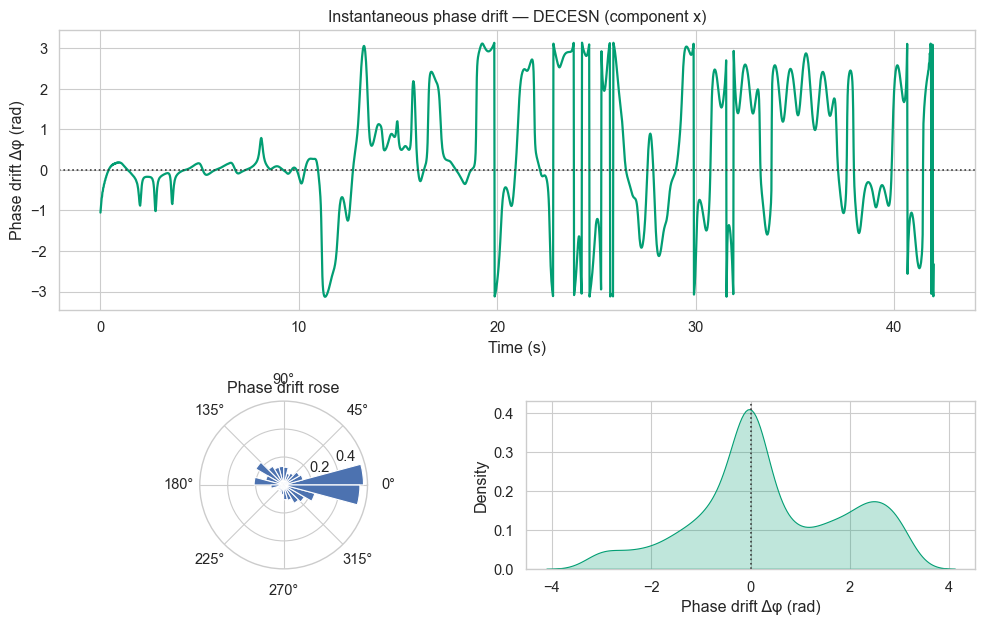

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\phase_drift_DECESN_x_init1_split0.8_rho0.95_seed1.png


In [27]:
def _phase(sig):
    """Analytic phase in radians, unwrapped."""
    a = hilbert(sig - np.mean(sig))
    return np.unwrap(np.angle(a))

def plot_phase_drift_per_model(pred_store, DATA, model, init_id, split, rho, seed,
                               component=0, max_len=None, bins=24, dpi=300):
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]
    y_true = DATA[(init_id, split)]["test_y"]
    T = min(len(y_true), len(y_pred))
    if max_len is not None: T = min(T, max_len)
    y_true, y_pred = y_true[:T, component], y_pred[:T, component]

    φ_true = _phase(y_true)
    φ_pred = _phase(y_pred)
    Δφ = np.mod(φ_pred - φ_true + np.pi, 2*np.pi) - np.pi  # wrap to (-π, π)

    t = DATA[(init_id, split)]["time_test"][:T]

    # layout: time series (top) + rose histogram (bottom)
    fig = plt.figure(figsize=(10, 6.4))
    gs = fig.add_gridspec(2, 2, height_ratios=[2.0, 1.2])
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0], projection='polar')
    ax2 = fig.add_subplot(gs[1, 1])

    # phase drift time-course
    ax0.plot(t, Δφ, color=PALETTE.get(model, "C0"), lw=1.6)
    ax0.axhline(0, color=TRUTH_COLOR, ls=":", lw=1.2)
    ax0.set_ylabel("Phase drift Δφ (rad)"); ax0.set_xlabel("Time (s)")
    ax0.set_title(f"Instantaneous phase drift — {model} (component {['x','y','z'][component]})")

    # rose histogram
    theta = Δφ % (2*np.pi)
    ax1.hist(theta, bins=bins, density=True)
    ax1.set_title("Phase drift rose")

    # KDE of phase drift
    sns.kdeplot(x=Δφ, fill=True, ax=ax2, color=PALETTE.get(model, "C0"))
    ax2.axvline(0, color=TRUTH_COLOR, ls=":", lw=1.2)
    ax2.set_xlabel("Phase drift Δφ (rad)"); ax2.set_ylabel("Density")
    plt.tight_layout()
    out = FIG_DIR / f"phase_drift_{_safe(model)}_{['x','y','z'][component]}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_phase_drift_per_model(pred_store, DATA, "DECESN", init_id=1, split=0.8, rho=0.95, seed=1, component=0)

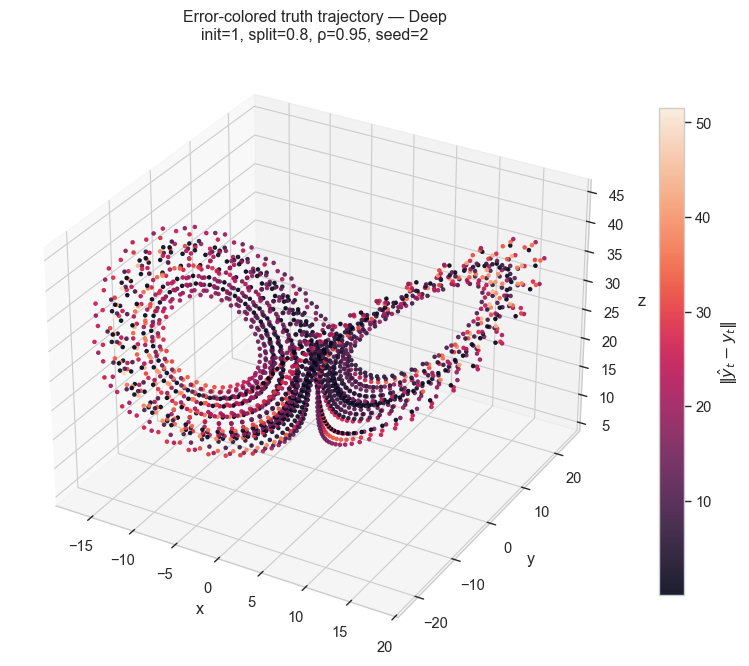

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\err_colored_attractor_Deep_init1_split0.8_rho0.95_seed2.png


In [28]:
def plot_error_colored_attractor(pred_store, DATA, model, init_id, split, rho, seed,
                                 max_points=8000, cmap="rocket", dpi=300):
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    Yp = pred_store[key]
    Yt = DATA[(init_id, split)]["test_y"]
    T = min(len(Yp), len(Yt))
    Yp, Yt = Yp[:T], Yt[:T]

    err = np.linalg.norm(Yp - Yt, axis=1)  # pointwise 3D error
    # downsample evenly to keep picture crisp
    if T > max_points:
        idx = np.linspace(0, T-1, max_points).astype(int)
        Yt, err = Yt[idx], err[idx]

    fig = plt.figure(figsize=(8.4, 6.8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Yt[:,0], Yt[:,1], Yt[:,2], c=err, cmap=cmap, s=6, alpha=0.9)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    cb = plt.colorbar(sc, pad=0.05, shrink=0.8)
    cb.set_label(r"$\| \hat{y}_t - y_t \|$")
    ax.set_title(f"Error-colored truth trajectory — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout()
    out = FIG_DIR / f"err_colored_attractor_{_safe(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_error_colored_attractor(pred_store, DATA, "Deep", init_id=1, split=0.8, rho=0.95, seed=2)

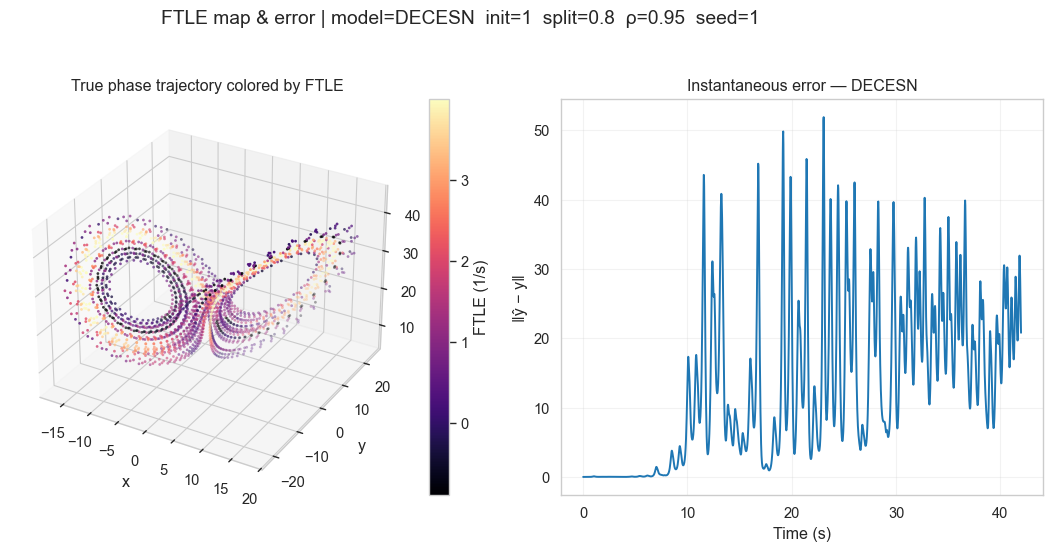

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\ftle_map_DECESN_init1_split0.8_rho0.95_seed1.png


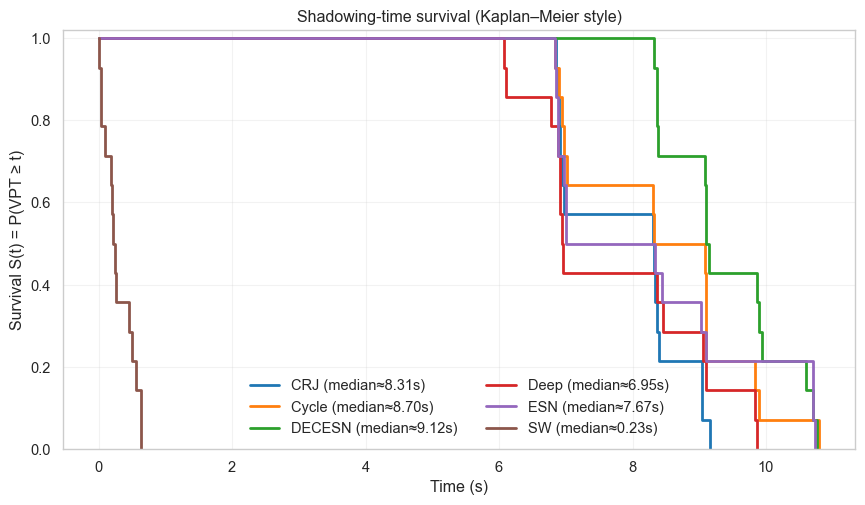

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\survival_shadowing_curves.png


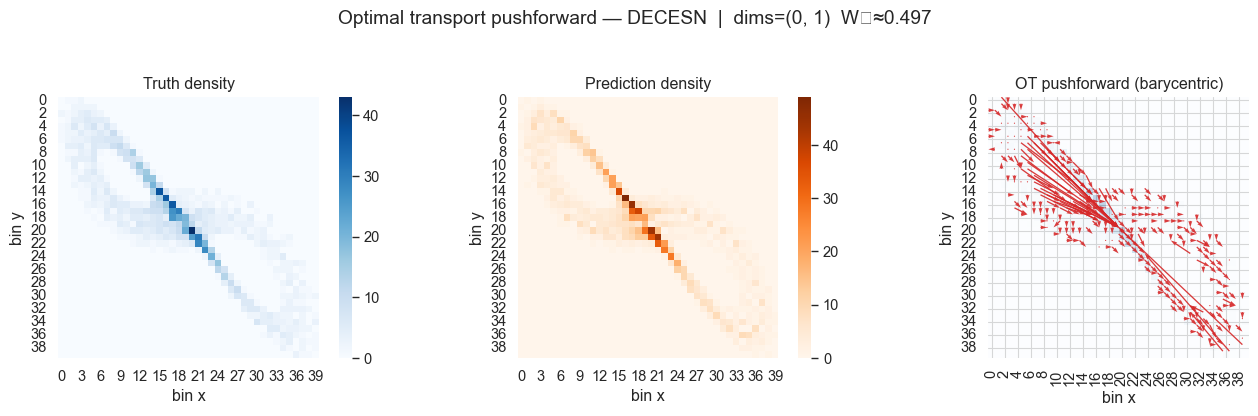

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\ot_pushforward_DECESN_init1_split0.8_rho0.95_seed1_d01.png


In [29]:
# ============================================
# FTLE map • Shadowing-time survival • OT pushforward
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


# Palette helper
def _palette_from_pred_store(pred_store, palette="tab10"):
    models = sorted({k[0] for k in pred_store.keys()})
    pal = sns.color_palette(palette, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# ------------------------------------------------------------
# 1) FTLE map along the true trajectory (per-model figure)
# ------------------------------------------------------------
def plot_ftle_map(DATA, pred_store, model, init_id, split, rho, seed,
                  tau_steps=40, theiler=50, max_len=5000,
                  cmap="magma", truth_color="#3b3b3b", dpi=300):
    """
    Colors the TRUE 3D trajectory by local FTLE, computed via nearest-neighbor
    separation over a horizon of 'tau_steps' while skipping a Theiler window.
    Also overlays instantaneous error ‖ŷ - y‖ over time.
    """
    # --- fetch truth + time
    y_true = DATA[(init_id, split)]["test_y"]
    t      = DATA[(init_id, split)]["time_test"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No preds for {key}")
    y_pred = pred_store[key]

    # align
    T = min(len(t), len(y_true), len(y_pred))
    t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    if max_len is not None:
        T = min(T, max_len)
        t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    dt = float(np.mean(np.diff(t))) if len(t) > 1 else 1.0
    if T <= tau_steps + 2:
        raise ValueError("Sequence too short for given tau_steps.")

    # --- FTLE via nearest neighbor with Theiler window
    eps = 1e-12
    ftle = np.full(T, np.nan, dtype=float)
    tree = cKDTree(y_true[:-tau_steps])  # neighbors only where j+tau valid

    for i in range(T - tau_steps):
        # query a few neighbors; pick first outside Theiler window
        dists, idxs = tree.query(y_true[i], k=min(15, T - tau_steps))
        if np.isscalar(idxs):
            idxs = np.array([idxs])
            dists = np.array([dists])
        j = None
        for cand in idxs:
            if abs(cand - i) > theiler:
                j = int(cand); break
        if j is None:
            continue
        d0 = norm(y_true[i] - y_true[j]) + eps
        d1 = norm(y_true[i + tau_steps] - y_true[j + tau_steps]) + eps
        ftle[i] = (1.0 / (tau_steps * dt)) * np.log(d1 / d0)

    # robust color scaling
    vmin = np.nanpercentile(ftle, 5)
    vmax = np.nanpercentile(ftle, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = np.nanmin(ftle), np.nanmax(ftle)

    # error norm
    err = norm(y_pred - y_true, axis=1)

    # --- figure: left 3D colored by FTLE, right error over time
    fig = plt.figure(figsize=(12, 5.6))
    gs = GridSpec(1, 2, width_ratios=[1.2, 1.0], figure=fig)
    ax3d = fig.add_subplot(gs[0, 0], projection="3d")

    # Use scatter with FTLE color
    cvals = ftle
    sc = ax3d.scatter(y_true[:,0], y_true[:,1], y_true[:,2],
                      c=cvals, cmap=cmap, s=4, linewidths=0, vmin=vmin, vmax=vmax)
    ax3d.set_xlabel("x"); ax3d.set_ylabel("y"); ax3d.set_zlabel("z")
    ax3d.set_title("True phase trajectory colored by FTLE")
    cb = fig.colorbar(sc, ax=ax3d, fraction=0.046, pad=0.04)
    cb.set_label("FTLE (1/s)")

    ax = fig.add_subplot(gs[0, 1])
    ax.plot(t, err, lw=1.4, color="#1f77b4")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("‖ŷ − y‖")
    ax.set_title(f"Instantaneous error — {model}")
    ax.grid(alpha=0.25)

    plt.suptitle(f"FTLE map & error | model={model}  init={init_id}  split={split}  ρ={rho}  seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.95])

    out = FIG_DIR / f"ftle_map_{model.replace(' ','')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# ------------------------------------------------------------
# 2) Shadowing-time survival curves (Kaplan–Meier style)
# ------------------------------------------------------------
def _km_from_times(times):
    """
    Given list/array of positive times (shadowing durations), return step points (x, S(x)).
    S(t) = P(T >= t). Censoring not handled; assumes full observations.
    """
    times = np.asarray(times, float)
    times = times[np.isfinite(times) & (times >= 0)]
    if times.size == 0:
        return np.array([0.0]), np.array([1.0])
    ts = np.sort(times)
    n = len(ts)
    xs = np.r_[0.0, ts]
    # S jumps down at each observed time (no ties handled separately—fine visually)
    S = [1.0]
    remaining = n
    last = 0.0
    for t in ts:
        remaining -= 1
        S.append(remaining / n)
        last = t
    return xs, np.array(S)

def plot_shadowing_survival(pred_store, DATA, models=None, splits=None, rhos=None, seeds=None,
                            threshold=0.4, lambda_max=None, palette="tab10",
                            title="Shadowing-time survival (Kaplan–Meier style)",
                            dpi=300):
    """
    Build survival curves S(t) = P(VPT >= t). Uses your compute_valid_prediction_time().
    Filters by model/split/rho/seed if provided.
    """
    # try to grab lambda_max from your global map if not supplied
    if lambda_max is None:
        try:
            lambda_max = LAMBDA_MAP.get(SYSTEM.lower(), 0.9)
        except Exception:
            lambda_max = 0.9

    # selection
    keys = list(pred_store.keys())
    if models is not None:
        keys = [k for k in keys if k[0] in set(models)]
    if splits is not None:
        keys = [k for k in keys if k[2] in set(splits)]
    if rhos is not None:
        keys = [k for k in keys if k[3] in set(rhos)]
    if seeds is not None:
        keys = [k for k in keys if k[4] in set(seeds)]

    if len(keys) == 0:
        raise ValueError("No matching scenarios in pred_store with given filters.")

    model_list = sorted({k[0] for k in keys})
    palmap = {m: c for m, c in zip(model_list, sns.color_palette(palette, n_colors=len(model_list)))}

    # compute VPT per scenario
    vpts = {m: [] for m in model_list}
    for (model, init_id, split, rho, seed) in keys:
        y_true = DATA[(init_id, split)]["test_y"]
        t      = DATA[(init_id, split)]["time_test"]
        pred   = pred_store[(model, init_id, split, rho, seed)]
        T = min(len(t), len(y_true), len(pred))
        y_true = y_true[:T]; pred = pred[:T]; t = t[:T]
        try:
            T_VPT, T_lambda, _ = compute_valid_prediction_time(
                y_true, pred, t, threshold=threshold, lambda_max=lambda_max
            )
            vpts[model].append(float(T_VPT))
        except Exception:
            # fall back: first time error exceeds threshold (absolute norm)
            err = norm(pred - y_true, axis=1)
            idx = np.argmax(err > threshold)
            tv = t[idx] if (err > threshold).any() else t[-1]
            vpts[model].append(float(tv))

    # plot survival curves
    plt.figure(figsize=(8.8, 5.2))
    for m in model_list:
        xs, S = _km_from_times(vpts[m])
        plt.step(xs, S, where="post", color=palmap[m], lw=2, label=f"{m} (median≈{np.nanmedian(vpts[m]):.2f}s)")
    plt.ylim(0, 1.02)
    plt.xlabel("Time (s)"); plt.ylabel("Survival S(t) = P(VPT ≥ t)")
    plt.title(title)
    plt.grid(alpha=0.25)
    plt.legend(frameon=False, ncol=2)
    out = FIG_DIR / "survival_shadowing_curves.png"
    plt.tight_layout(); plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# ------------------------------------------------------------
# 4) Optimal-transport “pushforward” (2D plane) via Sinkhorn
# ------------------------------------------------------------
def _hist2d_with_centers(X, dims=(0,1), bins=40, ranges=None):
    if isinstance(bins, int): bins = (bins, bins)
    x = X[:, dims[0]]; y = X[:, dims[1]]
    if ranges is None:
        xr = (x.min(), x.max()); yr = (y.min(), y.max())
    else:
        xr, yr = ranges
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[xr, yr])
    # centers
    xc = 0.5*(xedges[:-1] + xedges[1:])
    yc = 0.5*(yedges[:-1] + yedges[1:])
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")
    centers = np.stack([Xc.ravel(), Yc.ravel()], axis=1)  # (n_cells, 2)
    return H, centers, (xr, yr)

def _sinkhorn(a, b, C, reg=0.05, n_iter=200, tol=1e-9):
    """
    Simple entropic Sinkhorn on CPU.
    a, b: nonnegative, sum to 1, shape (n,), (m,)
    C: cost matrix (n, m)
    reg: regularization strength (smaller = closer to true OT, slower/stiffer)
    Returns transport plan P (n, m).
    """
    K = np.exp(-C / reg)
    u = np.ones_like(a) / a.size
    v = np.ones_like(b) / b.size
    eps = 1e-16
    for it in range(n_iter):
        u_prev = u
        Kv = K @ v + eps
        u = a / Kv
        Ku = K.T @ u + eps
        v = b / Ku
        if it % 10 == 0 and np.linalg.norm(u - u_prev, 1) < tol:
            break
    P = (u[:, None] * K) * v[None, :]
    return P

def plot_ot_pushforward(DATA, pred_store, model, init_id, split, rho, seed,
                        dims=(0,1), bins=40, reg=0.05,
                        n_vectors=250, min_mass=1e-4, max_len=None,
                        cmap_truth="Blues", cmap_pred="Oranges", dpi=300):
    """
    2D plane (dims) OT between truth and prediction histograms on same grid.
    Left: truth density; middle: pred density; right: pushforward vectors
    (mass-weighted displacement of each source cell).
    """
    y_true = DATA[(init_id, split)]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No preds for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None: T = min(T, max_len)
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # shared ranges for fairness
    mins = np.minimum(y_true.min(axis=0), y_pred.min(axis=0))
    maxs = np.maximum(y_true.max(axis=0), y_pred.max(axis=0))
    ranges = [(mins[dims[0]], maxs[dims[0]]),
              (mins[dims[1]], maxs[dims[1]])]

    Ht, centers, _ = _hist2d_with_centers(y_true, dims=dims, bins=bins, ranges=ranges)
    Hp, _, _        = _hist2d_with_centers(y_pred, dims=dims, bins=bins, ranges=ranges)

    a = Ht.ravel().astype(float); b = Hp.ravel().astype(float)
    sa, sb = a.sum(), b.sum()
    if sa == 0 or sb == 0:
        raise ValueError("Empty histograms; cannot compute OT.")
    a /= sa; b /= sb

    # cost matrix (squared Euclidean)
    C = distance.cdist(centers, centers, metric="sqeuclidean")
    P = _sinkhorn(a, b, C, reg=reg, n_iter=300)

    # W2 distance (with squared cost)
    W2_sq = np.sum(P * C)
    W2 = np.sqrt(max(W2_sq, 0.0))

    # Pushforward vectors: expected destination for each source cell
    # skip tiny-mass cells to declutter
    mask = a > min_mass
    a_pos = a[mask]
    centers_src = centers[mask]
    P_sub = P[mask, :]                        # (#src, n_cells)
    dest_mean = (P_sub @ centers) / a_pos[:, None]  # (#src, 2)
    disp = dest_mean - centers_src            # displacement vectors

    # ranking vectors by mass*length
    lengths = np.linalg.norm(disp, axis=1)
    score = a_pos * lengths
    keep = min(n_vectors, len(score))
    if keep > 0:
        idx = np.argsort(score)[-keep:]
        centers_k = centers_src[idx]
        disp_k = disp[idx]
    else:
        centers_k = centers_src
        disp_k = disp

    # --- plot densities + pushforward field ---
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

    sns.heatmap(Ht.T, ax=axes[0], cmap=cmap_truth, cbar=True, square=True)
    axes[0].set_title("Truth density"); axes[0].set_xlabel("bin x"); axes[0].set_ylabel("bin y")

    sns.heatmap(Hp.T, ax=axes[1], cmap=cmap_pred, cbar=True, square=True)
    axes[1].set_title("Prediction density"); axes[1].set_xlabel("bin x"); axes[1].set_ylabel("bin y")

    ax = axes[2]
    sns.heatmap(Ht.T, ax=ax, cmap=cmap_truth, cbar=False, alpha=0.25, square=True)
    # normalize to bin coordinates (i,j) for quiver
    nx, ny = (Ht.shape[0], Ht.shape[1])
    # map centers to grid indices by inverting mesh
    # We can reuse integer grid with spacing 1:
    # Build pseudo-grid: centers already on uniform grid; reconstruct grid index by rank
    # Simpler: rescale centers to [0, nx-1]×[0, ny-1] for arrows
    cx = centers_k[:,0]; cy = centers_k[:,1]
    # Use original centers of full grid:
    all_x = np.unique(centers[:,0]); all_y = np.unique(centers[:,1])
    ix = np.searchsorted(all_x, cx)
    iy = np.searchsorted(all_y, cy)
    tx = dest_mean[idx][:,0]; ty = dest_mean[idx][:,1]
    ixt = np.searchsorted(all_x, tx)
    iyt = np.searchsorted(all_y, ty)

    ax.quiver(ix, iy, (ixt - ix), (iyt - iy),
              angles='xy', scale_units='xy', scale=1.0,
              color="#d62728", width=0.005, alpha=0.9)
    ax.set_aspect("equal")
    ax.set_title("OT pushforward (barycentric)")
    ax.set_xlabel("bin x"); ax.set_ylabel("bin y")

    plt.suptitle(f"Optimal transport pushforward — {model}  |  dims={dims}  W₂≈{W2:.3f}")
    plt.tight_layout(rect=[0,0,1,0.94])

    out = FIG_DIR / f"ot_pushforward_{model.replace(' ','')}_init{init_id}_split{split}_rho{rho}_seed{seed}_d{dims[0]}{dims[1]}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")



# 1) FTLE map for one scenario/model
plot_ftle_map(DATA, pred_store, model="DECESN", init_id=1, split=0.8, rho=0.95, seed=1,
               tau_steps=40, theiler=50, max_len=4000)

# 2) Shadowing-time survival curves for a subset (all models by default)
plot_shadowing_survival(pred_store, DATA, models=None, splits=[0.8], rhos=[0.95],
                         threshold=0.4, lambda_max=None)

# 4) OT pushforward on x–y plane
plot_ot_pushforward(DATA, pred_store, model="DECESN", init_id=1, split=0.8, rho=0.95, seed=1,
                     dims=(0,1), bins=40, reg=0.05, n_vectors=300, max_len=4000)


# Real-World Datasets

In [22]:
!pip install wfdb


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 20.1 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [wfdb]
   ---------------------------------------- 2/2 [wfdb]



In [3]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

# Get input signal u(t) from the first channel
u = record.p_signal[:, 0]
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425])

## MIT-BIH Dataset

In [13]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

emb_dim = 3
# inputs = u_norm

def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb
    
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}")

Total samples: 25000, train size: 15000, test size: 9999


In [8]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=400,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=5000)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=5000)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

KeyboardInterrupt: 

In [ ]:
for seed in seeds:
    dec = DECESN(
        num_nodes         = 800,
        input_dim         = 3,
        edges             = None,
        faces             = None,
        avg_degree        = 8,
        star0_diag        = None,
        star1_diag        = None,
        star2_diag        = None,
        lam_node          = 0.25,
        lam_edge          = 0.25,
        lam_face          = 0.25,
        leak_exact        = 0.40,
        leak_coexact      = 0.40,
        leak_harm         = 0.05,
        heat0             = 0.05,
        heat1             = 0.05,
        heat2             = 0.05,
        alpha             = 0.3,
        beta              = 0.3,
        gamma             = 0.3,
        node_mix_gain     = 0.3,
        edge_mix_gain     = 0.3,
        face_mix_gain     = 0.3,
        input_scale_node  = 0.5,
        input_scale_edge  = 0.5,
        input_scale_face  = 0.5,
        projector_eps     = 1e-4,
        cg_tol            = 1e-6,
        cg_maxiter        = 200,
        proj_every        = 5,
        ridge_alpha       = 1e-6,
        use_poly          = True,
        feature_mode      = "node_harm",
        seed              = seed,
    )
    dec.fit_readout(train_input, train_target, discard=100)
    dec_preds = dec.predict_open_loop(test_input)
    dec_nrmse = evaluate_nrmse(dec_preds, test_target, all_horizons)
    nrmse_dict['DEC'].append(dec_nrmse)

print("Done!")

In [79]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'DEC':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    dec_vals = [np.mean(dec_nrmse[horizon]) for dec_nrmse in nrmse_dict['DEC']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, dec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           DEC              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.3945 ± 0.0218   0.5558 ± 0.0885   0.5511 ± 0.0675   0.7140 ± 0.0580   0.3839 ± 0.0379   0.4311 ± 0.0214   
600        0.3457 ± 0.0272   0.5783 ± 0.1124   0.5665 ± 0.1118   0.7472 ± 0.0585   0.3690 ± 0.0485   0.4884 ± 0.0317   
1000       0.3362 ± 0.0246   0.5105 ± 0.0887   0.5097 ± 0.0908   0.7428 ± 0.0540   0.3582 ± 0.0470   0.4826 ± 0.0235   


In [1]:
!pip install optuna




   -------------------- ------------------- 2/4 [alembic]
   -------------------- ------------------- 2/4 [alembic]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ------------------------------ --------- 3/4 [optuna]
   ---------------------------------------- 4/4 [optuna]



In [11]:
all_horizons = [300, 600, 1000]

In [12]:
import optuna
import numpy as np

In [16]:
def sample_hyperparams(trial):
    # Single leak shared across exact, coexact, and harmonic
    leak_val = round(trial.suggest_float("leak_val", 0.1, 0.8), 2)

    # Gains and scales (rounded)
    node_mix_gain = round(trial.suggest_float("node_mix_gain", 0.1, 0.8), 2)
    edge_mix_gain = round(trial.suggest_float("edge_mix_gain", 0.1, 0.8), 2)
    face_mix_gain = round(trial.suggest_float("face_mix_gain", 0.1, 0.8), 2)
    input_scale_node = round(trial.suggest_float("input_scale_node", 0.01, 0.3, log=True), 2)
    input_scale_edge = round(trial.suggest_float("input_scale_edge", 0.01, 0.3, log=True), 2)
    input_scale_face = round(trial.suggest_float("input_scale_face", 0.01, 0.3, log=True), 2)

    # Heat params
    heat0 = round(trial.suggest_float("heat0", 0.001, 0.1, log=True), 2)
    heat1 = round(trial.suggest_float("heat1", 0.001, 0.1, log=True), 2)
    heat2 = round(trial.suggest_float("heat2", 0.001, 0.1, log=True), 2)

    # Coupling weights normalized to sum=1
    alpha = trial.suggest_float("alpha_raw", 0.1, 1.0)
    beta  = trial.suggest_float("beta_raw", 0.1, 1.0)
    gamma = trial.suggest_float("gamma_raw", 0.1, 1.0)
    s = alpha + beta + gamma
    alpha, beta, gamma = round(alpha/s, 2), round(beta/s, 2), round(gamma/s, 2)

    return dict(
        num_nodes = 300,  # fixed
        avg_degree = round(trial.suggest_int("avg_degree", 4, 10), 2),
        lam_node = round(trial.suggest_float("lam_node", 0.1, 0.8), 2),
        lam_edge = round(trial.suggest_float("lam_edge", 0.1, 0.8), 2),
        lam_face = round(trial.suggest_float("lam_face", 0.1, 0.8), 2),
        leak_exact=leak_val,
        leak_coexact=leak_val,
        leak_harm=leak_val,
        heat0=heat0,
        heat1=heat1,
        heat2=heat2,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        node_mix_gain=node_mix_gain,
        edge_mix_gain=edge_mix_gain,
        face_mix_gain=face_mix_gain,
        input_scale_node=input_scale_node,
        input_scale_edge=input_scale_edge,
        input_scale_face=input_scale_face,
        ridge_alpha = round(trial.suggest_float("ridge_alpha", 1e-6, 1e-3, log=True), 2),
        projector_eps = round(trial.suggest_float("projector_eps", 1e-5, 1e-3, log=True), 2),
        cg_tol = round(trial.suggest_float("cg_tol", 1e-5, 1e-3, log=True), 2),
        cg_maxiter = round(trial.suggest_int("cg_maxiter", 50, 200, step=25), 2),
        proj_every = round(trial.suggest_int("proj_every", 1, 5), 2),
        use_poly = trial.suggest_categorical("use_poly", [True, False]),
        feature_mode = trial.suggest_categorical("feature_mode", ["node", "node_harm", "full"]),
        input_dim = 3,
    )


In [17]:

def make_objective(train_input, train_target, test_input, test_target,
                   horizons, seeds=3, discard=5000, robust_lambda=0.1):
    def objective(trial):
        hp = sample_hyperparams(trial)
        all_seed_results = []  # Store results for each seed
        
        for s in range(seeds):
            try:
                hp["seed"] = s + 1000
                dec = DECESN(**hp)
                
                # Fit readout with error handling for NaN/instability
                dec.fit_readout(train_input, train_target, discard=discard)
                
                # Check if model state is stable after training
                if (np.any(np.isnan(dec.x)) or np.any(np.isinf(dec.x)) or 
                    np.any(np.isnan(dec.y)) or np.any(np.isinf(dec.y)) or
                    (dec.Q > 0 and (np.any(np.isnan(dec.z)) or np.any(np.isinf(dec.z))))):
                    raise optuna.TrialPruned()
                
                # Check if readout weights are reasonable
                if (dec.W_out is not None and 
                    (np.any(np.isnan(dec.W_out)) or np.any(np.isinf(dec.W_out)) or
                     np.max(np.abs(dec.W_out)) > 1e6)):
                    raise optuna.TrialPruned()
                
                preds = dec.predict_open_loop(test_input)
                
                # Check predictions for stability
                if np.any(np.isnan(preds)) or np.any(np.isinf(preds)):
                    raise optuna.TrialPruned()
                
                # Get NRMSE for all horizons
                nrmse_dict = evaluate_nrmse(preds, test_target, horizons)
                
                # Store results for this seed
                seed_results = {}
                for h in horizons:
                    if h in nrmse_dict:
                        h_score = nrmse_dict[h]
                        if isinstance(h_score, (list, np.ndarray)):
                            h_score = np.mean(h_score)
                        seed_results[h] = h_score
                    else:
                        seed_results[h] = float('inf')
                
                # Check for invalid scores
                if any(np.isnan(score) or np.isinf(score) or score > 1e6 
                       for score in seed_results.values()):
                    raise optuna.TrialPruned()
                
                all_seed_results.append(seed_results)
                
            except (ValueError, RuntimeError, np.linalg.LinAlgError, MemoryError):
                # Common errors from unstable reservoir dynamics
                raise optuna.TrialPruned()
            except Exception as e:
                # Log unexpected errors but still prune
                print(f"Unexpected error in trial {trial.number}: {e}")
                raise optuna.TrialPruned()
        
        if not all_seed_results:  # All seeds failed
            raise optuna.TrialPruned()
        
        # Calculate mean and std across seeds for each horizon
        horizon_means = {}
        horizon_stds = {}
        
        for h in horizons:
            values = [result[h] for result in all_seed_results if h in result and not np.isinf(result[h])]
            if values:
                horizon_means[h] = np.mean(values)
                horizon_stds[h] = np.std(values) if len(values) > 1 else 0.0
            else:
                horizon_means[h] = float('inf')
                horizon_stds[h] = 0.0
        
        # Print detailed results for this trial
        print(f"\n--- Trial {trial.number} Results ---")
        print(f"Hyperparameters:")
        print(f"  num_nodes: {hp['num_nodes']}, avg_degree: {hp['avg_degree']}")
        print(f"  leak_exact: {hp['leak_exact']:.3f}, leak_coexact: {hp['leak_coexact']:.3f}, leak_harm: {hp['leak_harm']:.3f}")
        print(f"  alpha: {hp['alpha']:.3f}, beta: {hp['beta']:.3f}, gamma: {hp['gamma']:.3f}")
        print(f"  feature_mode: {hp['feature_mode']}, use_poly: {hp['use_poly']}")
        print(f"NRMSE Results:")
        print(f"{'Horizon':<10} {'Mean NRMSE':<15} {'Std NRMSE':<15}")
        print("-" * 40)
        for h in horizons:
            mean_val = horizon_means[h]
            std_val = horizon_stds[h]
            if np.isinf(mean_val):
                print(f"{h:<10} {'FAILED':<15} {'-':<15}")
            else:
                print(f"{h:<10} {mean_val:.6f}      ± {std_val:.6f}")
        
        # Calculate overall score (average across horizons)
        valid_scores = [score for score in horizon_means.values() if not np.isinf(score)]
        if not valid_scores:
            raise optuna.TrialPruned()
        
        mean_score = np.mean(valid_scores)
        overall_std = np.mean([horizon_stds[h] for h in horizons if not np.isinf(horizon_means[h])])
        
        final_score = mean_score + robust_lambda * overall_std
        print(f"Overall Score: {final_score:.6f} (mean: {mean_score:.6f}, robustness penalty: {robust_lambda * overall_std:.6f})")
        print("-" * 50)
        
        return float(final_score)
    return objective

In [ ]:

# Create and run the optimization study
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

# Fixed: Pass all_horizons as the horizons parameter
study.optimize(
    make_objective(train_input, train_target, test_input, test_target,
                   all_horizons,  # This was missing!
                   seeds=3, discard=5000, robust_lambda=0.1),
    n_trials=50,
    n_jobs=2
)

print("Best trial:", study.best_trial.number)
print("Params:", study.best_trial.params)
print("Score:", study.best_trial.value)

[I 2025-08-24 15:44:22,799] A new study created in memory with name: no-name-f9ddb171-a5e9-4159-8939-1d25cf7111f8
[I 2025-08-24 15:51:42,600] Trial 1 pruned. 


Unexpected error in trial 1: 


[I 2025-08-24 15:56:18,493] Trial 2 pruned. 


Unexpected error in trial 2: 


[I 2025-08-24 16:05:59,960] Trial 3 pruned. 


Unexpected error in trial 3: 


[I 2025-08-24 16:32:07,972] Trial 0 finished with value: 1.9301911162853331 and parameters: {'leak_val': 0.22346386871681906, 'node_mix_gain': 0.6548051900055156, 'edge_mix_gain': 0.5852284202498651, 'face_mix_gain': 0.5677340178750634, 'input_scale_node': 0.27223543819596363, 'input_scale_edge': 0.07676895445117157, 'input_scale_face': 0.017793617997716806, 'heat0': 0.08961271310455879, 'heat1': 0.0035006535986785267, 'heat2': 0.004072022645297555, 'alpha_raw': 0.4911410262663771, 'beta_raw': 0.4833270531673023, 'gamma_raw': 0.21716644275224795, 'avg_degree': 9, 'lam_node': 0.6600843130442244, 'lam_edge': 0.4511317959096224, 'lam_face': 0.10752908784213128, 'ridge_alpha': 0.0001970327585987336, 'projector_eps': 0.0009615333862707332, 'cg_tol': 5.477957928111342e-05, 'cg_maxiter': 150, 'proj_every': 5, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 0 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.220, leak_coexact: 0.220, leak_harm: 0.220
  alpha: 0.410, beta: 0.410, gamma: 0.180
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        2.346516      ± 1.526875
600        1.751605      ± 1.034732
1000       1.368583      ± 0.677086
Overall Score: 1.930191 (mean: 1.822235, robustness penalty: 0.107956)
--------------------------------------------------


[I 2025-08-24 16:41:36,467] Trial 4 finished with value: 3521.9290650542707 and parameters: {'leak_val': 0.1420616417780561, 'node_mix_gain': 0.520888466133341, 'edge_mix_gain': 0.767753429120115, 'face_mix_gain': 0.16984636979010664, 'input_scale_node': 0.07306946413314716, 'input_scale_edge': 0.021820026554430386, 'input_scale_face': 0.04842549805571207, 'heat0': 0.05829953408490793, 'heat1': 0.005484013683955978, 'heat2': 0.00434802914361251, 'alpha_raw': 0.9847588150142975, 'beta_raw': 0.10172769770460202, 'gamma_raw': 0.5126074734693821, 'avg_degree': 10, 'lam_node': 0.37874034596766326, 'lam_edge': 0.32907163796737404, 'lam_face': 0.33495866681884656, 'ridge_alpha': 5.82290739501222e-06, 'projector_eps': 0.00021074563335278483, 'cg_tol': 0.0008655068851681996, 'cg_maxiter': 75, 'proj_every': 2, 'use_poly': False, 'feature_mode': 'full'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 4 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 10
  leak_exact: 0.140, leak_coexact: 0.140, leak_harm: 0.140
  alpha: 0.620, beta: 0.060, gamma: 0.320
  feature_mode: full, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        73.275063      ± 8.032449
600        5390.183046      ± 7548.434796
1000       3812.751734      ± 5339.306271
Overall Score: 3521.929065 (mean: 3092.069948, robustness penalty: 429.859117)
--------------------------------------------------


[I 2025-08-24 16:45:01,429] Trial 6 pruned. 


Unexpected error in trial 6: 


[I 2025-08-24 16:46:37,967] Trial 5 pruned. 


Unexpected error in trial 5: 


[I 2025-08-24 16:55:36,879] Trial 7 pruned. 


Unexpected error in trial 7: 


[I 2025-08-24 16:57:42,348] Trial 8 pruned. 


Unexpected error in trial 8: 


[I 2025-08-24 17:08:25,768] Trial 9 pruned. 


Unexpected error in trial 9: 


[I 2025-08-24 17:25:33,658] Trial 10 finished with value: 11.855360439674556 and parameters: {'leak_val': 0.33876740419862805, 'node_mix_gain': 0.17362298786447478, 'edge_mix_gain': 0.10355240789763526, 'face_mix_gain': 0.11064656718662681, 'input_scale_node': 0.014930475879618387, 'input_scale_edge': 0.2611022180664793, 'input_scale_face': 0.18835005159652504, 'heat0': 0.05100037845195593, 'heat1': 0.0074594548742460826, 'heat2': 0.014462177621990157, 'alpha_raw': 0.9760935727090163, 'beta_raw': 0.4266388535131628, 'gamma_raw': 0.9501999168610317, 'avg_degree': 6, 'lam_node': 0.44541752282946534, 'lam_edge': 0.39855563118281967, 'lam_face': 0.32581623250907266, 'ridge_alpha': 2.129631713625272e-05, 'projector_eps': 5.057370003131327e-05, 'cg_tol': 0.00035971761374865505, 'cg_maxiter': 100, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 10 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 6
  leak_exact: 0.340, leak_coexact: 0.340, leak_harm: 0.340
  alpha: 0.410, beta: 0.180, gamma: 0.400
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        14.622451      ± 14.572573
600        10.360624      ± 10.290944
1000       7.371415      ± 7.252403
Overall Score: 11.855360 (mean: 10.784830, robustness penalty: 1.070531)
--------------------------------------------------


[I 2025-08-24 17:47:40,036] Trial 11 finished with value: 3.2604855090874465 and parameters: {'leak_val': 0.42354393395303236, 'node_mix_gain': 0.4400057877990816, 'edge_mix_gain': 0.7660682000745695, 'face_mix_gain': 0.7286542020972064, 'input_scale_node': 0.027776609409098253, 'input_scale_edge': 0.043217962741441, 'input_scale_face': 0.013164847282053358, 'heat0': 0.02243427757491552, 'heat1': 0.0010762038375146494, 'heat2': 0.0010031728130032581, 'alpha_raw': 0.3560995693534027, 'beta_raw': 0.18049395641873867, 'gamma_raw': 0.33245250655907743, 'avg_degree': 8, 'lam_node': 0.5595680087065658, 'lam_edge': 0.789990059359206, 'lam_face': 0.7333857133477557, 'ridge_alpha': 0.0007738140219944, 'projector_eps': 9.33982775259941e-05, 'cg_tol': 1.087656839827135e-05, 'cg_maxiter': 125, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 11 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 8
  leak_exact: 0.420, leak_coexact: 0.420, leak_harm: 0.420
  alpha: 0.410, beta: 0.210, gamma: 0.380
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        3.857678      ± 1.629159
600        3.085374      ± 1.091640
1000       2.492870      ± 0.734551
Overall Score: 3.260486 (mean: 3.145307, robustness penalty: 0.115178)
--------------------------------------------------


[I 2025-08-24 18:03:20,563] Trial 12 finished with value: 1.987451857874655 and parameters: {'leak_val': 0.40949350203781276, 'node_mix_gain': 0.41109824641504916, 'edge_mix_gain': 0.6209127490636372, 'face_mix_gain': 0.7071932166734525, 'input_scale_node': 0.022186430303664937, 'input_scale_edge': 0.28472940630012566, 'input_scale_face': 0.012145642571273374, 'heat0': 0.02602569017068672, 'heat1': 0.06833652315261858, 'heat2': 0.019087215535508444, 'alpha_raw': 0.7970120066530891, 'beta_raw': 0.4761815178544414, 'gamma_raw': 0.9777426903129408, 'avg_degree': 8, 'lam_node': 0.5469446908051202, 'lam_edge': 0.6005609435740885, 'lam_face': 0.7790262830271193, 'ridge_alpha': 9.726939183793739e-05, 'projector_eps': 7.225183053721064e-05, 'cg_tol': 0.00019302581507895264, 'cg_maxiter': 125, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 12 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 8
  leak_exact: 0.410, leak_coexact: 0.410, leak_harm: 0.410
  alpha: 0.350, beta: 0.210, gamma: 0.430
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        2.447727      ± 1.499988
600        1.826203      ± 1.008912
1000       1.369419      ± 0.681163
Overall Score: 1.987452 (mean: 1.881116, robustness penalty: 0.106335)
--------------------------------------------------


C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:361: RuntimeWarning: overflow encountered in multiply
  x = (x + alpha * p).astype(np.float32)
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:293: RuntimeWarning: invalid value encountered in subtract
  return (x_vec[self.edge_v] - x_vec[self.edge_u]).astype(np.float32)
[I 2025-08-24 18:12:28,494] Trial 14 pruned. 
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:361: RuntimeWarning: overflow encountered in add
  x = (x + alpha * p).astype(np.float32)
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:293: RuntimeWarning: invalid value encountered in subtract
  return (x_vec[self.edge_v] - x_vec[self.edge_u]).astype(np.float32)
[I 2025-08-24 18:21:49,076] Trial 15 pruned. 
[


--- Trial 13 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 8
  leak_exact: 0.430, leak_coexact: 0.430, leak_harm: 0.430
  alpha: 0.460, beta: 0.150, gamma: 0.400
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        3.794426      ± 0.815809
600        3.204671      ± 0.431234
1000       2.718102      ± 0.254113
Overall Score: 3.289105 (mean: 3.239066, robustness penalty: 0.050039)
--------------------------------------------------


[I 2025-08-24 19:22:39,498] Trial 16 finished with value: 5.220660333797013 and parameters: {'leak_val': 0.3976605295277071, 'node_mix_gain': 0.5801961375138862, 'edge_mix_gain': 0.40165092703313654, 'face_mix_gain': 0.7672653468165449, 'input_scale_node': 0.028800689721040055, 'input_scale_edge': 0.15808358960139768, 'input_scale_face': 0.025532384693430533, 'heat0': 0.050102144264884525, 'heat1': 0.042146965782771564, 'heat2': 0.07580553532800595, 'alpha_raw': 0.4174351558151704, 'beta_raw': 0.5365968730278353, 'gamma_raw': 0.37820997208228335, 'avg_degree': 8, 'lam_node': 0.5255517123149311, 'lam_edge': 0.6939468706123454, 'lam_face': 0.6734261019376766, 'ridge_alpha': 0.0002489888300711769, 'projector_eps': 0.00015077866642885742, 'cg_tol': 0.0001723357593704326, 'cg_maxiter': 200, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 16 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 8
  leak_exact: 0.400, leak_coexact: 0.400, leak_harm: 0.400
  alpha: 0.310, beta: 0.400, gamma: 0.280
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        6.625336      ± 4.162422
600        4.724032      ± 2.910067
1000       3.403889      ± 2.014747
Overall Score: 5.220660 (mean: 4.917752, robustness penalty: 0.302908)
--------------------------------------------------


[I 2025-08-24 19:34:43,984] Trial 17 finished with value: 9.717925838097313 and parameters: {'leak_val': 0.33124059908540143, 'node_mix_gain': 0.5539937692524363, 'edge_mix_gain': 0.5345072755560618, 'face_mix_gain': 0.5808240514460511, 'input_scale_node': 0.11589209424007449, 'input_scale_edge': 0.14831486684719056, 'input_scale_face': 0.02529251131647965, 'heat0': 0.0406971937211115, 'heat1': 0.0417288680907357, 'heat2': 0.09770047371985942, 'alpha_raw': 0.8017161628947019, 'beta_raw': 0.270573368736653, 'gamma_raw': 0.10940757760277642, 'avg_degree': 9, 'lam_node': 0.517572941940095, 'lam_edge': 0.634074438232427, 'lam_face': 0.6554019052731136, 'ridge_alpha': 0.00023941941114582257, 'projector_eps': 0.00014826632055562513, 'cg_tol': 0.00019582686086270162, 'cg_maxiter': 200, 'proj_every': 3, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 0 with value: 1.9301911162853331.



--- Trial 17 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.330, leak_coexact: 0.330, leak_harm: 0.330
  alpha: 0.680, beta: 0.230, gamma: 0.090
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        12.957939      ± 2.273070
600        9.178104      ± 1.605713
1000       6.516609      ± 1.132481
Overall Score: 9.717926 (mean: 9.550884, robustness penalty: 0.167042)
--------------------------------------------------


[I 2025-08-24 19:54:34,263] Trial 18 finished with value: 0.8375290831253249 and parameters: {'leak_val': 0.3009999076818296, 'node_mix_gain': 0.5205126809517453, 'edge_mix_gain': 0.5406732832242431, 'face_mix_gain': 0.5796941765376529, 'input_scale_node': 0.11830201275342721, 'input_scale_edge': 0.11415775738684725, 'input_scale_face': 0.08111323412520782, 'heat0': 0.09776197318122, 'heat1': 0.002381448298032341, 'heat2': 0.0043367757502586575, 'alpha_raw': 0.7950455745065785, 'beta_raw': 0.2859206736551906, 'gamma_raw': 0.6282995131471452, 'avg_degree': 9, 'lam_node': 0.7195640910450755, 'lam_edge': 0.5122320039764865, 'lam_face': 0.4666200794560684, 'ridge_alpha': 4.50309553930538e-05, 'projector_eps': 0.00035901982976197904, 'cg_tol': 4.333957489521227e-05, 'cg_maxiter': 100, 'proj_every': 3, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 18 with value: 0.8375290831253249.



--- Trial 18 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.300, leak_coexact: 0.300, leak_harm: 0.300
  alpha: 0.470, beta: 0.170, gamma: 0.370
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.798936      ± 0.138598
600        0.837295      ± 0.050863
1000       0.853991      ± 0.034191
Overall Score: 0.837529 (mean: 0.830074, robustness penalty: 0.007455)
--------------------------------------------------


[I 2025-08-24 20:06:35,352] Trial 19 finished with value: 1.1335441533962844 and parameters: {'leak_val': 0.616719559533242, 'node_mix_gain': 0.10660640575640623, 'edge_mix_gain': 0.696571500670232, 'face_mix_gain': 0.563453328585639, 'input_scale_node': 0.018947047993048804, 'input_scale_edge': 0.026334689561512983, 'input_scale_face': 0.08863109861541968, 'heat0': 0.09278199841111158, 'heat1': 0.0023621054795004977, 'heat2': 0.005319807616243537, 'alpha_raw': 0.4821132288079135, 'beta_raw': 0.7421079394806533, 'gamma_raw': 0.6252820019669556, 'avg_degree': 9, 'lam_node': 0.705305544012093, 'lam_edge': 0.5244573745541473, 'lam_face': 0.4646050870345815, 'ridge_alpha': 3.5687195030657584e-05, 'projector_eps': 0.0005067214397946156, 'cg_tol': 5.1612144003912175e-05, 'cg_maxiter': 100, 'proj_every': 4, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 18 with value: 0.8375290831253249.



--- Trial 19 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.620, leak_coexact: 0.620, leak_harm: 0.620
  alpha: 0.260, beta: 0.400, gamma: 0.340
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        1.239309      ± 0.335343
600        1.116679      ± 0.159896
1000       0.986464      ± 0.086562
Overall Score: 1.133544 (mean: 1.114151, robustness penalty: 0.019393)
--------------------------------------------------


[I 2025-08-24 20:13:33,126] Trial 21 pruned. 


Unexpected error in trial 21: 


[I 2025-08-24 20:32:34,195] Trial 20 finished with value: 202233.383464594 and parameters: {'leak_val': 0.18949598446772847, 'node_mix_gain': 0.49406239312877975, 'edge_mix_gain': 0.7018117307052045, 'face_mix_gain': 0.6069716579932369, 'input_scale_node': 0.2094241389307278, 'input_scale_edge': 0.10462930619318604, 'input_scale_face': 0.08175324690406577, 'heat0': 0.07720209399329872, 'heat1': 0.002251771143044033, 'heat2': 0.0034587570037987315, 'alpha_raw': 0.6752301382246486, 'beta_raw': 0.25993023388021275, 'gamma_raw': 0.6128759300918516, 'avg_degree': 9, 'lam_node': 0.7171661384569437, 'lam_edge': 0.49105617902130216, 'lam_face': 0.4365000853639198, 'ridge_alpha': 4.871804455394957e-05, 'projector_eps': 0.0004935134787441033, 'cg_tol': 4.670926191221671e-05, 'cg_maxiter': 100, 'proj_every': 4, 'use_poly': False, 'feature_mode': 'full'}. Best is trial 18 with value: 0.8375290831253249.



--- Trial 20 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.190, leak_coexact: 0.190, leak_harm: 0.190
  alpha: 0.440, beta: 0.170, gamma: 0.400
  feature_mode: full, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        179578.777791      ± 211541.455700
600        198329.832378      ± 130854.000842
1000       190552.766788      ± 39992.277831
Overall Score: 202233.383465 (mean: 189487.125652, robustness penalty: 12746.257812)
--------------------------------------------------


[I 2025-08-24 20:37:58,131] Trial 22 finished with value: 1.3993045262392303 and parameters: {'leak_val': 0.17477223113339735, 'node_mix_gain': 0.12889297290226884, 'edge_mix_gain': 0.5361188699878701, 'face_mix_gain': 0.5641089243420784, 'input_scale_node': 0.1930995941074922, 'input_scale_edge': 0.06740050145649706, 'input_scale_face': 0.09133369120845597, 'heat0': 0.09435897805184604, 'heat1': 0.0025647480609463846, 'heat2': 0.005873982596327214, 'alpha_raw': 0.4930719510470766, 'beta_raw': 0.282430413451374, 'gamma_raw': 0.6885125694792202, 'avg_degree': 9, 'lam_node': 0.7144749442634326, 'lam_edge': 0.4967627206490684, 'lam_face': 0.5255745679038564, 'ridge_alpha': 5.21468638541257e-05, 'projector_eps': 0.0005428623491972234, 'cg_tol': 4.582376129957024e-05, 'cg_maxiter': 75, 'proj_every': 5, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 18 with value: 0.8375290831253249.



--- Trial 22 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.170, leak_coexact: 0.170, leak_harm: 0.170
  alpha: 0.340, beta: 0.190, gamma: 0.470
  feature_mode: node, use_poly: False
NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        1.735320      ± 0.309491
600        1.323150      ± 0.197279
1000       1.076425      ± 0.123410
Overall Score: 1.399305 (mean: 1.378299, robustness penalty: 0.021006)
--------------------------------------------------


In [1]:
import json
with open("best_dec_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=2)


NameError: name 'study' is not defined

## Sunspot Dataset

In [9]:
import pandas as pd
file_path = r"C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\datasets\SN_m_tot_V2.0.csv"

df = pd.read_csv(file_path, sep=';', header = None)
df

0   1         2      3     4     5  6
0     1749   1  1749.042   96.7  -1.0    -1  1
1     1749   2  1749.123  104.3  -1.0    -1  1
2     1749   3  1749.204  116.7  -1.0    -1  1
3     1749   4  1749.288   92.8  -1.0    -1  1
4     1749   5  1749.371  141.7  -1.0    -1  1
...    ...  ..       ...    ...   ...   ... ..
3310  2024  11  2024.873  152.5  20.9   681  0
3311  2024  12  2024.958  154.5  25.6   572  0
3312  2025   1  2025.042  137.0  23.3   670  0
3313  2025   2  2025.122  154.6  23.3   655  0
3314  2025   3  2025.204  134.2  20.4  1011  0

[3315 rows x 7 columns]

In [10]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [11]:
print(data[0], data[1])

[ 96.7 104.3 116.7] [104.3 116.7  92.8]


In [12]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.48837e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.47225e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.73925e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Done!


C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.80302e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [13]:
for seed in seeds:
    dec = DECESN(
        num_nodes        = 400,
        input_dim        = 3,
        edges            = None,
        faces            = None,
        avg_degree       = 9,
        star0_diag       = None,
        star1_diag       = None,
        star2_diag       = None,
        lam_node         = 0.55,
        lam_edge         = 0.35,
        lam_face         = 0.36,
        leak_exact       = 0.65,
        leak_coexact     = 0.28,
        leak_harm        = 0.13,
        heat0            = 0.06,
        heat1            = 0.00,
        heat2            = 0.04,
        alpha            = 0.22,
        beta             = 0.64,
        gamma            = 0.84,
        node_mix_gain    = 0.72,
        edge_mix_gain    = 0.56,
        face_mix_gain    = 0.10,
        input_scale_node = 0.29,
        input_scale_edge = 0.01,
        input_scale_face = 0.04,
        projector_eps    = 0.00,
        cg_tol           = 0.00,
        cg_maxiter       = 100,
        proj_every       = 2,
        ridge_alpha      = 0.00,
        use_poly         = True,
        feature_mode     = "full",
        seed             = seed,
    )

    dec.fit_readout(train_input, train_target, discard=100)
    dec_preds = dec.predict_open_loop(test_input)
    dec_nrmse = evaluate_nrmse(dec_preds, test_target, all_horizons)
    nrmse_dict['DEC'].append(dec_nrmse)

print("Done!")

C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Done!


In [14]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'DEC':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    dec_vals = [np.mean(dec_nrmse[horizon]) for dec_nrmse in nrmse_dict['DEC']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, dec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           DEC              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.3945 ± 0.0218   0.5558 ± 0.0885   0.5511 ± 0.0675   0.7140 ± 0.0580   0.3839 ± 0.0379   0.2575 ± 0.0102   
600        0.3457 ± 0.0272   0.5783 ± 0.1124   0.5665 ± 0.1118   0.7472 ± 0.0585   0.3690 ± 0.0485   0.2232 ± 0.0119   
1000       0.3362 ± 0.0246   0.5105 ± 0.0887   0.5097 ± 0.0908   0.7428 ± 0.0540   0.3582 ± 0.0470   0.2221 ± 0.0082   


## Santa Fe B

In [ ]:
import pandas as pd
import numpy as np
import optuna

# Load and preprocess Santa Fe dataset
file_path = r"\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\datasets\santa-fe-time-series\b1.txt"
df = pd.read_csv(file_path, header=None, sep=' ')

# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())
data = df.iloc[:, 0].values

chosen_system = "SantaFe"
dt = 1
T_data = len(data)

# Create delay embedding (assuming this function exists)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split for Santa Fe
train_end = 7000
train_input = data[:train_end]
train_target = data[1:train_end+1]
test_input = data[train_end:-1]
test_target = data[train_end+1:]

y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}")
print(f"Test size: {len(test_input)}")

# Define prediction horizons for Santa Fe dataset
santa_fe_horizons = [300, 600, 1000]  # Based on your existing code

def sample_hyperparams_santafe(trial):
    """
    Sample hyperparameters specifically tuned for Santa Fe time series dataset
    """
    # Leak constraints: ensure valid relationship
    leak_exact = trial.suggest_float("leak_exact", 0.1, 0.8)
    leak_coexact = trial.suggest_float("leak_coexact", 0.1, 0.8)
    # Bound leak_harm to be ≤ min(leak_exact, leak_coexact)
    leak_harm = trial.suggest_float("leak_harm", 0.0, min(leak_exact, leak_coexact) * 0.8)
    
    # Gain and scale constraints - adjusted for Santa Fe characteristics
    node_mix_gain = trial.suggest_float("node_mix_gain", 0.1, 0.8)
    edge_mix_gain = trial.suggest_float("edge_mix_gain", 0.1, 0.8)
    face_mix_gain = trial.suggest_float("face_mix_gain", 0.05, 0.6)  # Slightly lower for Santa Fe
    input_scale_node = trial.suggest_float("input_scale_node", 0.01, 0.5, log=True)
    input_scale_edge = trial.suggest_float("input_scale_edge", 0.005, 0.3, log=True)
    input_scale_face = trial.suggest_float("input_scale_face", 0.01, 0.3, log=True)
    
    # Heat and leak regularization
    heat0 = trial.suggest_float("heat0", 0.001, 0.15, log=True)
    heat1 = trial.suggest_float("heat1", 0.001, 0.1, log=True)
    heat2 = trial.suggest_float("heat2", 0.001, 0.1, log=True)
    
    # Coupling weights - ensure they sum to 1 for stability
    alpha_raw = trial.suggest_float("alpha_raw", 0.1, 1.0)
    beta_raw = trial.suggest_float("beta_raw", 0.1, 1.0)
    gamma_raw = trial.suggest_float("gamma_raw", 0.1, 1.0)
    s = alpha_raw + beta_raw + gamma_raw
    alpha, beta, gamma = alpha_raw/s, beta_raw/s, gamma_raw/s
    
    return dict(
        num_nodes = trial.suggest_int("num_nodes", 300, 800, step=50),  # Range around your baseline 400
        input_dim = 3,  # Fixed for Santa Fe with delay embedding
        avg_degree = trial.suggest_int("avg_degree", 6, 12),  # Range around your baseline 9
        lam_node = trial.suggest_float("lam_node", 0.2, 0.8),
        lam_edge = trial.suggest_float("lam_edge", 0.2, 0.8),
        lam_face = trial.suggest_float("lam_face", 0.2, 0.8),
        leak_exact = leak_exact,
        leak_coexact = leak_coexact,
        leak_harm = leak_harm,
        heat0 = heat0,
        heat1 = heat1,
        heat2 = heat2,
        alpha = alpha,
        beta = beta,
        gamma = gamma,
        node_mix_gain = node_mix_gain,
        edge_mix_gain = edge_mix_gain,
        face_mix_gain = face_mix_gain,
        input_scale_node = input_scale_node,
        input_scale_edge = input_scale_edge,
        input_scale_face = input_scale_face,
        ridge_alpha = trial.suggest_float("ridge_alpha", 1e-7, 1e-3, log=True),
        projector_eps = trial.suggest_float("projector_eps", 1e-5, 1e-2, log=True),
        cg_tol = trial.suggest_float("cg_tol", 1e-5, 1e-2, log=True),
        cg_maxiter = trial.suggest_int("cg_maxiter", 75, 150, step=25),
        proj_every = trial.suggest_int("proj_every", 1, 4),
        use_poly = trial.suggest_categorical("use_poly", [True, False]),
        feature_mode = trial.suggest_categorical("feature_mode", ["node", "node_harm", "full"]),
        edges = None,  # Let the model generate these
        faces = None,  # Let the model generate these
        star0_diag = None,
        star1_diag = None,
        star2_diag = None,
    )

def make_objective_santafe(train_input, train_target, test_input, test_target,
                          horizons, seeds=3, discard=100, robust_lambda=0.1):
    """
    Create objective function for Santa Fe dataset hyperparameter optimization
    """
    def objective(trial):
        hp = sample_hyperparams_santafe(trial)
        all_seed_results = []  # Store results for each seed
        
        for s in range(seeds):
            try:
                hp["seed"] = s + 1000
                dec = DECESN(**hp)
                
                # Fit readout with error handling for NaN/instability
                # Using smaller discard for Santa Fe (100 instead of 5000)
                dec.fit_readout(train_input, train_target, discard=discard)
                
                # Check if model state is stable after training
                if (np.any(np.isnan(dec.x)) or np.any(np.isinf(dec.x)) or 
                    np.any(np.isnan(dec.y)) or np.any(np.isinf(dec.y)) or
                    (dec.Q > 0 and (np.any(np.isnan(dec.z)) or np.any(np.isinf(dec.z))))):
                    raise optuna.TrialPruned()
                
                # Check if readout weights are reasonable
                if (dec.W_out is not None and 
                    (np.any(np.isnan(dec.W_out)) or np.any(np.isinf(dec.W_out)) or
                     np.max(np.abs(dec.W_out)) > 1e6)):
                    raise optuna.TrialPruned()
                
                preds = dec.predict_open_loop(test_input)
                
                # Check predictions for stability
                if np.any(np.isnan(preds)) or np.any(np.isinf(preds)):
                    raise optuna.TrialPruned()
                
                # Get NRMSE for all horizons
                nrmse_dict = evaluate_nrmse(preds, test_target, horizons)
                
                # Store results for this seed
                seed_results = {}
                for h in horizons:
                    if h in nrmse_dict:
                        h_score = nrmse_dict[h]
                        if isinstance(h_score, (list, np.ndarray)):
                            h_score = np.mean(h_score)
                        seed_results[h] = h_score
                    else:
                        seed_results[h] = float('inf')
                
                # Check for invalid scores
                if any(np.isnan(score) or np.isinf(score) or score > 1e6 
                       for score in seed_results.values()):
                    raise optuna.TrialPruned()
                
                all_seed_results.append(seed_results)
                
            except (ValueError, RuntimeError, np.linalg.LinAlgError, MemoryError):
                # Common errors from unstable reservoir dynamics
                raise optuna.TrialPruned()
            except Exception as e:
                # Log unexpected errors but still prune
                print(f"Unexpected error in trial {trial.number}: {e}")
                raise optuna.TrialPruned()
        
        if not all_seed_results:  # All seeds failed
            raise optuna.TrialPruned()
        
        # Calculate mean and std across seeds for each horizon
        horizon_means = {}
        horizon_stds = {}
        
        for h in horizons:
            values = [result[h] for result in all_seed_results if h in result and not np.isinf(result[h])]
            if values:
                horizon_means[h] = np.mean(values)
                horizon_stds[h] = np.std(values) if len(values) > 1 else 0.0
            else:
                horizon_means[h] = float('inf')
                horizon_stds[h] = 0.0
        
        # Print detailed results for this trial
        print(f"\n--- Santa Fe Trial {trial.number} Results ---")
        print(f"Hyperparameters:")
        print(f"  num_nodes: {hp['num_nodes']}, avg_degree: {hp['avg_degree']}")
        print(f"  leak_exact: {hp['leak_exact']:.3f}, leak_coexact: {hp['leak_coexact']:.3f}, leak_harm: {hp['leak_harm']:.3f}")
        print(f"  alpha: {hp['alpha']:.3f}, beta: {hp['beta']:.3f}, gamma: {hp['gamma']:.3f}")
        print(f"  feature_mode: {hp['feature_mode']}, use_poly: {hp['use_poly']}")
        print(f"Santa Fe NRMSE Results:")
        print(f"{'Horizon':<10} {'Mean NRMSE':<15} {'Std NRMSE':<15}")
        print("-" * 40)
        for h in horizons:
            mean_val = horizon_means[h]
            std_val = horizon_stds[h]
            if np.isinf(mean_val):
                print(f"{h:<10} {'FAILED':<15} {'-':<15}")
            else:
                print(f"{h:<10} {mean_val:.6f}      ± {std_val:.6f}")
        
        # Calculate overall score (average across horizons)
        valid_scores = [score for score in horizon_means.values() if not np.isinf(score)]
        if not valid_scores:
            raise optuna.TrialPruned()
        
        mean_score = np.mean(valid_scores)
        overall_std = np.mean([horizon_stds[h] for h in horizons if not np.isinf(horizon_means[h])])
        
        final_score = mean_score + robust_lambda * overall_std
        print(f"Overall Score: {final_score:.6f} (mean: {mean_score:.6f}, robustness penalty: {robust_lambda * overall_std:.6f})")
        print("-" * 50)
        
        return float(final_score)
    
    return objective

# Create and run the optimization study for Santa Fe
print("Starting Santa Fe hyperparameter optimization...")

study_santafe = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    study_name="santafe_optimization"
)

# Run the optimization
study_santafe.optimize(
    make_objective_santafe(
        train_input, train_target, test_input, test_target,
        santa_fe_horizons,  # Use Santa Fe specific horizons
        seeds=3, discard=100, robust_lambda=0.1
    ),
    n_trials=50,  # Adjust based on computational budget
    n_jobs=2      # Adjust based on available cores
)

print("\n" + "="*60)
print("SANTA FE OPTIMIZATION RESULTS")
print("="*60)
print("Best trial:", study_santafe.best_trial.number)
print("Best score:", study_santafe.best_trial.value)
print("\nBest hyperparameters:")
best_params = study_santafe.best_trial.params
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

# Test the best hyperparameters
print("\n" + "="*60)
print("TESTING BEST HYPERPARAMETERS")
print("="*60)

# Create a final model with best parameters for testing
best_hp = sample_hyperparams_santafe(study_santafe.best_trial)
seeds = [1000, 1001, 1002]  # Test with multiple seeds
nrmse_results = []

for seed in seeds:
    best_hp["seed"] = seed
    
    dec = DECESN(**best_hp)
    dec.fit_readout(train_input, train_target, discard=100)
    dec_preds = dec.predict_open_loop(test_input)
    dec_nrmse = evaluate_nrmse(dec_preds, test_target, santa_fe_horizons)
    nrmse_results.append(dec_nrmse)

print("\nFinal Santa Fe NRMSE Results with Best Hyperparameters:")
print("-" * 50)
print(f"{'Horizon':<10} {'Mean NRMSE':<15} {'Std NRMSE':<10}")
print("-" * 50)

for horizon in santa_fe_horizons:
    values = [np.mean(result[horizon]) for result in nrmse_results]
    mean_nrmse = np.mean(values)
    std_nrmse = np.std(values)
    print(f"{horizon:<10} {mean_nrmse:.6f}      ± {std_nrmse:.6f}")

print("\nOptimization completed!")

# Optionally save the study results
# study_santafe.trials_dataframe().to_csv("santafe_optimization_results.csv", index=False)
# print("Results saved to santafe_optimization_results.csv")

[I 2025-08-18 21:52:33,995] A new study created in memory with name: santafe_optimization


Data length: 17000.
Train size: 7000
Test size: 9997
Starting Santa Fe hyperparameter optimization...


C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2025-08-18 21:56:24,404] Trial 0 finished with value: 0.23456218234109577 and parameters: {'leak_exact': 0.5916463684969582, 'leak_coexact': 0.760116519420862, 'leak_harm': 0.271020361450865, 'node_mix_gain': 0.3885542834503861, 'edge_mix_gain': 0.7008652070107756, 'face_mix_gain': 0.5959775242325128, 'input_scale_node': 0.27948050896103166, 'input_scale_edge': 0.005577165420593317, 'input_scale_face': 0.09133522484876458, 'heat0


--- Santa Fe Trial 0 Results ---
Hyperparameters:
  num_nodes: 650, avg_degree: 12
  leak_exact: 0.592, leak_coexact: 0.760, leak_harm: 0.271
  alpha: 0.318, beta: 0.286, gamma: 0.396
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.268752      ± 0.008599
600        0.204645      ± 0.005713
1000       0.228110      ± 0.007485
Overall Score: 0.234562 (mean: 0.233836, robustness penalty: 0.000727)
--------------------------------------------------


[I 2025-08-18 21:56:40,474] Trial 1 finished with value: 0.14700121041501912 and parameters: {'leak_exact': 0.3929317183337998, 'leak_coexact': 0.7888545150602869, 'leak_harm': 0.2345923317581269, 'node_mix_gain': 0.5340944180272607, 'edge_mix_gain': 0.7077848349345577, 'face_mix_gain': 0.402945953684255, 'input_scale_node': 0.03720692118302507, 'input_scale_edge': 0.06051797305724138, 'input_scale_face': 0.03847509490312226, 'heat0': 0.11481837134779305, 'heat1': 0.0027094176826217404, 'heat2': 0.020433931025165025, 'alpha_raw': 0.14356727216321852, 'beta_raw': 0.2940078761606739, 'gamma_raw': 0.7611537542439206, 'num_nodes': 450, 'avg_degree': 10, 'lam_node': 0.556315547253464, 'lam_edge': 0.35066092961587414, 'lam_face': 0.4426431673062034, 'ridge_alpha': 4.402895702130349e-05, 'projector_eps': 0.0012655984248532203, 'cg_tol': 0.00030844554962499636, 'cg_maxiter': 150, 'proj_every': 3, 'use_poly': False, 'feature_mode': 'full'}. Best is trial 1 with value: 0.14700121041501912.



--- Santa Fe Trial 1 Results ---
Hyperparameters:
  num_nodes: 450, avg_degree: 10
  leak_exact: 0.393, leak_coexact: 0.789, leak_harm: 0.235
  alpha: 0.120, beta: 0.245, gamma: 0.635
  feature_mode: full, use_poly: False
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.159704      ± 0.000131
600        0.135893      ± 0.000124
1000       0.145378      ± 0.000034
Overall Score: 0.147001 (mean: 0.146992, robustness penalty: 0.000010)
--------------------------------------------------


[I 2025-08-18 21:59:21,983] Trial 2 finished with value: 0.14789168466820315 and parameters: {'leak_exact': 0.2541661071080904, 'leak_coexact': 0.3653588154522691, 'leak_harm': 0.031448129959004714, 'node_mix_gain': 0.36972965396262814, 'edge_mix_gain': 0.7735982121222893, 'face_mix_gain': 0.5229224723987865, 'input_scale_node': 0.23080231383843566, 'input_scale_edge': 0.011222167665195622, 'input_scale_face': 0.11168797957964115, 'heat0': 0.024427084414197515, 'heat1': 0.05169634352755819, 'heat2': 0.017844276033434463, 'alpha_raw': 0.6092265976805944, 'beta_raw': 0.2534736342243279, 'gamma_raw': 0.7291985963295391, 'num_nodes': 500, 'avg_degree': 12, 'lam_node': 0.640042347379959, 'lam_edge': 0.5512521629514041, 'lam_face': 0.6201906355413402, 'ridge_alpha': 4.415220330336907e-05, 'projector_eps': 0.003233678059503078, 'cg_tol': 2.9761185933234414e-05, 'cg_maxiter': 125, 'proj_every': 1, 'use_poly': True, 'feature_mode': 'node'}. Best is trial 1 with value: 0.14700121041501912.



--- Santa Fe Trial 2 Results ---
Hyperparameters:
  num_nodes: 500, avg_degree: 12
  leak_exact: 0.254, leak_coexact: 0.365, leak_harm: 0.031
  alpha: 0.383, beta: 0.159, gamma: 0.458
  feature_mode: node, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.160208      ± 0.002034
600        0.137271      ± 0.001814
1000       0.145663      ± 0.001479
Overall Score: 0.147892 (mean: 0.147714, robustness penalty: 0.000178)
--------------------------------------------------


[I 2025-08-18 22:00:59,045] Trial 4 finished with value: 0.1551154041655394 and parameters: {'leak_exact': 0.49282842137485916, 'leak_coexact': 0.16858483447847944, 'leak_harm': 0.023785656089620553, 'node_mix_gain': 0.5229836892451125, 'edge_mix_gain': 0.7156609727381494, 'face_mix_gain': 0.1438737200272781, 'input_scale_node': 0.022725733034133364, 'input_scale_edge': 0.014495661097570393, 'input_scale_face': 0.03606566639220272, 'heat0': 0.0385922246395316, 'heat1': 0.0021999130136173446, 'heat2': 0.003152845894292164, 'alpha_raw': 0.48726926008668336, 'beta_raw': 0.8898790560524799, 'gamma_raw': 0.7355318227065546, 'num_nodes': 300, 'avg_degree': 8, 'lam_node': 0.318696912644406, 'lam_edge': 0.5098982239256603, 'lam_face': 0.20147583142698933, 'ridge_alpha': 0.0002687221968954047, 'projector_eps': 0.00044899226181970356, 'cg_tol': 7.299396123463037e-05, 'cg_maxiter': 125, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'node'}. Best is trial 1 with value: 0.14700121041501912.



--- Santa Fe Trial 4 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 8
  leak_exact: 0.493, leak_coexact: 0.169, leak_harm: 0.024
  alpha: 0.231, beta: 0.421, gamma: 0.348
  feature_mode: node, use_poly: False
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.174266      ± 0.000334
600        0.139597      ± 0.000346
1000       0.151388      ± 0.000268
Overall Score: 0.155115 (mean: 0.155084, robustness penalty: 0.000032)
--------------------------------------------------


[I 2025-08-18 22:01:59,982] Trial 3 finished with value: 0.6763173117732966 and parameters: {'leak_exact': 0.6973021102513378, 'leak_coexact': 0.5357643694726251, 'leak_harm': 0.06208358547448607, 'node_mix_gain': 0.6810600444956345, 'edge_mix_gain': 0.776056098883947, 'face_mix_gain': 0.4585468032785833, 'input_scale_node': 0.010478968149501087, 'input_scale_edge': 0.047243260945384204, 'input_scale_face': 0.030171010921989157, 'heat0': 0.0034485084418284023, 'heat1': 0.007761788478471711, 'heat2': 0.0022485345578682012, 'alpha_raw': 0.41582057220068935, 'beta_raw': 0.7560520846793438, 'gamma_raw': 0.3509209626045694, 'num_nodes': 400, 'avg_degree': 10, 'lam_node': 0.20847639823054173, 'lam_edge': 0.43063707017068353, 'lam_face': 0.6074126840116298, 'ridge_alpha': 1.0418729116313491e-07, 'projector_eps': 0.0017604144185507907, 'cg_tol': 0.00025230127116718844, 'cg_maxiter': 125, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'full'}. Best is trial 1 with value: 0.14700121041501912


--- Santa Fe Trial 3 Results ---
Hyperparameters:
  num_nodes: 400, avg_degree: 10
  leak_exact: 0.697, leak_coexact: 0.536, leak_harm: 0.062
  alpha: 0.273, beta: 0.496, gamma: 0.230
  feature_mode: full, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.751658      ± 0.252826
600        0.530652      ± 0.114723
1000       0.692582      ± 0.173056
Overall Score: 0.676317 (mean: 0.658297, robustness penalty: 0.018020)
--------------------------------------------------


C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:414: RuntimeWarning: overflow encountered in multiply
  feat = np.concatenate([feat, feat * feat, [1.0]], axis=0).astype(np.float32)
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:299: RuntimeWarning: overflow encountered in add
  np.add.at(out, self.edge_v, +y_vec)
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:362: RuntimeWarning: invalid value encountered in multiply
  r = (r - alpha * Ap).astype(np.float32)
[I 2025-08-18 22:04:35,508] Trial 5 finished with value: 1.6832062866100617 and parameters: {'leak_exact': 0.14157460212935621, 'leak_coexact': 0.324997591577362, 'leak_harm': 0.0032107628414682976, 'node_mix_gain': 0.7915019429047792, 'edge_mix_gain': 0.7067647803042432, 'face_mix_gain': 0.555732265430464, 'input_scale_node': 0.


--- Santa Fe Trial 5 Results ---
Hyperparameters:
  num_nodes: 450, avg_degree: 10
  leak_exact: 0.142, leak_coexact: 0.325, leak_harm: 0.003
  alpha: 0.469, beta: 0.398, gamma: 0.133
  feature_mode: node_harm, use_poly: False
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        1.685230      ± 0.363769
600        1.608516      ± 0.316420
1000       1.655506      ± 0.323472
Overall Score: 1.683206 (mean: 1.649751, robustness penalty: 0.033455)
--------------------------------------------------


[I 2025-08-18 22:04:35,793] Trial 6 pruned. 
[I 2025-08-18 22:07:18,970] Trial 7 finished with value: 0.2713394174160132 and parameters: {'leak_exact': 0.4206028615599612, 'leak_coexact': 0.4461726525708126, 'leak_harm': 0.23343304663080214, 'node_mix_gain': 0.25163194799463384, 'edge_mix_gain': 0.5725240965599002, 'face_mix_gain': 0.13754980498975938, 'input_scale_node': 0.06575698873993795, 'input_scale_edge': 0.26211064492130265, 'input_scale_face': 0.09241881054008905, 'heat0': 0.018408406083375323, 'heat1': 0.006146365729615386, 'heat2': 0.013025576401849155, 'alpha_raw': 0.4179739740228823, 'beta_raw': 0.6569788869268309, 'gamma_raw': 0.3056659449504706, 'num_nodes': 300, 'avg_degree': 9, 'lam_node': 0.49457273390487755, 'lam_edge': 0.5323951454928172, 'lam_face': 0.7428098462355726, 'ridge_alpha': 1.0074220501280598e-07, 'projector_eps': 0.0002062108593220517, 'cg_tol': 0.00010713798216757255, 'cg_maxiter': 125, 'proj_every': 1, 'use_poly': False, 'feature_mode': 'full'}. Best i


--- Santa Fe Trial 7 Results ---
Hyperparameters:
  num_nodes: 300, avg_degree: 9
  leak_exact: 0.421, leak_coexact: 0.446, leak_harm: 0.233
  alpha: 0.303, beta: 0.476, gamma: 0.221
  feature_mode: full, use_poly: False
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.307940      ± 0.201088
600        0.214731      ± 0.097963
1000       0.248022      ± 0.134200
Overall Score: 0.271339 (mean: 0.256898, robustness penalty: 0.014442)
--------------------------------------------------


[I 2025-08-18 22:09:29,285] Trial 8 finished with value: 0.14386927975466957 and parameters: {'leak_exact': 0.6291644278432107, 'leak_coexact': 0.6311870556809206, 'leak_harm': 0.2677472430808337, 'node_mix_gain': 0.6446801627359339, 'edge_mix_gain': 0.11876972493508625, 'face_mix_gain': 0.4104369386995011, 'input_scale_node': 0.010032497897948592, 'input_scale_edge': 0.250860926184212, 'input_scale_face': 0.022017982597429934, 'heat0': 0.11488062043535928, 'heat1': 0.0075388874474571115, 'heat2': 0.003248806634256731, 'alpha_raw': 0.8782627905025026, 'beta_raw': 0.9328255465490544, 'gamma_raw': 0.4926138540838577, 'num_nodes': 350, 'avg_degree': 9, 'lam_node': 0.41053103873846297, 'lam_edge': 0.328516775945309, 'lam_face': 0.47088273705984435, 'ridge_alpha': 1.4454149603567564e-05, 'projector_eps': 6.058566356968395e-05, 'cg_tol': 2.206583538418358e-05, 'cg_maxiter': 75, 'proj_every': 1, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 8 with value: 0.14386927975466957.



--- Santa Fe Trial 8 Results ---
Hyperparameters:
  num_nodes: 350, avg_degree: 9
  leak_exact: 0.629, leak_coexact: 0.631, leak_harm: 0.268
  alpha: 0.381, beta: 0.405, gamma: 0.214
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.158576      ± 0.000910
600        0.131325      ± 0.000595
1000       0.141504      ± 0.000520
Overall Score: 0.143869 (mean: 0.143802, robustness penalty: 0.000068)
--------------------------------------------------


C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:299: RuntimeWarning: overflow encountered in add
  np.add.at(out, self.edge_v, +y_vec)
C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\reservoirs\decesn.py:362: RuntimeWarning: invalid value encountered in multiply
  r = (r - alpha * Ap).astype(np.float32)
[I 2025-08-18 22:10:39,974] Trial 9 finished with value: 0.15718985954645862 and parameters: {'leak_exact': 0.5435961370624758, 'leak_coexact': 0.47548784663790145, 'leak_harm': 0.1887092746353465, 'node_mix_gain': 0.7759616003043718, 'edge_mix_gain': 0.14931676485294154, 'face_mix_gain': 0.5891984587636298, 'input_scale_node': 0.1525329746145427, 'input_scale_edge': 0.019973523031588274, 'input_scale_face': 0.05106508683765996, 'heat0': 0.002646155378336615, 'heat1': 0.020394149223988776, 'heat2': 0.0248312174462635, 'alpha_raw': 0.7475777616817463, 'beta_raw': 0.326324956


--- Santa Fe Trial 9 Results ---
Hyperparameters:
  num_nodes: 500, avg_degree: 10
  leak_exact: 0.544, leak_coexact: 0.475, leak_harm: 0.189
  alpha: 0.391, beta: 0.171, gamma: 0.438
  feature_mode: node_harm, use_poly: False
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.175263      ± 0.011865
600        0.142634      ± 0.001938
1000       0.152056      ± 0.002354
Overall Score: 0.157190 (mean: 0.156651, robustness penalty: 0.000539)
--------------------------------------------------


[I 2025-08-18 22:12:24,492] Trial 10 pruned. 
[I 2025-08-18 22:14:56,226] Trial 12 finished with value: 0.14524482465434085 and parameters: {'leak_exact': 0.3820534803259383, 'leak_coexact': 0.7809091721234788, 'leak_harm': 0.2865190504478686, 'node_mix_gain': 0.6531655964805799, 'edge_mix_gain': 0.10731271930953108, 'face_mix_gain': 0.34669609981279126, 'input_scale_node': 0.01027975895289207, 'input_scale_edge': 0.08018457148613142, 'input_scale_face': 0.016985262982995377, 'heat0': 0.12351550534479386, 'heat1': 0.0016085504328335427, 'heat2': 0.07777952629002483, 'alpha_raw': 0.10325963060419574, 'beta_raw': 0.41336275848529114, 'gamma_raw': 0.5300001706717385, 'num_nodes': 400, 'avg_degree': 6, 'lam_node': 0.7737228699385444, 'lam_edge': 0.20889569273108988, 'lam_face': 0.38312868520468246, 'ridge_alpha': 1.1637409599716814e-05, 'projector_eps': 0.0007796463361006842, 'cg_tol': 0.0031041860330567887, 'cg_maxiter': 75, 'proj_every': 3, 'use_poly': True, 'feature_mode': 'full'}. Best


--- Santa Fe Trial 12 Results ---
Hyperparameters:
  num_nodes: 400, avg_degree: 6
  leak_exact: 0.382, leak_coexact: 0.781, leak_harm: 0.287
  alpha: 0.099, beta: 0.395, gamma: 0.506
  feature_mode: full, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.160157      ± 0.000281
600        0.132732      ± 0.000204
1000       0.142776      ± 0.000207
Overall Score: 0.145245 (mean: 0.145222, robustness penalty: 0.000023)
--------------------------------------------------


[I 2025-08-18 22:15:45,761] Trial 11 finished with value: 0.14231475415275072 and parameters: {'leak_exact': 0.7969241277482766, 'leak_coexact': 0.6292720757011978, 'leak_harm': 0.47948281269781673, 'node_mix_gain': 0.12429121923334646, 'edge_mix_gain': 0.10712614740254278, 'face_mix_gain': 0.2533866696808735, 'input_scale_node': 0.016342814855899397, 'input_scale_edge': 0.29083422715191415, 'input_scale_face': 0.010592140704932024, 'heat0': 0.05661038397174266, 'heat1': 0.0011663179165097653, 'heat2': 0.08284931387523486, 'alpha_raw': 0.9888026319169896, 'beta_raw': 0.9647797421356145, 'gamma_raw': 0.499699342699326, 'num_nodes': 600, 'avg_degree': 6, 'lam_node': 0.4144172962775209, 'lam_edge': 0.20048943801023145, 'lam_face': 0.3190443320462417, 'ridge_alpha': 4.126474367705575e-06, 'projector_eps': 0.009968965989445959, 'cg_tol': 0.00313907355101258, 'cg_maxiter': 75, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 11 with value: 0.14231475415275072.



--- Santa Fe Trial 11 Results ---
Hyperparameters:
  num_nodes: 600, avg_degree: 6
  leak_exact: 0.797, leak_coexact: 0.629, leak_harm: 0.479
  alpha: 0.403, beta: 0.393, gamma: 0.204
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.156417      ± 0.000587
600        0.130454      ± 0.000852
1000       0.139838      ± 0.000916
Overall Score: 0.142315 (mean: 0.142236, robustness penalty: 0.000079)
--------------------------------------------------


[I 2025-08-18 22:17:07,443] Trial 13 finished with value: 0.14667989858525257 and parameters: {'leak_exact': 0.28506200401990367, 'leak_coexact': 0.6326345171425068, 'leak_harm': 0.15440265090619162, 'node_mix_gain': 0.6609983877327874, 'edge_mix_gain': 0.10942763098006478, 'face_mix_gain': 0.2449986817905046, 'input_scale_node': 0.010064296797750068, 'input_scale_edge': 0.2671444785239515, 'input_scale_face': 0.012077469297499144, 'heat0': 0.06953829881684465, 'heat1': 0.001137122615202415, 'heat2': 0.0812383298784108, 'alpha_raw': 0.13469792366496963, 'beta_raw': 0.4572730165430864, 'gamma_raw': 0.5153609224511206, 'num_nodes': 350, 'avg_degree': 6, 'lam_node': 0.784604933061131, 'lam_edge': 0.20628064928758608, 'lam_face': 0.34995122527202227, 'ridge_alpha': 6.034581345183532e-06, 'projector_eps': 0.0073557649035614165, 'cg_tol': 0.005110452321661549, 'cg_maxiter': 75, 'proj_every': 3, 'use_poly': True, 'feature_mode': 'full'}. Best is trial 11 with value: 0.14231475415275072.



--- Santa Fe Trial 13 Results ---
Hyperparameters:
  num_nodes: 350, avg_degree: 6
  leak_exact: 0.285, leak_coexact: 0.633, leak_harm: 0.154
  alpha: 0.122, beta: 0.413, gamma: 0.465
  feature_mode: full, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.161080      ± 0.000997
600        0.134817      ± 0.001045
1000       0.143832      ± 0.001061
Overall Score: 0.146680 (mean: 0.146576, robustness penalty: 0.000103)
--------------------------------------------------


C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2025-08-18 22:23:20,577] Trial 15 finished with value: 0.14983470190214276 and parameters: {'leak_exact': 0.7943393612786392, 'leak_coexact': 0.6319048503130051, 'leak_harm': 0.44290198599141484, 'node_mix_gain': 0.14343928038681075, 'edge_mix_gain': 0.2545946988847518, 'face_mix_gain': 0.2465440952812829, 'input_scale_node': 0.02014646147229563, 'input_scale_edge': 0.14569102598849096, 'input_scale_face': 0.019283191009768306, '


--- Santa Fe Trial 15 Results ---
Hyperparameters:
  num_nodes: 750, avg_degree: 8
  leak_exact: 0.794, leak_coexact: 0.632, leak_harm: 0.443
  alpha: 0.409, beta: 0.423, gamma: 0.168
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.165322      ± 0.004286
600        0.136485      ± 0.000997
1000       0.147011      ± 0.001581
Overall Score: 0.149835 (mean: 0.149606, robustness penalty: 0.000229)
--------------------------------------------------


[I 2025-08-18 22:23:27,852] Trial 14 finished with value: 0.14314904977133164 and parameters: {'leak_exact': 0.7914651276791631, 'leak_coexact': 0.6273927161714232, 'leak_harm': 0.4573768923796144, 'node_mix_gain': 0.12501753209069255, 'edge_mix_gain': 0.23036536055062967, 'face_mix_gain': 0.22558319915519712, 'input_scale_node': 0.016800140123418364, 'input_scale_edge': 0.2876027291958106, 'input_scale_face': 0.010595037887285576, 'heat0': 0.05674601943021547, 'heat1': 0.0010304949421958169, 'heat2': 0.005760857550736858, 'alpha_raw': 0.9886310698017698, 'beta_raw': 0.9864057793555779, 'gamma_raw': 0.4827633874025605, 'num_nodes': 700, 'avg_degree': 6, 'lam_node': 0.40437614414989, 'lam_edge': 0.20803839604895513, 'lam_face': 0.30602024716005216, 'ridge_alpha': 5.0157162668498955e-06, 'projector_eps': 0.007407348172148179, 'cg_tol': 0.0010979991727094014, 'cg_maxiter': 75, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 11 with value: 0.14231475415275072


--- Santa Fe Trial 14 Results ---
Hyperparameters:
  num_nodes: 700, avg_degree: 6
  leak_exact: 0.791, leak_coexact: 0.627, leak_harm: 0.457
  alpha: 0.402, beta: 0.401, gamma: 0.196
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.157240      ± 0.000229
600        0.131150      ± 0.000280
1000       0.140985      ± 0.000206
Overall Score: 0.143149 (mean: 0.143125, robustness penalty: 0.000024)
--------------------------------------------------


[I 2025-08-18 22:29:49,776] Trial 16 finished with value: 0.18797774549254997 and parameters: {'leak_exact': 0.7643663355284014, 'leak_coexact': 0.6325456707913679, 'leak_harm': 0.5037037772785954, 'node_mix_gain': 0.10083679262351503, 'edge_mix_gain': 0.23133035552379672, 'face_mix_gain': 0.24938529343085825, 'input_scale_node': 0.0179322499652256, 'input_scale_edge': 0.16531133517362315, 'input_scale_face': 0.010487873500538144, 'heat0': 0.009999086452474052, 'heat1': 0.01586051984402501, 'heat2': 0.005927589881184696, 'alpha_raw': 0.9907946258815304, 'beta_raw': 0.8512720585381014, 'gamma_raw': 0.6148136010333133, 'num_nodes': 650, 'avg_degree': 7, 'lam_node': 0.3845218475959528, 'lam_edge': 0.2691682110625781, 'lam_face': 0.3202748919805639, 'ridge_alpha': 1.9155072289122287e-06, 'projector_eps': 4.860761276732428e-05, 'cg_tol': 0.008726004194358835, 'cg_maxiter': 100, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 11 with value: 0.14231475415275072.


--- Santa Fe Trial 16 Results ---
Hyperparameters:
  num_nodes: 650, avg_degree: 7
  leak_exact: 0.764, leak_coexact: 0.633, leak_harm: 0.504
  alpha: 0.403, beta: 0.346, gamma: 0.250
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.199698      ± 0.019979
600        0.167460      ± 0.001509
1000       0.192632      ± 0.019945
Overall Score: 0.187978 (mean: 0.186597, robustness penalty: 0.001381)
--------------------------------------------------


[I 2025-08-18 22:29:53,989] Trial 17 finished with value: 0.14727130203193242 and parameters: {'leak_exact': 0.7981061089745871, 'leak_coexact': 0.6827883952304413, 'leak_harm': 0.5230575566880653, 'node_mix_gain': 0.12728206793611446, 'edge_mix_gain': 0.2513916066429746, 'face_mix_gain': 0.06231365402816316, 'input_scale_node': 0.018707366560643802, 'input_scale_edge': 0.029610392906173313, 'input_scale_face': 0.2905196452327314, 'heat0': 0.007781541845061758, 'heat1': 0.0030717803300265517, 'heat2': 0.007453138791036112, 'alpha_raw': 0.9865939497383851, 'beta_raw': 0.8211548169502983, 'gamma_raw': 0.116174774469888, 'num_nodes': 650, 'avg_degree': 7, 'lam_node': 0.40776894654605955, 'lam_edge': 0.2703872470152121, 'lam_face': 0.30477878260393143, 'ridge_alpha': 1.804628231665676e-06, 'projector_eps': 0.009674485144025066, 'cg_tol': 0.0010723875973943082, 'cg_maxiter': 100, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 11 with value: 0.1423147541527507


--- Santa Fe Trial 17 Results ---
Hyperparameters:
  num_nodes: 650, avg_degree: 7
  leak_exact: 0.798, leak_coexact: 0.683, leak_harm: 0.523
  alpha: 0.513, beta: 0.427, gamma: 0.060
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.160329      ± 0.000746
600        0.135920      ± 0.000238
1000       0.145442      ± 0.000243
Overall Score: 0.147271 (mean: 0.147230, robustness penalty: 0.000041)
--------------------------------------------------


C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\Ojjas\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
[I 2025-08-18 22:35:18,023] Trial 18 finished with value: 0.14660781780194046 and parameters: {'leak_exact': 0.7935268882344828, 'leak_coexact': 0.6938644151298119, 'leak_harm': 0.38112352954922646, 'node_mix_gain': 0.21976587391841004, 'edge_mix_gain': 0.2772987474221221, 'face_mix_gain': 0.05367488858785932, 'input_scale_node': 0.4342173004519072, 'input_scale_edge': 0.028577314759817684, 'input_scale_face': 0.01359559033207561, '


--- Santa Fe Trial 18 Results ---
Hyperparameters:
  num_nodes: 800, avg_degree: 7
  leak_exact: 0.794, leak_coexact: 0.694, leak_harm: 0.381
  alpha: 0.474, beta: 0.440, gamma: 0.086
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.158310      ± 0.000106
600        0.135694      ± 0.000394
1000       0.145737      ± 0.000325
Overall Score: 0.146608 (mean: 0.146580, robustness penalty: 0.000027)
--------------------------------------------------


[I 2025-08-18 22:37:50,063] Trial 19 finished with value: 0.15281520027861947 and parameters: {'leak_exact': 0.6188060005493368, 'leak_coexact': 0.5436228027820892, 'leak_harm': 0.3562592588931548, 'node_mix_gain': 0.2396246061941329, 'edge_mix_gain': 0.35015420910250117, 'face_mix_gain': 0.16513537429818667, 'input_scale_node': 0.029625572344370566, 'input_scale_edge': 0.11875371729614075, 'input_scale_face': 0.014124289098463283, 'heat0': 0.001361570325386004, 'heat1': 0.0011734841050804535, 'heat2': 0.0011212340706004034, 'alpha_raw': 0.8674284031487091, 'beta_raw': 0.7689217063206242, 'gamma_raw': 0.41907686751696505, 'num_nodes': 800, 'avg_degree': 6, 'lam_node': 0.2948183902497793, 'lam_edge': 0.42458817883481226, 'lam_face': 0.20300506536716384, 'ridge_alpha': 4.99410920704271e-07, 'projector_eps': 0.004121287663866334, 'cg_tol': 0.000910319629387822, 'cg_maxiter': 75, 'proj_every': 2, 'use_poly': True, 'feature_mode': 'node_harm'}. Best is trial 11 with value: 0.142314754152750


--- Santa Fe Trial 19 Results ---
Hyperparameters:
  num_nodes: 800, avg_degree: 6
  leak_exact: 0.619, leak_coexact: 0.544, leak_harm: 0.356
  alpha: 0.422, beta: 0.374, gamma: 0.204
  feature_mode: node_harm, use_poly: True
Santa Fe NRMSE Results:
Horizon    Mean NRMSE      Std NRMSE      
----------------------------------------
300        0.167233      ± 0.005260
600        0.140114      ± 0.002174
1000       0.150105      ± 0.002497
Overall Score: 0.152815 (mean: 0.152484, robustness penalty: 0.000331)
--------------------------------------------------


In [15]:
import pandas as pd

file_path = r"\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\datasets\santa-fe-time-series\b1.txt"

df = pd.read_csv(file_path, header=None, sep=' ')
df
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())
data = df.iloc[:, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 7000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")

Data length: 17000.
Train size: 7000  
Test size: 9997


In [20]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

Done!


In [17]:
for seed in seeds:
    dec = DECESN(
        num_nodes        = 400,
        input_dim        = 3,
        edges            = None,
        faces            = None,
        avg_degree       = 9,
        star0_diag       = None,
        star1_diag       = None,
        star2_diag       = None,
        lam_node         = 0.5480106550885367,
        lam_edge         = 0.3478428614882868,
        lam_face         = 0.3646039350300208,
        leak_exact       = 0.6495153546784412,
        leak_coexact     = 0.2768162684559122,
        leak_harm        = 0.1349698619293765,
        heat0            = 0.061798222233033044,
        heat1            = 0.003044188879500464,
        heat2            = 0.041557138277478374,
        alpha            = 0.223522565120664,
        beta             = 0.6392041905368561,
        gamma            = 0.8382533575047236,
        node_mix_gain    = 0.7160640257460582,
        edge_mix_gain    = 0.5557555189061238,
        face_mix_gain    = 0.1037455857627315,
        input_scale_node = 0.2938888590530921,
        input_scale_edge = 0.010423397476614613,
        input_scale_face = 0.043123434623553863,
        projector_eps    = 0.00014384668144573162,
        cg_tol           = 0.00024806038318107214,
        cg_maxiter       = 100,
        proj_every       = 2,
        ridge_alpha      = 0.000004290776719846121,
        use_poly         = True,
        feature_mode     = "full",
        seed             = seed,
    )
    dec.fit_readout(train_input, train_target, discard=100)
    dec_preds = dec.predict_open_loop(test_input)
    dec_nrmse = evaluate_nrmse(dec_preds, test_target, all_horizons)
    nrmse_dict['DEC'].append(dec_nrmse)

print("Done!")

Done!


In [21]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'DEC':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    dec_vals = [np.mean(dec_nrmse[horizon]) for dec_nrmse in nrmse_dict['DEC']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, dec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print("Done!")


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           DEC              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.1607 ± 0.0004   0.1692 ± 0.0030   0.1642 ± 0.0017   0.9186 ± 0.0761   0.1688 ± 0.0015   nan ± nan         
600        0.1371 ± 0.0006   0.1482 ± 0.0029   0.1379 ± 0.0015   0.7177 ± 0.0905   0.1428 ± 0.0022   nan ± nan         
1000       0.1466 ± 0.0004   0.1551 ± 0.0022   0.1464 ± 0.0010   0.7516 ± 0.0843   0.1503 ± 0.0016   nan ± nan         
Done!


C:\Users\Ojjas\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Ojjas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Ojjas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Ojjas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Ojjas\anaconda3\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## BIDMC

In [8]:
# ─── Load BIDMC Record ─────────────────────────────────────────────────────
record_id = 'bidmc01'
record = wfdb.rdrecord(record_id, pn_dir='bidmc', sampto=8 * 60 * 125)  # 8 mins at 125Hz
signals = record.p_signal  # shape: (60000, 5)
names = [n.strip().strip(',') for n in record.sig_name]
# ─── Get Indices of ECG Lead II and RESP ──────────────────────────────────
idx_ecg = names.index('II')     # ECG Lead II
idx_resp = names.index('RESP')  # Respiration signal
# ─── Parameters ────────────────────────────────────────────────────────────
N_train = 10000
N_test = 5000
emb_dim = 3
# ─── Select Signals ────────────────────────────────────────────────────────
u = signals[:, idx_ecg]   # input: ECG Lead II
v = signals[:, idx_resp]  # target: RESP
# ─── Normalize to [-1, 1] ──────────────────────────────────────────────────
u_norm = 2 * (u - np.min(u)) / (np.max(u) - np.min(u)) - 1
v_norm = 2 * (v - np.min(v)) / (np.max(v) - np.min(v)) - 1
# ─── Delay Embedding ───────────────────────────────────────────────────────
inputs = create_delay_embedding(u_norm, emb_dim)
targets = create_delay_embedding(v_norm, emb_dim)
# ─── Train/Test Split ──────────────────────────────────────────────────────
train_input = inputs[:N_train]
train_target = targets[:N_train]
test_input = inputs[N_train:N_train+N_test]
test_target = targets[N_train:N_train+N_test]
# ─── Summary ───────────────────────────────────────────────────────────────
print(f"Train input shape:  {train_input.shape}")
print(f"Train target shape: {train_target.shape}")
print(f"Test input shape:   {test_input.shape}")
print(f"Test target shape:  {test_target.shape}")

Train input shape:  (10000, 3)
Train target shape: (10000, 3)
Test input shape:   (5000, 3)
Test target shape:  (5000, 3)


In [10]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1010)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

NameError: name 'SparseESN3D' is not defined

In [26]:
for seed in seeds:
    dec = DECESN(
        num_nodes        = 400,
        input_dim        = 3,
        edges            = None,
        faces            = None,
        avg_degree       = 9,
        star0_diag       = None,
        star1_diag       = None,
        star2_diag       = None,
        lam_node         = 0.5480106550885367,
        lam_edge         = 0.3478428614882868,
        lam_face         = 0.3646039350300208,
        leak_exact       = 0.6495153546784412,
        leak_coexact     = 0.2768162684559122,
        leak_harm        = 0.1349698619293765,
        heat0            = 0.061798222233033044,
        heat1            = 0.003044188879500464,
        heat2            = 0.041557138277478374,
        alpha            = 0.223522565120664,
        beta             = 0.6392041905368561,
        gamma            = 0.8382533575047236,
        node_mix_gain    = 0.7160640257460582,
        edge_mix_gain    = 0.5557555189061238,
        face_mix_gain    = 0.1037455857627315,
        input_scale_node = 0.2938888590530921,
        input_scale_edge = 0.010423397476614613,
        input_scale_face = 0.043123434623553863,
        projector_eps    = 0.00014384668144573162,
        cg_tol           = 0.00024806038318107214,
        cg_maxiter       = 100,
        proj_every       = 2,
        ridge_alpha      = 0.000004290776719846121,
        use_poly         = True,
        feature_mode     = "full",
        seed             = seed,
    )
    dec.fit_readout(train_input, train_target, discard=100)
    dec_preds = dec.predict_open_loop(test_input)
    dec_nrmse = evaluate_nrmse(dec_preds, test_target, all_horizons)
    nrmse_dict['DEC'].append(dec_nrmse)

print("Done!")

Done!


In [27]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'DEC':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    dec_vals = [np.mean(dec_nrmse[horizon]) for dec_nrmse in nrmse_dict['DEC']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, dec_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print("Done!")


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           DEC              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.5231 ± 0.0186   0.4992 ± 0.0242   0.4677 ± 0.0146   0.9840 ± 0.0439   0.5990 ± 0.0452   0.4947 ± 0.0383   
600        0.5362 ± 0.0230   0.5105 ± 0.0254   0.5245 ± 0.0224   0.9854 ± 0.0302   0.5954 ± 0.0449   0.4635 ± 0.0259   
1000       0.5206 ± 0.0202   0.5080 ± 0.0193   0.5174 ± 0.0210   0.9804 ± 0.0326   0.6109 ± 0.0412   0.5207 ± 0.0254   
Done!


In [28]:
# ==================== Statistical significance on NRMSE ====================
import numpy as np
import pandas as pd
from itertools import combinations
from scipy import stats

# ---- helpers ---------------------------------------------------------------
def _to_scalar(x):
    """Robustly turn evaluate_nrmse() output (scalar/array) into scalar."""
    x = np.asarray(x).astype(float)
    return float(np.nanmean(x))

def make_score_matrix(nrmse_dict, horizon):
    """
    Returns models(list), scores(array shape [R, M]) where R = paired runs (seeds)
    paired by index order (same seeds order used for every model).
    Drops models with empty runs.
    """
    models = [m for m in nrmse_dict.keys() if len(nrmse_dict[m]) > 0]
    if not models:
        raise RuntimeError("nrmse_dict is empty.")
    # number of paired trials = min number of runs across models
    R = min(len(nrmse_dict[m]) for m in models)
    if R < 2:
        raise RuntimeError("Need at least 2 paired runs per model for significance tests.")
    # build R x M
    M = len(models)
    S = np.empty((R, M), dtype=float)
    for j, m in enumerate(models):
        for i in range(R):
            S[i, j] = _to_scalar(nrmse_dict[m][i][horizon])
    return models, S

def average_ranks(scores):
    """Average ranks across columns (models), lower score = better (rank 1)."""
    # rank per row
    ranks = np.argsort(np.argsort(scores, axis=1), axis=1).astype(float) + 1.0
    # Convert to *dense ranks* for ties: use scipy rankdata with method='average'
    from scipy.stats import rankdata
    dense = np.vstack([rankdata(row, method='average') for row in scores])
    return dense.mean(axis=0)

def holm_bonferroni(pvals, labels):
    """
    Return DataFrame with Holm–Bonferroni adjusted p-values for a dict {label: p}.
    """
    items = sorted([(lab, float(p)) for lab, p in pvals.items()], key=lambda x: x[1])
    m = len(items)
    adj = {}
    running_max = 0.0
    for i, (lab, p) in enumerate(items, start=1):
        adj_p = min(1.0, (m - i + 1) * p)
        running_max = max(running_max, adj_p)
        adj[lab] = running_max
    # restore original order
    return pd.DataFrame(
        [{"Comparison": lab, "p_raw": p, "p_holm": adj[lab]} for lab, p in pvals.items()]
    ).sort_values("p_raw")

def paired_effects(x, y):
    """
    Paired effects for (x,y): returns dict with mean_diff, t_paired, p_ttest,
    cohen_d (paired), wilcoxon_p.
    """
    d = y - x  # improvement if negative (since NRMSE lower is better)
    mean_diff = float(np.mean(d))
    # paired t-test
    t_stat, p_t = stats.ttest_rel(y, x, nan_policy='omit')  # test y vs x
    # Cohen's d for paired samples
    sd = np.std(d, ddof=1)
    cohen_d = float(mean_diff / sd) if sd > 0 else np.nan
    # Wilcoxon signed-rank (non-param), include zeros (Pratt)
    try:
        w = stats.wilcoxon(y, x, zero_method='pratt', alternative='two-sided')
        p_w = float(w.pvalue)
    except Exception:
        p_w = np.nan
    return dict(mean_diff=mean_diff, t=t_stat, p_ttest=p_t, d=cohen_d, p_wilcoxon=p_w)

def print_header(h, models, R):
    print("\n" + "="*80)
    print(f"Horizon = {h} | models = {len(models)} | paired runs (seeds) = {R}")
    print("="*80)

def critical_difference(k, N, alpha=0.05):
    """
    Demsar CD for average ranks (approx, q_alpha=2.728 at alpha=0.05).
    """
    q_alpha = 2.728  # two-tailed, large sample approx
    return q_alpha * np.sqrt(k*(k+1) / (6.0*N))

# ---- main loop over horizons ----------------------------------------------
all_results = {}
for h in all_horizons:
    models, S = make_score_matrix(nrmse_dict, horizon=h)   # S shape [R, M]
    R, M = S.shape
    print_header(h, models, R)

    # Descriptives
    desc = pd.DataFrame({
        "Model": models,
        "Mean":  S.mean(axis=0),
        "SD":    S.std(axis=0, ddof=1)
    }).sort_values("Mean")
    print("\nDescriptives (lower is better):")
    print(desc.to_string(index=False, float_format=lambda x: f"{x:.5f}"))

    # Friedman omnibus
    # scipy expects each condition as a 1D array of length R
    fried = stats.friedmanchisquare(*[S[:, j] for j in range(M)])
    print(f"\nFriedman test: χ²({M-1}) = {fried.statistic:.3f}, p = {fried.pvalue:.6g}")

    # Average ranks + CD
    ranks = average_ranks(S)  # mean rank per model
    cd = critical_difference(M, R, alpha=0.05)
    rank_df = pd.DataFrame({"Model": models, "AvgRank": ranks}).sort_values("AvgRank")
    print("\nAverage ranks (lower = better). Critical Difference (α=0.05): "
          f"CD ≈ {cd:.3f}")
    print(rank_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

    # Pairwise comparisons (paired)
    pw_rows = []
    pvals = {}
    for (i, j) in combinations(range(M), 2):
        m_i, m_j = models[i], models[j]
        eff = paired_effects(S[:, i], S[:, j])
        # store raw p (Wilcoxon) for Holm
        p_label = f"{m_i} vs {m_j}"
        pvals[p_label] = eff["p_wilcoxon"]
        pw_rows.append({
            "A": m_i, "B": m_j,
            "Δ(B−A)": eff["mean_diff"],   # negative => B better than A on average
            "Cohen_d": eff["d"],
            "p_wilcoxon": eff["p_wilcoxon"],
            "p_ttest": eff["p_ttest"]
        })
    pw_df = pd.DataFrame(pw_rows).sort_values("p_wilcoxon")
    holm_df = holm_bonferroni(pvals, labels=list(pvals.keys()))
    pw_df = pw_df.merge(holm_df, left_on=pw_df.apply(lambda r: f"{r['A']} vs {r['B']}", axis=1),
                        right_on="Comparison", how="left").drop(columns=["Comparison"])
    # pretty print
    print("\nPairwise (paired) – Wilcoxon p (Holm-adj) and Cohen’s d (paired):")
    with pd.option_context('display.max_rows', None, 'display.width', 140):
        print(pw_df[["A","B","Δ(B−A)","Cohen_d","p_wilcoxon","p_holm","p_ttest"]]
              .to_string(index=False, float_format=lambda x: f"{x:.5g}"))

    # stash results
    all_results[h] = dict(descriptives=desc, ranks=rank_df, pairwise=pw_df,
                          friedman=dict(stat=fried.statistic, p=fried.pvalue, dof=M-1), CD=cd)

# ---- pick a primary horizon and save CSVs ------------------------
PRIMARY = 1000 if 1000 in all_results else all_horizons[-1]
res = all_results[PRIMARY]
res["descriptives"].to_csv(f"stats_desc_h{PRIMARY}.csv", index=False)
res["ranks"].to_csv(f"stats_ranks_h{PRIMARY}.csv", index=False)
res["pairwise"].to_csv(f"stats_pairwise_h{PRIMARY}.csv", index=False)

print(f"\nSaved CSVs for horizon={PRIMARY}: stats_desc_h{PRIMARY}.csv, "
      f"stats_ranks_h{PRIMARY}.csv, stats_pairwise_h{PRIMARY}.csv")



Horizon = 300 | models = 6 | paired runs (seeds) = 15

Descriptives (lower is better):
  Model    Mean      SD
    CRJ 0.46767 0.01515
    DEC 0.49466 0.03961
    SCR 0.49920 0.02503
    ESN 0.52312 0.01929
DeepESN 0.59896 0.04678
     SW 0.98397 0.04540

Friedman test: χ²(5) = 64.714, p = 1.28459e-12

Average ranks (lower = better). Critical Difference (α=0.05): CD ≈ 1.864
  Model  AvgRank
    CRJ    1.267
    DEC    2.400
    SCR    2.867
    ESN    3.467
DeepESN    5.000
     SW    6.000

Pairwise (paired) – Wilcoxon p (Holm-adj) and Cohen’s d (paired):
      A       B     Δ(B−A)  Cohen_d  p_wilcoxon     p_holm    p_ttest
    ESN     CRJ  -0.055451  -2.0836  6.1035e-05 0.00091553 1.2377e-06
    ESN      SW    0.46085     9.61  6.1035e-05 0.00091553 2.1117e-15
    ESN DeepESN   0.075844    1.391  6.1035e-05 0.00091553 9.5809e-05
    SCR DeepESN   0.099769    1.931  6.1035e-05 0.00091553 2.9741e-06
    SCR      SW    0.48478   9.5255  6.1035e-05 0.00091553 2.3867e-15
     SW     DEC 

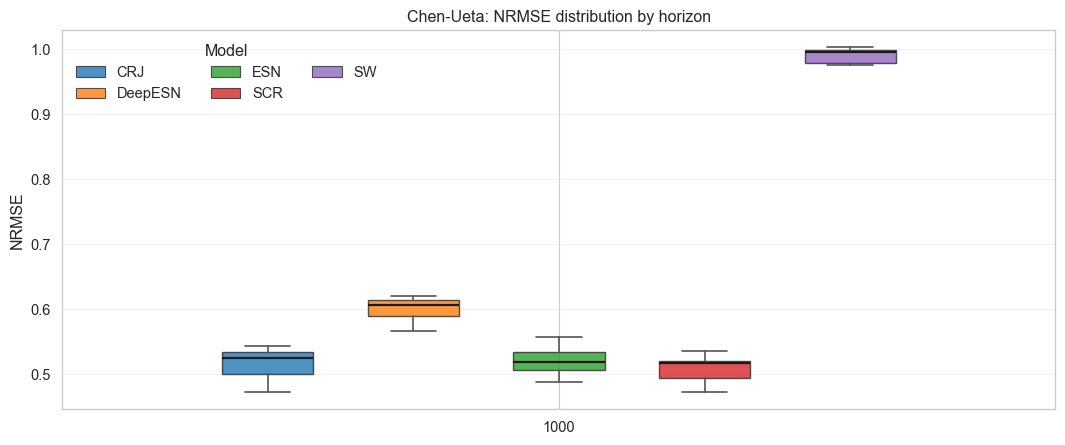

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\chen-ueta_box_nrmse_by_horizon.png


In [47]:
# ======================= NRMSE boxplots by horizon (from nrmse_dict) =======================

# ---- 1) Build a long DataFrame: Model × Horizon × NRMSE (across seeds/runs)
rows = []
for model, runs in nrmse_dict.items():
    # each 'runs[i]' is typically a dict {horizon -> nrmse}
    for run_idx, res in enumerate(runs):
        if isinstance(res, dict):
            for h, v in res.items():
                rows.append({"Model": model, "Horizon": int(h), "NRMSE": float(v), "Run": run_idx})
        else:
            # fallback: assume it's aligned with all_horizons list
            for h, v in zip(all_horizons, res):
                rows.append({"Model": model, "Horizon": int(h), "NRMSE": float(v), "Run": run_idx})

df_nrmse_h = pd.DataFrame(rows)
df_nrmse_h = df_nrmse_h.dropna(subset=["NRMSE"])
df_nrmse_h["Horizon"] = df_nrmse_h["Horizon"].astype(int)
df_nrmse_h = df_nrmse_h.sort_values(["Horizon", "Model"]).reset_index(drop=True)

# ---- 2) Plot manual grouped boxplot with small separation between models
SYSTEM  = globals().get("SYSTEM", "signal")
FIG_DIR = globals().get("FIG_DIR", Path("figs"))

#horizons = sorted(df_nrmse_h["Horizon"].unique())
horizons = [1000]
models   = sorted(df_nrmse_h["Model"].unique())
palette  = sns.color_palette("tab10", n_colors=len(models))
color_of = {m: palette[i] for i, m in enumerate(models)}

fig, ax = plt.subplots(figsize=(10.8, 4.6))

centers     = np.arange(len(horizons))          # one group per horizon
group_width = 0.82                               # total width reserved for a group
inner_gap   = 0.06                               # gap between adjacent model boxes
M           = max(1, len(models))
box_w       = (group_width - inner_gap*(M-1)) / M
start_off   = -group_width/2 + box_w/2
offsets     = start_off + np.arange(M) * (box_w + inner_gap)

# Collect data & positions for matplotlib.boxplot
all_data, positions, colors = [], [], []
for gi, h in enumerate(horizons):
    center = centers[gi]
    for mi, m in enumerate(models):
        vals = df_nrmse_h.query("Horizon == @h and Model == @m")["NRMSE"].values
        if vals.size == 0:
            continue
        all_data.append(vals)
        positions.append(center + offsets[mi])
        colors.append(color_of[m])

bp = ax.boxplot(
    all_data,
    positions=positions,
    widths=box_w * 0.95,
    patch_artist=True,
    showfliers=False,
    showcaps=True,
    medianprops=dict(color="#1a1a1a", linewidth=1.6),
    whiskerprops=dict(color="#555", linewidth=1.2),
    capprops=dict(color="#555", linewidth=1.2)
)

# Color each box
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)
    patch.set_edgecolor("#2b2b2b")
    patch.set_alpha(0.8)
    patch.set_linewidth(1.0)

# Ticks & labels
ax.set_xticks(centers)
ax.set_xticklabels([str(h) for h in horizons])
ax.set_xlim(centers[0] - 0.6, centers[-1] + 0.6)

# Light separators between horizon groups (optional)
for g in centers[:-1]:
    ax.axvline(g + 0.5, color="#e8e8e8", lw=0.6, zorder=0)

# Legend
handles = [Patch(facecolor=color_of[m], edgecolor="#2b2b2b", label=m, alpha=0.8) for m in models]
ax.legend(handles=handles, title="Model", ncol=3, frameon=False)

ax.set_ylabel("NRMSE")
ax.set_xlabel("")
ax.set_title(f"{SYSTEM.title()}: NRMSE distribution by horizon")
ax.grid(axis="y", alpha=0.25)

plt.tight_layout()
out_path = FIG_DIR / f"{SYSTEM}_box_nrmse_by_horizon.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")


In [108]:
print(horizons)

[300, 600, 1000]


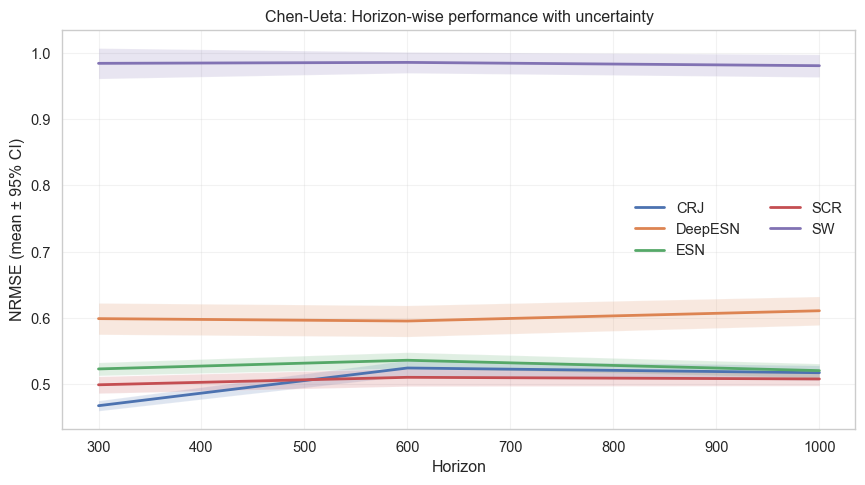

Saved: C:\Users\Ojjas\Desktop\acads\7th sem\Shared-Reservoir-Experiments\Shared-Reservoir-Experiments\figures\chen-ueta_horizon_ribbons.png


In [48]:
# ============================================================
# Horizon curves with mean ± 95% CI ribbons (per model)
# ============================================================

# mean & CI per model × horizon
agg = (df_nrmse_h
       .groupby(["Model","Horizon"])["NRMSE"]
       .agg(["mean","std","count"])
       .reset_index())
agg["se"] = agg["std"] / np.sqrt(agg["count"].clip(lower=1))
agg["lo"] = agg["mean"] - 1.96 * agg["se"]
agg["hi"] = agg["mean"] + 1.96 * agg["se"]

plt.figure(figsize=(8.8, 5))
for m, sub in agg.groupby("Model"):
    sub = sub.sort_values("Horizon")
    plt.plot(sub["Horizon"], sub["mean"], label=m, linewidth=2)
    plt.fill_between(sub["Horizon"], sub["lo"], sub["hi"], alpha=0.18)

plt.xlabel("Horizon"); plt.ylabel("NRMSE (mean ± 95% CI)")
plt.title(f"{SYSTEM.title()}: Horizon-wise performance with uncertainty")
plt.legend(frameon=False, ncol=2)
plt.grid(alpha=0.25)
plt.tight_layout()
out = FIG_DIR / f"{SYSTEM}_horizon_ribbons.png"
plt.savefig(out, dpi=300, bbox_inches="tight"); plt.show()
print(f"Saved: {out}")
